# TO DO:

- habenula


# Imports

In [1]:
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.stats import norm
from scipy import stats
import seaborn as sns
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d
import matplotlib.font_manager as font_manager
from scipy.optimize import curve_fit
import math
from scipy.special import expit
from scipy import signal
import pingouin as pg

# Division / Preprocessing Functions

In [2]:
def divide_data_by_flow_direction(data):
    '''Dividing raw data from one fish into 2 dataframes with either left or right OMR flow'''
    data.columns = ['X_coord', 'Y_coord', 'heading_direction', \
                'cumulative_direction','beat_freq', 'beat_amp', \
                'tail_move?', 'timestamp', 'contrast_level', 'flow_direction']
    right = pd.DataFrame(data[data.flow_direction == 1])
    left = pd.DataFrame(data[data.flow_direction == 2])
    zero = pd.DataFrame(data[data.flow_direction == 0])

    return right, left, zero

def divide_data_by_contrast(data):
    '''Dividing raw data from one fish and one flow direction into contrast levels'''
    C_0 = pd.DataFrame(data[data.contrast_level == 0])
    C_01 = pd.DataFrame(data[data.contrast_level == 0.01])
    C_1 = pd.DataFrame(data[data.contrast_level == 0.1])
    C_2 = pd.DataFrame(data[data.contrast_level == 0.2])
    C_3 = pd.DataFrame(data[data.contrast_level == 0.3])
    C_5 = pd.DataFrame(data[data.contrast_level == 0.5])
    C_7 = pd.DataFrame(data[data.contrast_level == 0.7])
    C_10 = pd.DataFrame(data[data.contrast_level == 1])
    return C_0, C_01, C_1, C_2, C_3, C_5, C_7, C_10

def omr_preprocess(data):
    # remove timestamp and extras
    # keep x, y, heading, cumulative, timestamp
    data.columns = ['X_coord', 'Y_coord', 'heading_direction', \
                'cumulative_direction','beat_freq', 'beat_amp', \
                'tail_move?', 'timestamp', 'contrast_level', 'flow_direction']
    new = data.drop(columns = ['beat_freq', 'beat_amp','tail_move?', 'contrast_level', 'flow_direction'])
    
    # resetting index
    new = pd.DataFrame(new)
    new = new.set_index('timestamp').reset_index()


    # remove time points where there was an angle change of more than pi from one frame to another
    for i, row in new.iterrows():
        if i+1 == len(new):
            break
            # modify to add the exclusion zone
        if np.abs(new.at[i+1,'cumulative_direction']-new.at[i,'cumulative_direction']) >= 2.5:
            new.at[i+1, 'cumulative_direction'] = new.at[i,'cumulative_direction']

    tstp = np.arange(0,30,30/len(new))
    if len(new['timestamp']) != len(tstp):
        tstp = tstp[:-1]
    tstpdate = pd.to_datetime(tstp,unit='s')
    new['timestamp'] = tstp
    new['tstpdate'] = tstpdate
    new = new.set_index('tstpdate')
    new_df = new.resample('10ms')
    new_df = new_df.first()
    new_df.interpolate(method='linear',inplace=True)

    interp = new_df.copy()
    # setting first cumulative_angle to zero and ajdusting all others
    interp.iloc[:,4] -= interp.iloc[0,4]


    # calculating distance traveled between each timeframe
    # distance = sqrt((x2-x1)**2 + (y2-y1)**2)
    interp['distance_pts'] = 0
    for row in range(1,len(interp),1):
        distance = np.sqrt((interp['X_coord'][row]-interp['X_coord'][row-1])**2\
                            +(interp['Y_coord'][row]-interp['Y_coord'][row-1])**2)
        interp.iloc[row,5] = distance


    #cleaning the timestamps
    interp.insert(0, 'new_timestamp', range(1, 1 + len(interp)))
    interp = interp.drop(columns=['timestamp']).rename(columns={'new_timestamp':'timestamp'})
    interp['timestamp'] = interp['timestamp']/100

    #resetting index to integers
    interp = interp.reset_index()
    interp = interp.drop(columns=['tstpdate'])

    return np.array(interp)

def combine_fish_data(*args):
    '''Combines preprocessed data from all fish into a 3D numpy array'''
    combined_fish = np.stack((args),axis=0)
    return combined_fish

# Reading / Preprocessing Files

In [3]:
for e in range(1,31):
    exec(f'pm_e{e} = pd.read_csv("../raw_data/PM/E2/xy_hc_fai_tstp_E2_{e}_PM.csv")')
    
for e in range(1,31):
    exec(f'pm_Re{e},pm_Le{e},pm_Ze{e} = divide_data_by_flow_direction(pm_e{e})')

for flow in ['R','L','Z']:
    for e in range(1,31):
        exec(f'pm_{flow}e{e}C_0, pm_{flow}e{e}C_1, pm_{flow}e{e}C_10, pm_{flow}e{e}C_20, pm_{flow}e{e}C_30, \
            pm_{flow}e{e}C_50, pm_{flow}e{e}C_70, pm_{flow}e{e}C_100 = divide_data_by_contrast(pm_{flow}e{e})')

for flow in ['R','L']:
    for contrast in ['1','10','20','30','50','70','100']:
        for e in range(1,31):
            exec(f'pm_{flow}e{e}C_{contrast} = omr_preprocess(pm_{flow}e{e}C_{contrast})')

In [4]:
for me in range(1,34):
    exec(f'pm_me{me} = pd.read_csv("../raw_data/PM/Met/xy_hc_fai_tstp_Me_{me}_PM.csv")')
    
for me in range(1,34):
    exec(f'pm_Rme{me},pm_Lme{me},pm_Zme{me} = divide_data_by_flow_direction(pm_me{me})')

for flow in ['R','L','Z']:
    for me in range(1,34):
        exec(f'pm_{flow}me{me}C_0, pm_{flow}me{me}C_1, pm_{flow}me{me}C_10, pm_{flow}me{me}C_20, pm_{flow}me{me}C_30, \
            pm_{flow}me{me}C_50, pm_{flow}me{me}C_70, pm_{flow}me{me}C_100 = divide_data_by_contrast(pm_{flow}me{me})')

for flow in ['R','L']:
    for contrast in ['1','10','20','30','50','70','100']:
        for me in range(1,34):
            exec(f'pm_{flow}me{me}C_{contrast} = omr_preprocess(pm_{flow}me{me}C_{contrast})')

In [5]:
for e in range(1,23):
    exec(f'am_e{e} = pd.read_csv("../raw_data/AM/E2/xy_hc_fai_tstp_E2_{e}_AM.csv")')

for e in range(1,23):
    exec(f'am_Re{e},am_Le{e},am_Ze{e} = divide_data_by_flow_direction(am_e{e})')
    
for flow in ['R','L','Z']:
    for e in range(1,23):
        exec(f'am_{flow}e{e}C_0, am_{flow}e{e}C_1, am_{flow}e{e}C_10, am_{flow}e{e}C_20, am_{flow}e{e}C_30, \
            am_{flow}e{e}C_50, am_{flow}e{e}C_70, am_{flow}e{e}C_100 = divide_data_by_contrast(am_{flow}e{e})')

for flow in ['R','L']:
    for contrast in ['1','10','20','30','50','70','100']:
        for e in range(1,23):
            exec(f'am_{flow}e{e}C_{contrast} = omr_preprocess(am_{flow}e{e}C_{contrast})')

In [6]:
for me in range(1,23):
    exec(f'am_me{me} = pd.read_csv("../raw_data/AM/Met/xy_hc_fai_tstp_Me_{me}_AM.csv")')
    
for me in range(1,23):
    exec(f'am_Rme{me},am_Lme{me},am_Zme{me} = divide_data_by_flow_direction(am_me{me})')

for flow in ['R','L','Z']:
    for me in range(1,23):
        exec(f'am_{flow}me{me}C_0, am_{flow}me{me}C_1, am_{flow}me{me}C_10, am_{flow}me{me}C_20, am_{flow}me{me}C_30,\
        am_{flow}me{me}C_50, am_{flow}me{me}C_70, am_{flow}me{me}C_100 = divide_data_by_contrast(am_{flow}me{me})')

for flow in ['R','L']:
    for contrast in ['1','10','20','30','50','70','100']:
        for me in range(1,23):
            exec(f'am_{flow}me{me}C_{contrast} = omr_preprocess(am_{flow}me{me}C_{contrast})')

# Filtering Data

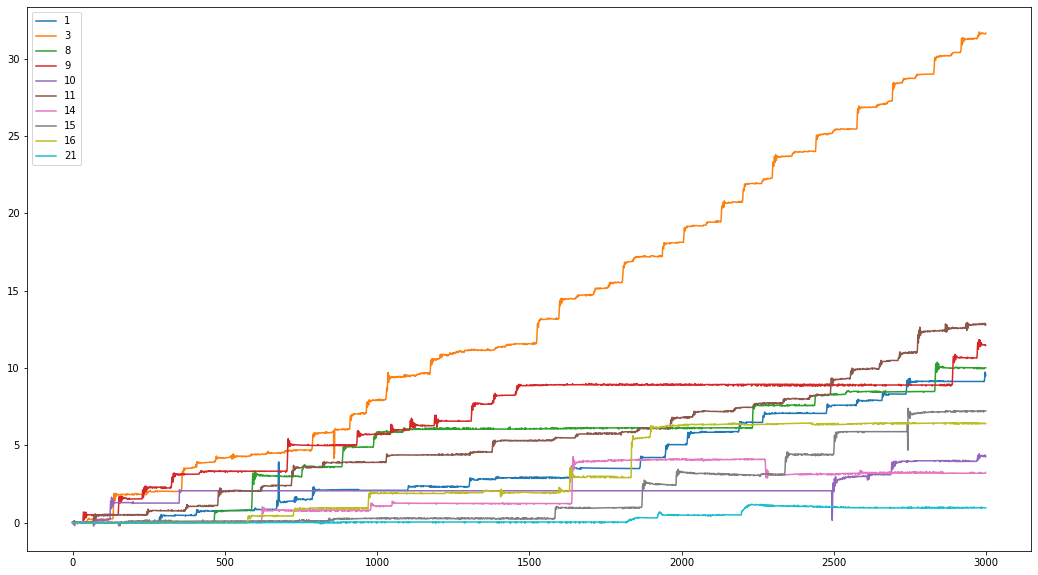

In [7]:
fig, ax = plt.subplots(1,1,figsize=(18,10))
plt.plot(am_Le1C_100[:,4], label='1')
# plt.plot(am_Le2C_100[:,4], label='2')
plt.plot(am_Le3C_100[:,4], label='3')
# plt.plot(am_Le4C_100[:,4], label='4')
# plt.plot(am_Le5C_100[:,4], label='5')
# plt.plot(am_Le6C_100[:,4], label='6')
# plt.plot(am_Le7C_100[:,4], label='7')
plt.plot(am_Le8C_100[:,4], label='8')
plt.plot(am_Le9C_100[:,4], label='9')
plt.plot(am_Le10C_100[:,4], label='10')
plt.plot(am_Le11C_100[:,4], label='11')
# plt.plot(am_Le12C_100[:,4], label='12')
# plt.plot(am_Le13C_100[:,4], label='13')
plt.plot(am_Le14C_100[:,4], label='14')
plt.plot(am_Le15C_100[:,4], label='15')
plt.plot(am_Le16C_100[:,4], label='16')
# plt.plot(am_Le17C_100[:,4], label='17')
# plt.plot(am_Le18C_100[:,4], label='18')
# plt.plot(am_Le19C_100[:,4], label='19')
# plt.plot(am_Le20C_100[:,4], label='20')
plt.plot(am_Le21C_100[:,4], label='21')
# plt.plot(am_Le22C_100[:,4], label='22')
# plt.plot(am_Le23C_100[:,4], label='23')
# plt.plot(am_Le24C_100[:,4], label='24')
# plt.plot(am_Le25C_100[:,4], label='25')
# plt.plot(am_Le26C_100[:,4], label='26')
# plt.plot(am_Le27C_100[:,4], label='27')
# plt.plot(am_Le28C_100[:,4], label='28')
# plt.plot(am_Le29C_100[:,4], label='29')
# plt.plot(am_Le30C_100[:,4], label='30')
plt.legend()

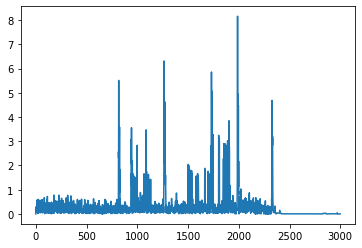

In [8]:
plt.plot(am_Rme12C_1[:,5])

# Combining Fish into 3D Arrays

In [9]:
pm_comb_LeC1 = combine_fish_data(pm_Le1C_1,pm_Le2C_1,pm_Le3C_1,pm_Le4C_1,pm_Le5C_1,pm_Le6C_1,pm_Le8C_1,pm_Le10C_1,\
                                 pm_Le11C_1,pm_Le12C_1,pm_Le13C_1,pm_Le14C_1,pm_Le17C_1,pm_Le18C_1,pm_Le19C_1,\
                                 pm_Le20C_1,pm_Le21C_1,pm_Le22C_1,pm_Le23C_1,pm_Le24C_1,pm_Le25C_1,pm_Le26C_1,\
                                 pm_Le27C_1,pm_Le28C_1,pm_Le29C_1,pm_Le30C_1)
pm_comb_LeC10 = combine_fish_data(pm_Le1C_10,pm_Le2C_10,pm_Le3C_10,pm_Le4C_10,pm_Le5C_10,pm_Le6C_10,pm_Le7C_10,\
                                  pm_Le8C_10,pm_Le10C_10,pm_Le12C_10,pm_Le13C_10,pm_Le14C_10,pm_Le16C_10,pm_Le19C_10,\
                                  pm_Le20C_10,pm_Le21C_10,pm_Le22C_10,pm_Le23C_10,pm_Le24C_10,pm_Le25C_10,\
                                  pm_Le26C_10,pm_Le27C_10,pm_Le28C_10,pm_Le29C_10,pm_Le30C_10)
pm_comb_LeC20 = combine_fish_data(pm_Le2C_20,pm_Le3C_20,pm_Le4C_20,pm_Le5C_20,pm_Le6C_20,pm_Le7C_20,pm_Le8C_20,\
                                  pm_Le10C_20,pm_Le13C_20,pm_Le14C_20,pm_Le15C_20,pm_Le16C_20,pm_Le18C_20,\
                                  pm_Le19C_20,pm_Le20C_20,pm_Le21C_20,pm_Le22C_20,pm_Le23C_20,pm_Le24C_20,\
                                  pm_Le25C_20,pm_Le26C_20,pm_Le27C_20,pm_Le28C_20,pm_Le29C_20,pm_Le30C_20)
pm_comb_LeC30 = combine_fish_data(pm_Le1C_30,pm_Le2C_30,pm_Le3C_30,pm_Le4C_30,pm_Le5C_30,pm_Le6C_30,pm_Le7C_30,\
                                  pm_Le8C_30,pm_Le11C_30,pm_Le13C_30,pm_Le14C_30,pm_Le15C_30,pm_Le17C_30,\
                                  pm_Le19C_30,pm_Le20C_30,pm_Le21C_30,pm_Le22C_30,pm_Le23C_30,pm_Le24C_30,\
                                  pm_Le25C_30,pm_Le26C_30,pm_Le27C_30,pm_Le28C_30,pm_Le29C_30,pm_Le30C_30)
pm_comb_LeC50 = combine_fish_data(pm_Le1C_50,pm_Le2C_50,pm_Le3C_50,pm_Le4C_50,pm_Le5C_50,pm_Le6C_50,pm_Le7C_50,\
                                  pm_Le8C_50,pm_Le11C_50,pm_Le16C_50,pm_Le18C_50,pm_Le19C_50,pm_Le20C_50,pm_Le21C_50,\
                                  pm_Le22C_50,pm_Le23C_50,pm_Le24C_50,pm_Le25C_50,pm_Le27C_50,pm_Le28C_50,\
                                  pm_Le29C_50,pm_Le30C_50)
pm_comb_LeC70 = combine_fish_data(pm_Le1C_70,pm_Le2C_70,pm_Le3C_70,pm_Le4C_70,pm_Le5C_70,pm_Le6C_70,pm_Le7C_70,\
                                  pm_Le8C_70,pm_Le9C_70,pm_Le10C_70,pm_Le11C_70,pm_Le13C_70,pm_Le14C_70,pm_Le15C_70,\
                                  pm_Le17C_70,pm_Le18C_70,pm_Le19C_70,pm_Le21C_70,pm_Le22C_70,pm_Le23C_70,\
                                  pm_Le24C_70,pm_Le25C_70,pm_Le26C_70,pm_Le27C_70,pm_Le28C_70,pm_Le29C_70,pm_Le30C_70)
pm_comb_LeC100 = combine_fish_data(pm_Le1C_100,pm_Le2C_100,pm_Le3C_100,pm_Le4C_100,pm_Le5C_100,pm_Le6C_100,\
                                   pm_Le7C_100,pm_Le8C_100,pm_Le10C_100,pm_Le11C_100,pm_Le12C_100,pm_Le13C_100,\
                                   pm_Le14C_100,pm_Le16C_100,pm_Le18C_100,pm_Le19C_100,pm_Le20C_100,pm_Le21C_100,\
                                   pm_Le22C_100,pm_Le23C_100,pm_Le24C_100,pm_Le25C_100,pm_Le26C_100,pm_Le27C_100,\
                                   pm_Le28C_100,pm_Le29C_100,pm_Le30C_100)

pm_comb_ReC1 = combine_fish_data(pm_Re1C_1,pm_Re2C_1,pm_Re3C_1,pm_Re4C_1,pm_Re5C_1,pm_Re6C_1,pm_Re8C_1,pm_Re10C_1,\
                                 pm_Re13C_1,pm_Re14C_1,pm_Re16C_1,pm_Re17C_1,pm_Re18C_1,pm_Re19C_1,pm_Re20C_1,\
                                 pm_Re21C_1,pm_Re22C_1,pm_Re23C_1,pm_Re24C_1,pm_Re25C_1,pm_Re26C_1,pm_Re27C_1,\
                                 pm_Re28C_1,pm_Re29C_1,pm_Re30C_1)
pm_comb_ReC10 = combine_fish_data(pm_Re1C_10,pm_Re2C_10,pm_Re3C_10,pm_Re4C_10,pm_Re5C_10,pm_Re6C_10,pm_Re7C_10,\
                                  pm_Re8C_10,pm_Re11C_10,pm_Re12C_10,pm_Re13C_10,pm_Re14C_10,pm_Re17C_10,\
                                  pm_Re18C_10,pm_Re19C_10,pm_Re20C_10,pm_Re21C_10,pm_Re22C_10,pm_Re23C_10,\
                                  pm_Re24C_10,pm_Re25C_10,pm_Re26C_10,pm_Re27C_10,pm_Re28C_10,pm_Re29C_10,pm_Re30C_10)
pm_comb_ReC20 = combine_fish_data(pm_Re1C_20,pm_Re2C_20,pm_Re3C_20,pm_Re4C_20,pm_Re5C_20,pm_Re6C_20,pm_Re8C_20,\
                                  pm_Re9C_20,pm_Re10C_20,pm_Re11C_20,pm_Re13C_20,pm_Re14C_20,pm_Re15C_20,pm_Re16C_20,\
                                  pm_Re18C_20,pm_Re19C_20,pm_Re20C_20,pm_Re21C_20,pm_Re22C_20,pm_Re23C_20,\
                                  pm_Re24C_20,pm_Re25C_20,pm_Re26C_20,pm_Re27C_20,pm_Re28C_20,pm_Re29C_20,pm_Re30C_20)
pm_comb_ReC30 = combine_fish_data(pm_Re1C_30,pm_Re2C_30,pm_Re3C_30,pm_Re4C_30,pm_Re5C_30,pm_Re6C_30,pm_Re8C_30,\
                                  pm_Re11C_30,pm_Re12C_30,pm_Re13C_30,pm_Re15C_30,pm_Re17C_30,pm_Re18C_30,\
                                  pm_Re19C_30,pm_Re20C_30,pm_Re21C_30,pm_Re22C_30,pm_Re23C_30,pm_Re24C_30,\
                                  pm_Re25C_30,pm_Re26C_30,pm_Re27C_30,pm_Re28C_30,pm_Re29C_30,pm_Re30C_30)
pm_comb_ReC50 = combine_fish_data(pm_Re1C_50,pm_Re2C_50,pm_Re3C_50,pm_Re4C_50,pm_Re5C_50,pm_Re6C_50,pm_Re8C_50,\
                                  pm_Re11C_50,pm_Re13C_50,pm_Re14C_50,pm_Re15C_50,pm_Re16C_50,pm_Re17C_50,\
                                  pm_Re18C_50,pm_Re19C_50,pm_Re20C_50,pm_Re21C_50,pm_Re22C_50,pm_Re23C_50,\
                                  pm_Re24C_50,pm_Re25C_50,pm_Re26C_50,pm_Re27C_50,pm_Re28C_50,pm_Re29C_50,pm_Re30C_50)
pm_comb_ReC70 = combine_fish_data(pm_Re1C_70,pm_Re2C_70,pm_Re3C_70,pm_Re4C_70,pm_Re5C_70,pm_Re6C_70,pm_Re8C_70,\
                                  pm_Re12C_70,pm_Re13C_70,pm_Re14C_70,pm_Re16C_70,pm_Re17C_70,pm_Re18C_70,\
                                  pm_Re19C_70,pm_Re20C_70,pm_Re21C_70,pm_Re22C_70,pm_Re23C_70,pm_Re24C_70,\
                                  pm_Re25C_70,pm_Re27C_70,pm_Re28C_70,pm_Re29C_70,pm_Re30C_70)
pm_comb_ReC100 = combine_fish_data(pm_Re1C_100,pm_Re2C_100,pm_Re3C_100,pm_Re4C_100,pm_Re5C_100,pm_Re6C_100,\
                                   pm_Re8C_100,pm_Re10C_100,pm_Re11C_100,pm_Re13C_100,pm_Re14C_100,pm_Re17C_100,\
                                   pm_Re18C_100,pm_Re19C_100,pm_Re21C_100,pm_Re22C_100,pm_Re23C_100,pm_Re24C_100,\
                                   pm_Re25C_100,pm_Re26C_100,pm_Re27C_100,pm_Re28C_100,pm_Re29C_100,pm_Re30C_100)


In [10]:
pm_comb_LmeC1 = combine_fish_data(pm_Lme1C_1,pm_Lme2C_1,pm_Lme3C_1,pm_Lme4C_1,pm_Lme5C_1,pm_Lme6C_1,pm_Lme7C_1,\
                                  pm_Lme8C_1,pm_Lme9C_1,pm_Lme10C_1,pm_Lme12C_1,pm_Lme13C_1,pm_Lme14C_1,pm_Lme16C_1,\
                                  pm_Lme17C_1,pm_Lme19C_1,pm_Lme20C_1,pm_Lme21C_1,pm_Lme23C_1,pm_Lme24C_1,\
                                  pm_Lme25C_1,pm_Lme26C_1,pm_Lme27C_1,pm_Lme28C_1,pm_Lme29C_1,pm_Lme30C_1,\
                                  pm_Lme31C_1,pm_Lme32C_1,pm_Lme33C_1)
pm_comb_LmeC10 = combine_fish_data(pm_Lme1C_10,pm_Lme2C_10,pm_Lme3C_10,pm_Lme4C_10,pm_Lme5C_10,pm_Lme6C_10,\
                                   pm_Lme7C_10,pm_Lme8C_10,pm_Lme10C_10,pm_Lme11C_10,pm_Lme12C_10,pm_Lme14C_10,\
                                   pm_Lme15C_10,pm_Lme16C_10,pm_Lme17C_10,pm_Lme18C_10,pm_Lme21C_10,pm_Lme22C_10,\
                                   pm_Lme23C_10,pm_Lme25C_10,pm_Lme26C_10,pm_Lme27C_10,pm_Lme28C_10,pm_Lme29C_10,\
                                   pm_Lme30C_10,pm_Lme31C_10,pm_Lme32C_10,pm_Lme33C_10)
pm_comb_LmeC20 = combine_fish_data(pm_Lme1C_20,pm_Lme2C_20,pm_Lme3C_20,pm_Lme4C_20,pm_Lme5C_20,pm_Lme6C_20,\
                                   pm_Lme7C_20,pm_Lme8C_20,pm_Lme9C_20,pm_Lme10C_20,pm_Lme11C_20,pm_Lme12C_20,\
                                   pm_Lme14C_20,pm_Lme15C_20,pm_Lme17C_20,pm_Lme18C_20,pm_Lme20C_20,pm_Lme21C_20,\
                                   pm_Lme22C_20,pm_Lme23C_20,pm_Lme24C_20,pm_Lme25C_20,pm_Lme26C_20,pm_Lme27C_20,\
                                   pm_Lme28C_20,pm_Lme29C_20,pm_Lme31C_20,pm_Lme32C_20,pm_Lme33C_20)
pm_comb_LmeC30 = combine_fish_data(pm_Lme1C_30,pm_Lme2C_30,pm_Lme3C_30,pm_Lme4C_30,pm_Lme5C_30,pm_Lme6C_30,\
                                   pm_Lme7C_30,pm_Lme8C_30,pm_Lme9C_30,pm_Lme10C_30,pm_Lme11C_30,pm_Lme12C_30,\
                                   pm_Lme14C_30,pm_Lme15C_30,pm_Lme16C_30,pm_Lme17C_30,pm_Lme18C_30,pm_Lme20C_30,\
                                   pm_Lme23C_30,pm_Lme24C_30,pm_Lme25C_30,pm_Lme26C_30,pm_Lme27C_30,pm_Lme28C_30,\
                                   pm_Lme29C_30,pm_Lme30C_30,pm_Lme31C_30,pm_Lme32C_30,pm_Lme33C_30)
pm_comb_LmeC50 = combine_fish_data(pm_Lme1C_50,pm_Lme2C_50,pm_Lme3C_50,pm_Lme4C_50,pm_Lme5C_50,pm_Lme6C_50,\
                                   pm_Lme7C_50,pm_Lme8C_50,pm_Lme9C_50,pm_Lme10C_50,pm_Lme11C_50,pm_Lme13C_50,\
                                   pm_Lme14C_50,pm_Lme15C_50,pm_Lme16C_50,pm_Lme17C_50,pm_Lme18C_50,pm_Lme19C_50,\
                                   pm_Lme20C_50,pm_Lme21C_50,pm_Lme22C_50,pm_Lme23C_50,pm_Lme24C_50,pm_Lme25C_50,\
                                   pm_Lme26C_50,pm_Lme27C_50,pm_Lme28C_50,pm_Lme29C_50,pm_Lme30C_50,pm_Lme31C_50,\
                                   pm_Lme32C_50,pm_Lme33C_50)
pm_comb_LmeC70 = combine_fish_data(pm_Lme1C_70,pm_Lme2C_70,pm_Lme4C_70,pm_Lme5C_70,pm_Lme6C_70,pm_Lme7C_70,\
                                   pm_Lme8C_70,pm_Lme9C_70,pm_Lme10C_70,pm_Lme11C_70,pm_Lme12C_70,pm_Lme13C_70,\
                                   pm_Lme15C_70,pm_Lme16C_70,pm_Lme17C_70,pm_Lme18C_70,pm_Lme20C_70,pm_Lme21C_70,\
                                   pm_Lme22C_70,pm_Lme23C_70,pm_Lme24C_70,pm_Lme25C_70,pm_Lme26C_70,pm_Lme27C_70,\
                                   pm_Lme28C_70,pm_Lme29C_70,pm_Lme30C_70,pm_Lme31C_70,pm_Lme32C_70,pm_Lme33C_70)
pm_comb_LmeC100 = combine_fish_data(pm_Lme4C_100,pm_Lme6C_100,pm_Lme7C_100,pm_Lme8C_100,pm_Lme11C_100,pm_Lme12C_100,\
                                    pm_Lme15C_100,pm_Lme17C_100,pm_Lme18C_100,pm_Lme20C_100,pm_Lme21C_100,\
                                    pm_Lme22C_100,pm_Lme24C_100,pm_Lme25C_100,pm_Lme26C_100,pm_Lme27C_100,\
                                    pm_Lme28C_100,pm_Lme30C_100,pm_Lme31C_100,pm_Lme32C_100,pm_Lme33C_100)

pm_comb_RmeC1 = combine_fish_data(pm_Rme1C_1,pm_Rme2C_1,pm_Rme3C_1,pm_Rme4C_1,pm_Rme5C_1,pm_Rme6C_1,pm_Rme7C_1,\
                                  pm_Rme8C_1,pm_Rme10C_1,pm_Rme12C_1,pm_Rme14C_1,pm_Rme16C_1,pm_Rme21C_1,pm_Rme22C_1,\
                                  pm_Rme23C_1,pm_Rme24C_1,pm_Rme25C_1,pm_Rme26C_1,pm_Rme27C_1,pm_Rme28C_1,\
                                  pm_Rme29C_1,pm_Rme30C_1,pm_Rme31C_1,pm_Rme32C_1,pm_Rme33C_1)
pm_comb_RmeC10 = combine_fish_data(pm_Rme1C_10,pm_Rme2C_10,pm_Rme3C_10,pm_Rme4C_10,pm_Rme5C_10,pm_Rme6C_10,\
                                   pm_Rme7C_10,pm_Rme10C_10,pm_Rme11C_10,pm_Rme12C_10,pm_Rme14C_10,pm_Rme18C_10,\
                                   pm_Rme21C_10,pm_Rme22C_10,pm_Rme23C_10,pm_Rme24C_10,pm_Rme25C_10,pm_Rme26C_10,\
                                   pm_Rme27C_10,pm_Rme28C_10,pm_Rme29C_10,pm_Rme30C_10,pm_Rme31C_10,pm_Rme32C_10,\
                                   pm_Rme33C_10)
pm_comb_RmeC20 = combine_fish_data(pm_Rme1C_20,pm_Rme2C_20,pm_Rme3C_20,pm_Rme4C_20,pm_Rme5C_20,pm_Rme6C_20,\
                                   pm_Rme7C_20,pm_Rme8C_20,pm_Rme9C_20,pm_Rme10C_20,pm_Rme11C_20,pm_Rme12C_20,\
                                   pm_Rme13C_20,pm_Rme14C_20,pm_Rme15C_20,pm_Rme16C_20,pm_Rme17C_20,pm_Rme19C_20,\
                                   pm_Rme21C_20,pm_Rme22C_20,pm_Rme23C_20,pm_Rme24C_20,pm_Rme25C_20,pm_Rme26C_20,\
                                   pm_Rme27C_20,pm_Rme28C_20,pm_Rme29C_20,pm_Rme31C_20,pm_Rme32C_20,pm_Rme33C_20)
pm_comb_RmeC30 = combine_fish_data(pm_Rme1C_30,pm_Rme2C_30,pm_Rme3C_30,pm_Rme4C_30,pm_Rme5C_30,pm_Rme6C_30,\
                                   pm_Rme7C_30,pm_Rme8C_30,pm_Rme12C_30,pm_Rme13C_30,pm_Rme14C_30,pm_Rme17C_30,\
                                   pm_Rme18C_30,pm_Rme19C_30,pm_Rme21C_30,pm_Rme22C_30,pm_Rme23C_30,pm_Rme24C_30,\
                                   pm_Rme25C_30,pm_Rme26C_30,pm_Rme27C_30,pm_Rme28C_30,pm_Rme29C_30,pm_Rme30C_30,\
                                   pm_Rme31C_30,pm_Rme32C_30,pm_Rme33C_30)
pm_comb_RmeC50 = combine_fish_data(pm_Rme1C_50,pm_Rme2C_50,pm_Rme3C_50,pm_Rme4C_50,pm_Rme5C_50,pm_Rme6C_50,\
                                   pm_Rme7C_50,pm_Rme8C_50,pm_Rme9C_50,pm_Rme10C_50,pm_Rme11C_50,pm_Rme12C_50,\
                                   pm_Rme13C_50,pm_Rme14C_50,pm_Rme15C_50,pm_Rme16C_50,pm_Rme17C_50,pm_Rme18C_50,\
                                   pm_Rme22C_50,pm_Rme23C_50,pm_Rme24C_50,pm_Rme25C_50,pm_Rme26C_50,pm_Rme27C_50,\
                                   pm_Rme28C_50,pm_Rme29C_50,pm_Rme30C_50,pm_Rme31C_50,pm_Rme32C_50,pm_Rme33C_50)
pm_comb_RmeC70 = combine_fish_data(pm_Rme1C_70,pm_Rme2C_70,pm_Rme3C_70,pm_Rme4C_70,pm_Rme5C_70,pm_Rme6C_70,\
                                   pm_Rme7C_70,pm_Rme8C_70,pm_Rme9C_70,pm_Rme10C_70,pm_Rme12C_70,pm_Rme13C_70,\
                                   pm_Rme14C_70,pm_Rme15C_70,pm_Rme16C_70,pm_Rme17C_70,pm_Rme18C_70,pm_Rme19C_70,\
                                   pm_Rme20C_70,pm_Rme21C_70,pm_Rme22C_70,pm_Rme23C_70,pm_Rme24C_70,pm_Rme25C_70,\
                                   pm_Rme26C_70,pm_Rme27C_70,pm_Rme28C_70,pm_Rme30C_70,pm_Rme31C_70,pm_Rme32C_70,\
                                   pm_Rme33C_70)
pm_comb_RmeC100 = combine_fish_data(pm_Rme2C_100,pm_Rme3C_100,pm_Rme4C_100,pm_Rme5C_100,pm_Rme6C_100,pm_Rme7C_100,\
                                    pm_Rme8C_100,pm_Rme9C_100,pm_Rme10C_100,pm_Rme12C_100,pm_Rme13C_100,\
                                    pm_Rme14C_100,pm_Rme15C_100,pm_Rme16C_100,pm_Rme17C_100,pm_Rme18C_100,\
                                    pm_Rme21C_100,pm_Rme22C_100,pm_Rme23C_100,pm_Rme25C_100,pm_Rme26C_100,\
                                    pm_Rme27C_100,pm_Rme28C_100,pm_Rme29C_100,pm_Rme30C_100,pm_Rme31C_100,\
                                    pm_Rme32C_100,pm_Rme33C_100)


In [11]:
am_comb_LeC1 = combine_fish_data(am_Le2C_1,am_Le3C_1,am_Le4C_1,am_Le5C_1,am_Le6C_1,am_Le7C_1,am_Le9C_1,am_Le10C_1,\
                                 am_Le11C_1,am_Le12C_1,am_Le13C_1,am_Le14C_1,am_Le15C_1,am_Le17C_1,am_Le18C_1,\
                                 am_Le19C_1,am_Le20C_1,am_Le21C_1,am_Le22C_1)
am_comb_LeC10 = combine_fish_data(am_Le1C_10,am_Le2C_10,am_Le3C_10,am_Le4C_10,am_Le5C_10,am_Le6C_10,am_Le7C_10,\
                                  am_Le8C_10,am_Le11C_10,am_Le12C_10,am_Le13C_10,am_Le14C_10,am_Le15C_10,am_Le17C_10,\
                                  am_Le19C_10,am_Le20C_10,am_Le21C_10,am_Le22C_10)
am_comb_LeC20 = combine_fish_data(am_Le1C_20,am_Le3C_20,am_Le4C_20,am_Le6C_20,am_Le9C_20,am_Le10C_20,am_Le11C_20,\
                                  am_Le12C_20,am_Le13C_20,am_Le14C_20,am_Le15C_20,am_Le16C_20,am_Le17C_20,\
                                  am_Le18C_20,am_Le20C_20,am_Le21C_20,am_Le22C_20)
am_comb_LeC30 = combine_fish_data(am_Le1C_30,am_Le2C_30,am_Le3C_30,am_Le4C_30,am_Le5C_30,am_Le6C_30,am_Le7C_30,\
                                  am_Le8C_30,am_Le9C_30,am_Le11C_30,am_Le12C_30,am_Le14C_30,am_Le15C_30,am_Le16C_30,\
                                  am_Le17C_30,am_Le18C_30,am_Le20C_30,am_Le21C_30,am_Le22C_30)
am_comb_LeC50 = combine_fish_data(am_Le1C_50,am_Le2C_50,am_Le3C_50,am_Le4C_50,am_Le6C_50,am_Le7C_50,am_Le8C_50,\
                                  am_Le9C_50,am_Le13C_50,am_Le14C_50,am_Le15C_50,am_Le16C_50,am_Le17C_50,\
                                  am_Le18C_50,am_Le19C_50,am_Le20C_50,am_Le21C_50,am_Le22C_50)
am_comb_LeC70 = combine_fish_data(am_Le1C_70,am_Le2C_70,am_Le3C_70,am_Le4C_70,am_Le6C_70,am_Le7C_70,am_Le9C_70,\
                                  am_Le10C_70,am_Le11C_70,am_Le12C_70,am_Le13C_70,am_Le14C_70,am_Le15C_70,\
                                  am_Le16C_70,am_Le17C_70,am_Le19C_70,am_Le20C_70,am_Le21C_70,am_Le22C_70)
am_comb_LeC100 = combine_fish_data(am_Le1C_100,am_Le3C_100,am_Le8C_100,am_Le9C_100,am_Le10C_100,am_Le11C_100,\
                                   am_Le14C_100,am_Le15C_100,am_Le16C_100,am_Le21C_100)

am_comb_ReC1 = combine_fish_data(am_Re2C_1,am_Re4C_1,am_Re5C_1,am_Re6C_1,am_Re7C_1,am_Re8C_1,am_Re9C_1,am_Re10C_1,\
                                 am_Re12C_1,am_Re13C_1,am_Re15C_1,am_Re16C_1,am_Re17C_1,am_Re18C_1,am_Re19C_1,\
                                 am_Re20C_1,am_Re21C_1,am_Re22C_1)
am_comb_ReC10 = combine_fish_data(am_Re1C_10,am_Re2C_10,am_Re3C_10,am_Re4C_10,am_Re5C_10,am_Re6C_10,am_Re7C_10,\
                                  am_Re8C_10,am_Re9C_10,am_Re12C_10,am_Re13C_10,am_Re14C_10,am_Re15C_10,am_Re16C_10,\
                                  am_Re17C_10,am_Re18C_10,am_Re19C_10,am_Re20C_10,am_Re21C_10,am_Re22C_10)
am_comb_ReC20 = combine_fish_data(am_Re1C_20,am_Re2C_20,am_Re3C_20,am_Re4C_20,am_Re5C_20,am_Re6C_20,am_Re7C_20,\
                                  am_Re8C_20,am_Re9C_20,am_Re11C_20,am_Re12C_20,am_Re13C_20,am_Re14C_20,am_Re15C_20,\
                                  am_Re16C_20,am_Re17C_20,am_Re18C_20,am_Re20C_20,am_Re21C_20,am_Re22C_20)
am_comb_ReC30 = combine_fish_data(am_Re1C_30,am_Re2C_30,am_Re3C_30,am_Re4C_30,am_Re5C_30,am_Re6C_30,am_Re8C_30,\
                                  am_Re9C_30,am_Re11C_30,am_Re12C_30,am_Re14C_30,am_Re15C_30,am_Re16C_30,\
                                  am_Re17C_30,am_Re18C_30,am_Re19C_30,am_Re20C_30,am_Re21C_30,am_Re22C_30)
am_comb_ReC50 = combine_fish_data(am_Re1C_50,am_Re2C_50,am_Re3C_50,am_Re4C_50,am_Re5C_50,am_Re6C_50,am_Re7C_50,\
                                  am_Re9C_50,am_Re11C_50,am_Re13C_50,am_Re14C_50,am_Re15C_50,am_Re16C_50,am_Re17C_50,\
                                  am_Re18C_50,am_Re19C_50,am_Re20C_50,am_Re21C_50,am_Re22C_50)
am_comb_ReC70 = combine_fish_data(am_Re1C_70,am_Re2C_70,am_Re3C_70,am_Re4C_70,am_Re5C_70,am_Re6C_70,am_Re7C_70,\
                                  am_Re8C_70,am_Re9C_70,am_Re10C_70,am_Re11C_70,am_Re12C_70,am_Re13C_70,am_Re14C_70,\
                                  am_Re15C_70,am_Re16C_70,am_Re17C_70,am_Re18C_70,am_Re19C_70,am_Re20C_70,\
                                  am_Re21C_70,am_Re22C_70)
am_comb_ReC100 = combine_fish_data(am_Re1C_100,am_Re2C_100,am_Re3C_100,am_Re7C_100,am_Re8C_100,am_Re9C_100,\
                                   am_Re11C_100,am_Re12C_100,am_Re14C_100,am_Re15C_100,am_Re16C_100,am_Re17C_100,\
                                   am_Re19C_100)

In [12]:
am_comb_LmeC1 = combine_fish_data(am_Lme3C_1,am_Lme4C_1,am_Lme6C_1,am_Lme7C_1,am_Lme8C_1,am_Lme9C_1,am_Lme12C_1,\
                                  am_Lme14C_1,am_Lme15C_1,am_Lme16C_1,am_Lme18C_1,am_Lme19C_1,am_Lme20C_1,\
                                  am_Lme21C_1,am_Lme22C_1)
am_comb_LmeC10 = combine_fish_data(am_Lme1C_10,am_Lme2C_10,am_Lme3C_10,am_Lme4C_10,am_Lme6C_10,am_Lme7C_10,\
                                   am_Lme8C_10,am_Lme9C_10,am_Lme10C_10,am_Lme12C_10,am_Lme13C_10,am_Lme14C_10,\
                                   am_Lme17C_10,am_Lme18C_10,am_Lme19C_10,am_Lme21C_10,am_Lme22C_10)
am_comb_LmeC20 = combine_fish_data(am_Lme1C_20,am_Lme2C_20,am_Lme6C_20,am_Lme7C_20,am_Lme9C_20,am_Lme10C_20,\
                                   am_Lme13C_20,am_Lme14C_20,am_Lme15C_20,am_Lme16C_20,am_Lme19C_20,am_Lme20C_20,\
                                   am_Lme21C_20,am_Lme22C_20)
am_comb_LmeC30 = combine_fish_data(am_Lme1C_30,am_Lme2C_30,am_Lme3C_30,am_Lme4C_30,am_Lme5C_30,am_Lme7C_30,\
                                   am_Lme8C_30,am_Lme9C_30,am_Lme10C_30,am_Lme11C_30,am_Lme12C_30,am_Lme13C_30,\
                                   am_Lme14C_30,am_Lme15C_30,am_Lme16C_30,am_Lme17C_30,am_Lme18C_30,am_Lme19C_30,\
                                   am_Lme20C_30,am_Lme21C_30,am_Lme22C_30)
am_comb_LmeC50 = combine_fish_data(am_Lme1C_50,am_Lme3C_50,am_Lme4C_50,am_Lme6C_50,am_Lme7C_50,am_Lme9C_50,\
                                   am_Lme10C_50,am_Lme13C_50,am_Lme15C_50,am_Lme17C_50,am_Lme18C_50,am_Lme20C_50,\
                                   am_Lme21C_50,am_Lme22C_50)
am_comb_LmeC70 = combine_fish_data(am_Lme1C_70,am_Lme2C_70,am_Lme3C_70,am_Lme4C_70,am_Lme7C_70,am_Lme10C_70,\
                                   am_Lme13C_70,am_Lme14C_70,am_Lme15C_70,am_Lme16C_70,am_Lme17C_70,am_Lme18C_70,\
                                   am_Lme19C_70,am_Lme21C_70,am_Lme22C_70)
am_comb_LmeC100 = combine_fish_data(am_Lme1C_100,am_Lme3C_100,am_Lme4C_100,am_Lme5C_100,am_Lme6C_100,am_Lme9C_100,\
                                    am_Lme10C_100,am_Lme11C_100,am_Lme13C_100,am_Lme16C_100,am_Lme17C_100,\
                                    am_Lme18C_100,am_Lme22C_100)

am_comb_RmeC1 = combine_fish_data(am_Rme1C_1,am_Rme2C_1,am_Rme3C_1,am_Rme4C_1,am_Rme5C_1,am_Rme7C_1,am_Rme8C_1,\
                                  am_Rme9C_1,am_Rme11C_1,am_Rme13C_1,am_Rme14C_1,am_Rme16C_1,am_Rme18C_1,am_Rme19C_1,\
                                  am_Rme20C_1,am_Rme21C_1,am_Rme22C_1)
am_comb_RmeC10 = combine_fish_data(am_Rme1C_10,am_Rme2C_10,am_Rme3C_10,am_Rme4C_10,am_Rme5C_10,am_Rme6C_10,\
                                   am_Rme7C_10,am_Rme8C_10,am_Rme9C_10,am_Rme11C_10,am_Rme13C_10,am_Rme14C_10,\
                                   am_Rme16C_10,am_Rme17C_10,am_Rme18C_10,am_Rme19C_10,am_Rme21C_10,am_Rme22C_10)
am_comb_RmeC20 = combine_fish_data(am_Rme1C_20,am_Rme2C_20,am_Rme3C_20,am_Rme4C_20,am_Rme5C_20,am_Rme6C_20,\
                                   am_Rme7C_20,am_Rme9C_20,am_Rme13C_20,am_Rme14C_20,am_Rme15C_20,am_Rme16C_20,\
                                   am_Rme17C_20,am_Rme18C_20,am_Rme19C_20,am_Rme20C_20,am_Rme21C_20,am_Rme22C_20)
am_comb_RmeC30 = combine_fish_data(am_Rme1C_30,am_Rme2C_30,am_Rme3C_30,am_Rme4C_30,am_Rme5C_30,am_Rme7C_30,\
                                   am_Rme9C_30,am_Rme10C_30,am_Rme11C_30,am_Rme13C_30,am_Rme14C_30,am_Rme15C_30,\
                                   am_Rme16C_30,am_Rme17C_30,am_Rme18C_30,am_Rme19C_30,am_Rme21C_30,am_Rme22C_30)
am_comb_RmeC50 = combine_fish_data(am_Rme1C_50,am_Rme3C_50,am_Rme4C_50,am_Rme5C_50,am_Rme6C_50,am_Rme7C_50,\
                                   am_Rme9C_50,am_Rme11C_50,am_Rme13C_50,am_Rme14C_50,\
                                   am_Rme15C_50,am_Rme16C_50,am_Rme17C_50,am_Rme18C_50,am_Rme19C_50,am_Rme20C_50,\
                                   am_Rme21C_50)
am_comb_RmeC70 = combine_fish_data(am_Rme1C_70,am_Rme2C_70,am_Rme3C_70,am_Rme4C_70,am_Rme5C_70,am_Rme6C_70,\
                                   am_Rme7C_70,am_Rme8C_70,am_Rme9C_70,am_Rme10C_70,am_Rme13C_70,\
                                   am_Rme14C_70,am_Rme15C_70,am_Rme16C_70,am_Rme17C_70,am_Rme19C_70,am_Rme20C_70,\
                                   am_Rme22C_70)
am_comb_RmeC100 = combine_fish_data(am_Rme1C_100,am_Rme3C_100,am_Rme6C_100,am_Rme7C_100,am_Rme10C_100,\
                                    am_Rme12C_100,am_Rme14C_100,am_Rme15C_100,am_Rme16C_100,am_Rme17C_100,\
                                    am_Rme18C_100,am_Rme19C_100,am_Rme22C_100) 



# Plotting Average Trajectories

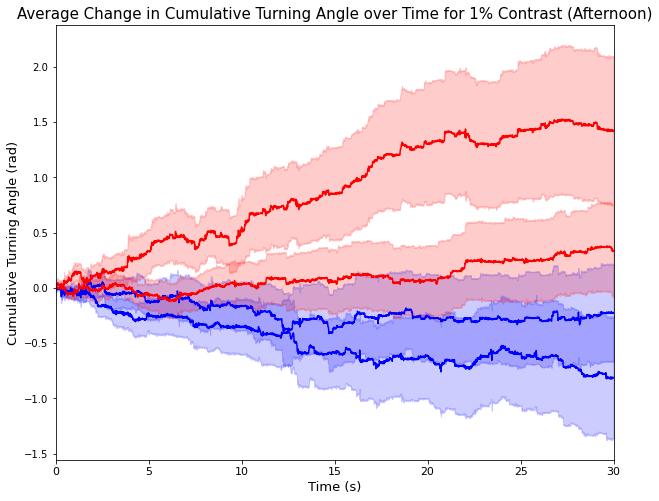

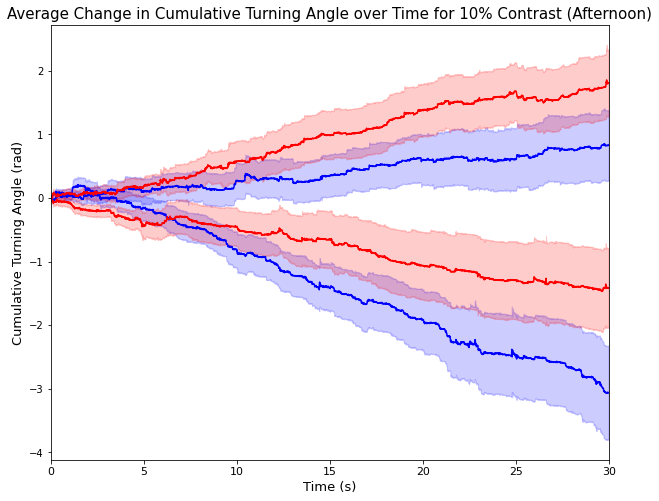

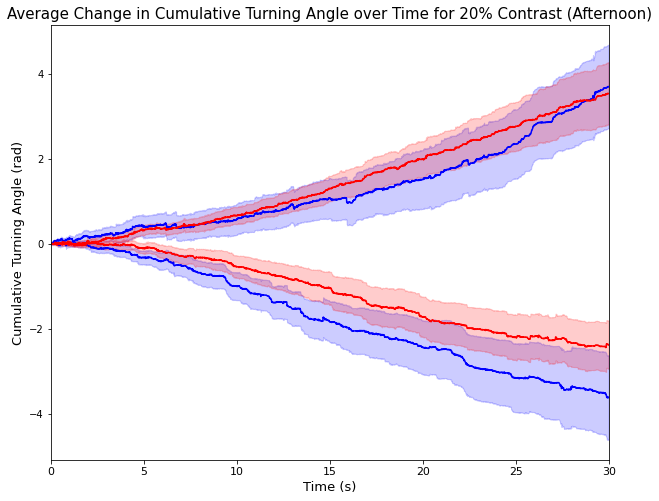

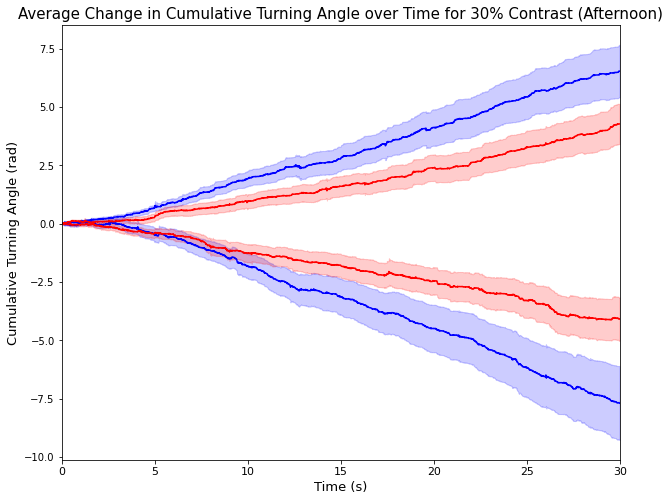

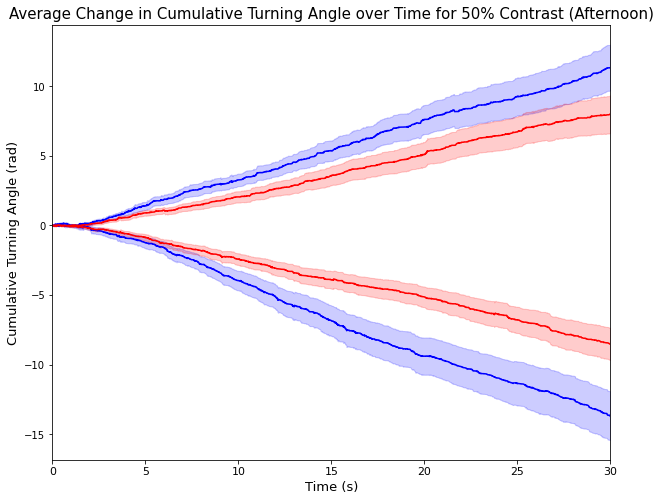

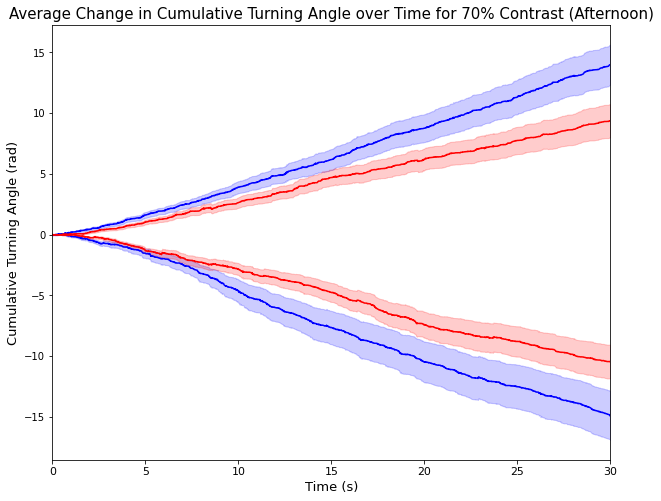

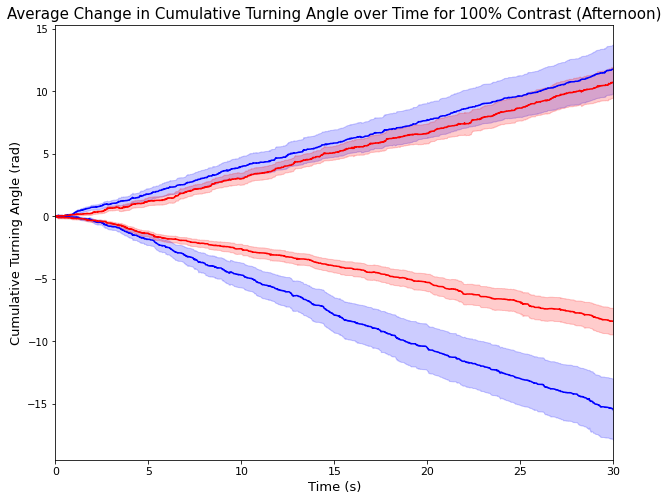

In [13]:
for c in ['1','10','20','30','50','70','100']:
    exec(f'avg_pm_LeC{c}_trajectory = np.mean(pm_comb_LeC{c}[:,:,4],axis=0)')
    exec(f'avg_pm_ReC{c}_trajectory = np.mean(pm_comb_ReC{c}[:,:,4],axis=0)')

    exec(f'avg_pm_LeC{c}_SEM = stats.sem(pm_comb_LeC{c}[:,:,4],axis=0)')
    exec(f'avg_pm_ReC{c}_SEM = stats.sem(pm_comb_ReC{c}[:,:,4],axis=0)')
    
    exec(f'avg_pm_LmeC{c}_trajectory = np.mean(pm_comb_LmeC{c}[:,:,4],axis=0)')
    exec(f'avg_pm_RmeC{c}_trajectory = np.mean(pm_comb_RmeC{c}[:,:,4],axis=0)')

    exec(f'avg_pm_LmeC{c}_SEM = stats.sem(pm_comb_LmeC{c}[:,:,4],axis=0)')
    exec(f'avg_pm_RmeC{c}_SEM = stats.sem(pm_comb_RmeC{c}[:,:,4],axis=0)')

    exec(f'fig, ax = plt.subplots(1,1,figsize=(10,8))')
    exec(f'plt.title("Average Change in Cumulative Turning Angle over Time for {c}% Contrast (Afternoon)",fontsize=15)')
    exec(f'ax.set_xlabel("Time (s)",fontsize=13)')
    exec(f'ax.set_ylabel("Cumulative Turning Angle (rad)",fontsize=13)')
    exec(f'ax.set_xlim(0,3000)')
    exec(f'x_ticks = [0, 500, 1000, 1500, 2000, 2500, 3000]')
    exec(f'x_labels = [0, 5, 10, 15, 20, 25, 30] ')
    exec(f'plt.xticks(x_ticks,x_labels,fontsize=11)')
    exec(f'ax.plot(avg_pm_LeC{c}_trajectory,c="b")')
    exec(f'ax.plot(avg_pm_ReC{c}_trajectory,c="b")')
    exec(f'ax.plot(avg_pm_LmeC{c}_trajectory,c="r")')
    exec(f'ax.plot(avg_pm_RmeC{c}_trajectory,c="r")')
    exec(f'ax.fill_between(range(0,3000), avg_pm_LeC{c}_trajectory-avg_pm_LeC{c}_SEM, avg_pm_LeC{c}_trajectory+\
            avg_pm_LeC{c}_SEM,color="b",alpha=0.2)')
    exec(f'ax.fill_between(range(0,3000), avg_pm_ReC{c}_trajectory-avg_pm_ReC{c}_SEM, avg_pm_ReC{c}_trajectory+\
            avg_pm_ReC{c}_SEM,color="b",alpha=0.2)')
    exec(f'ax.fill_between(range(0,3000), avg_pm_LmeC{c}_trajectory-avg_pm_LmeC{c}_SEM, avg_pm_LmeC{c}_trajectory+\
            avg_pm_LmeC{c}_SEM,color="r",alpha=0.2)')
    exec(f'ax.fill_between(range(0,3000), avg_pm_RmeC{c}_trajectory-avg_pm_RmeC{c}_SEM, avg_pm_RmeC{c}_trajectory+\
            avg_pm_RmeC{c}_SEM,color="r",alpha=0.2)')
    exec(f'plt.show()')

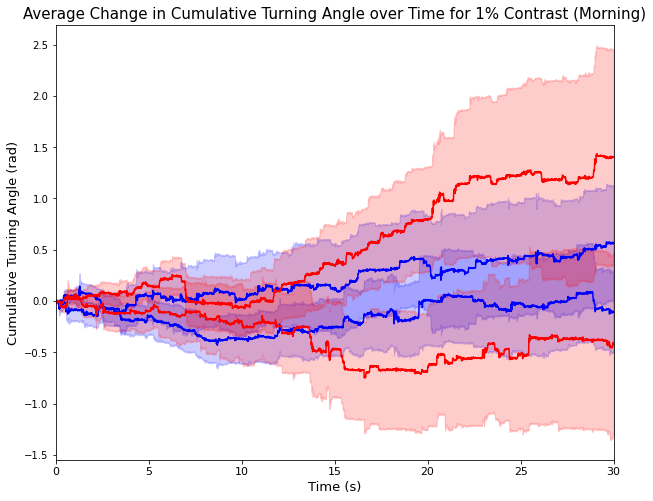

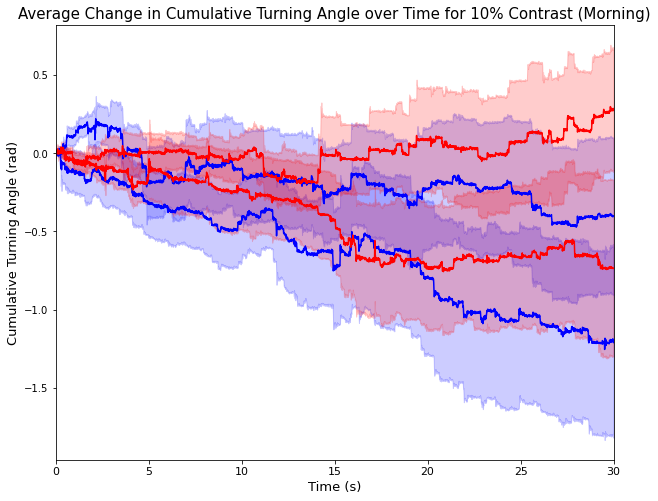

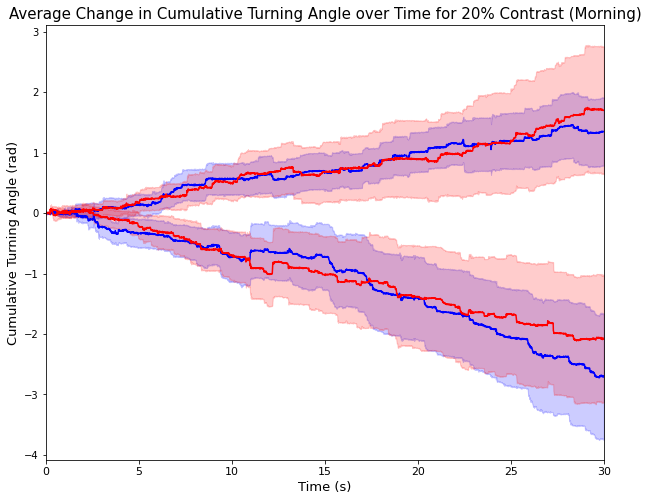

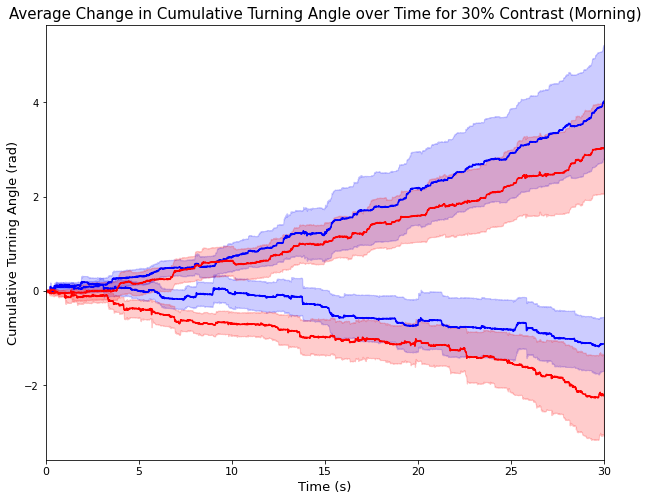

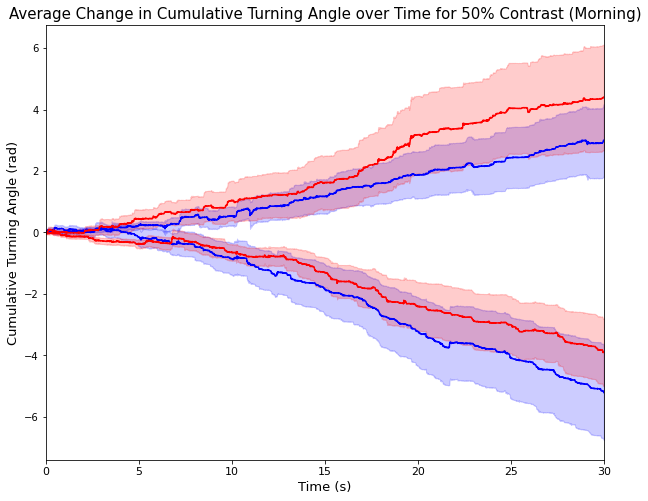

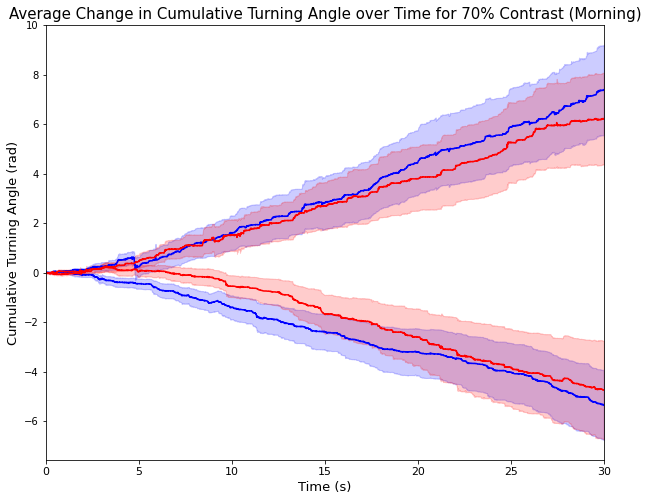

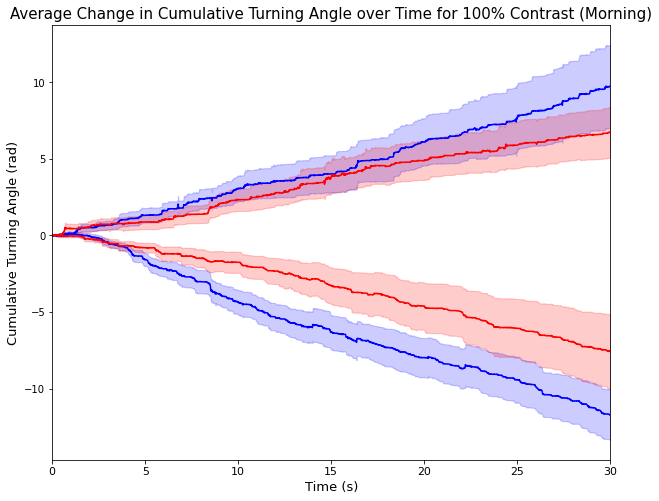

In [14]:
for c in ['1','10','20','30','50','70','100']:
    exec(f'avg_am_LeC{c}_trajectory = np.mean(am_comb_LeC{c}[:,:,4],axis=0)')
    exec(f'avg_am_ReC{c}_trajectory = np.mean(am_comb_ReC{c}[:,:,4],axis=0)')

    exec(f'avg_am_LeC{c}_SEM = stats.sem(am_comb_LeC{c}[:,:,4],axis=0)')
    exec(f'avg_am_ReC{c}_SEM = stats.sem(am_comb_ReC{c}[:,:,4],axis=0)')
    
    exec(f'avg_am_LmeC{c}_trajectory = np.mean(am_comb_LmeC{c}[:,:,4],axis=0)')
    exec(f'avg_am_RmeC{c}_trajectory = np.mean(am_comb_RmeC{c}[:,:,4],axis=0)')

    exec(f'avg_am_LmeC{c}_SEM = stats.sem(am_comb_LmeC{c}[:,:,4],axis=0)')
    exec(f'avg_am_RmeC{c}_SEM = stats.sem(am_comb_RmeC{c}[:,:,4],axis=0)')

    exec(f'fig, ax = plt.subplots(1,1,figsize=(10,8))')
    exec(f'plt.title("Average Change in Cumulative Turning Angle over Time for {c}% Contrast (Morning)",fontsize=15)')
    exec(f'ax.set_xlabel("Time (s)",fontsize=13)')
    exec(f'ax.set_ylabel("Cumulative Turning Angle (rad)",fontsize=13)')
    exec(f'ax.set_xlim(0,3000)')
    exec(f'x_ticks = [0, 500, 1000, 1500, 2000, 2500, 3000]')
    exec(f'x_labels = [0, 5, 10, 15, 20, 25, 30] ')
    exec(f'plt.xticks(x_ticks,x_labels,fontsize=11)')
    exec(f'ax.plot(avg_am_LeC{c}_trajectory,c="b")')
    exec(f'ax.plot(avg_am_ReC{c}_trajectory,c="b")')
    exec(f'ax.plot(avg_am_LmeC{c}_trajectory,c="r")')
    exec(f'ax.plot(avg_am_RmeC{c}_trajectory,c="r")')
    exec(f'ax.fill_between(range(0,3000), avg_am_LeC{c}_trajectory-avg_am_LeC{c}_SEM, avg_am_LeC{c}_trajectory+\
            avg_am_LeC{c}_SEM,color="b",alpha=0.2)')
    exec(f'ax.fill_between(range(0,3000), avg_am_ReC{c}_trajectory-avg_am_ReC{c}_SEM, avg_am_ReC{c}_trajectory+\
            avg_am_ReC{c}_SEM,color="b",alpha=0.2)')
    exec(f'ax.fill_between(range(0,3000), avg_am_LmeC{c}_trajectory-avg_am_LmeC{c}_SEM, avg_am_LmeC{c}_trajectory+\
            avg_am_LmeC{c}_SEM,color="r",alpha=0.2)')
    exec(f'ax.fill_between(range(0,3000), avg_am_RmeC{c}_trajectory-avg_am_RmeC{c}_SEM, avg_am_RmeC{c}_trajectory+\
            avg_am_RmeC{c}_SEM,color="r",alpha=0.2)')
    exec(f'plt.show()')

# Combining Left and Right Flows

In [15]:
pm_comb_ReC1[:,:,4] = abs(pm_comb_ReC1[:,:,4])
pm_comb_ReC10[:,:,4] = abs(pm_comb_ReC10[:,:,4])
pm_comb_ReC20[:,:,4] = abs(pm_comb_ReC20[:,:,4])
pm_comb_ReC30[:,:,4] = abs(pm_comb_ReC30[:,:,4])
pm_comb_ReC50[:,:,4] = abs(pm_comb_ReC50[:,:,4])
pm_comb_ReC70[:,:,4] = abs(pm_comb_ReC70[:,:,4])
pm_comb_ReC100[:,:,4] = abs(pm_comb_ReC100[:,:,4])

In [16]:
am_comb_ReC1[:,:,4] = abs(am_comb_ReC1[:,:,4])
am_comb_ReC10[:,:,4] = abs(am_comb_ReC10[:,:,4])
am_comb_ReC20[:,:,4] = abs(am_comb_ReC20[:,:,4])
am_comb_ReC30[:,:,4] = abs(am_comb_ReC30[:,:,4])
am_comb_ReC50[:,:,4] = abs(am_comb_ReC50[:,:,4])
am_comb_ReC70[:,:,4] = abs(am_comb_ReC70[:,:,4])
am_comb_ReC100[:,:,4] = abs(am_comb_ReC100[:,:,4])

In [17]:
pm_comb_RmeC1[:,:,4] = abs(pm_comb_RmeC1[:,:,4])
pm_comb_RmeC10[:,:,4] = abs(pm_comb_RmeC10[:,:,4])
pm_comb_RmeC20[:,:,4] = abs(pm_comb_RmeC20[:,:,4])
pm_comb_RmeC30[:,:,4] = abs(pm_comb_RmeC30[:,:,4])
pm_comb_RmeC50[:,:,4] = abs(pm_comb_RmeC50[:,:,4])
pm_comb_RmeC70[:,:,4] = abs(pm_comb_RmeC70[:,:,4])
pm_comb_RmeC100[:,:,4] = abs(pm_comb_RmeC100[:,:,4])

In [18]:
am_comb_RmeC1[:,:,4] = abs(am_comb_RmeC1[:,:,4])
am_comb_RmeC10[:,:,4] = abs(am_comb_RmeC10[:,:,4])
am_comb_RmeC20[:,:,4] = abs(am_comb_RmeC20[:,:,4])
am_comb_RmeC30[:,:,4] = abs(am_comb_RmeC30[:,:,4])
am_comb_RmeC50[:,:,4] = abs(am_comb_RmeC50[:,:,4])
am_comb_RmeC70[:,:,4] = abs(am_comb_RmeC70[:,:,4])
am_comb_RmeC100[:,:,4] = abs(am_comb_RmeC100[:,:,4])

In [19]:
pm_eC1 = np.vstack((pm_comb_LeC1,pm_comb_ReC1))
pm_eC10 = np.vstack((pm_comb_LeC10,pm_comb_ReC10))
pm_eC20 = np.vstack((pm_comb_LeC20,pm_comb_ReC20))
pm_eC30 = np.vstack((pm_comb_LeC30,pm_comb_ReC30))
pm_eC50 = np.vstack((pm_comb_LeC50,pm_comb_ReC50))
pm_eC70 = np.vstack((pm_comb_LeC70,pm_comb_ReC70))
pm_eC100 = np.vstack((pm_comb_LeC100,pm_comb_ReC100))

In [20]:
am_eC1 = np.vstack((am_comb_LeC1,am_comb_ReC1))
am_eC10 = np.vstack((am_comb_LeC10,am_comb_ReC10))
am_eC20 = np.vstack((am_comb_LeC20,am_comb_ReC20))
am_eC30 = np.vstack((am_comb_LeC30,am_comb_ReC30))
am_eC50 = np.vstack((am_comb_LeC50,am_comb_ReC50))
am_eC70 = np.vstack((am_comb_LeC70,am_comb_ReC70))
am_eC100 = np.vstack((am_comb_LeC100,am_comb_ReC100))

In [21]:
pm_meC1 = np.vstack((pm_comb_LmeC1,pm_comb_RmeC1))
pm_meC10 = np.vstack((pm_comb_LmeC10,pm_comb_RmeC10))
pm_meC20 = np.vstack((pm_comb_LmeC20,pm_comb_RmeC20))
pm_meC30 = np.vstack((pm_comb_LmeC30,pm_comb_RmeC30))
pm_meC50 = np.vstack((pm_comb_LmeC50,pm_comb_RmeC50))
pm_meC70 = np.vstack((pm_comb_LmeC70,pm_comb_RmeC70))
pm_meC100 = np.vstack((pm_comb_LmeC100,pm_comb_RmeC100))

In [22]:
am_meC1 = np.vstack((am_comb_LmeC1,am_comb_RmeC1))
am_meC10 = np.vstack((am_comb_LmeC10,am_comb_RmeC10))
am_meC20 = np.vstack((am_comb_LmeC20,am_comb_RmeC20))
am_meC30 = np.vstack((am_comb_LmeC30,am_comb_RmeC30))
am_meC50 = np.vstack((am_comb_LmeC50,am_comb_RmeC50))
am_meC70 = np.vstack((am_comb_LmeC70,am_comb_RmeC70))
am_meC100 = np.vstack((am_comb_LmeC100,am_comb_RmeC100))

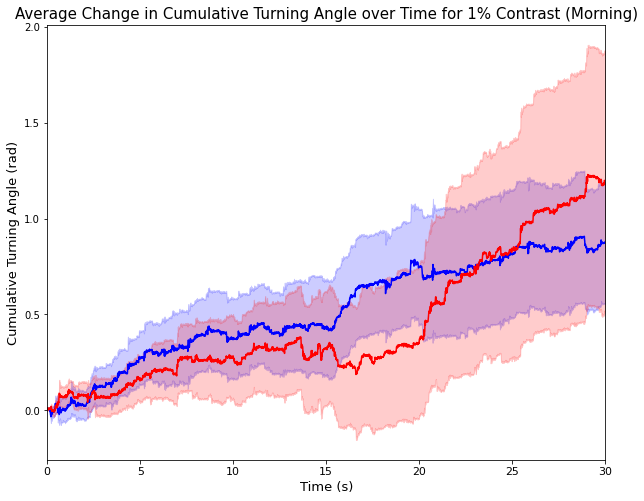

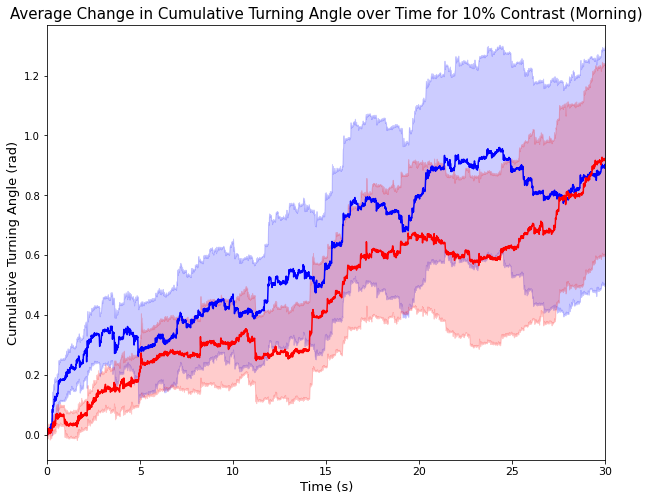

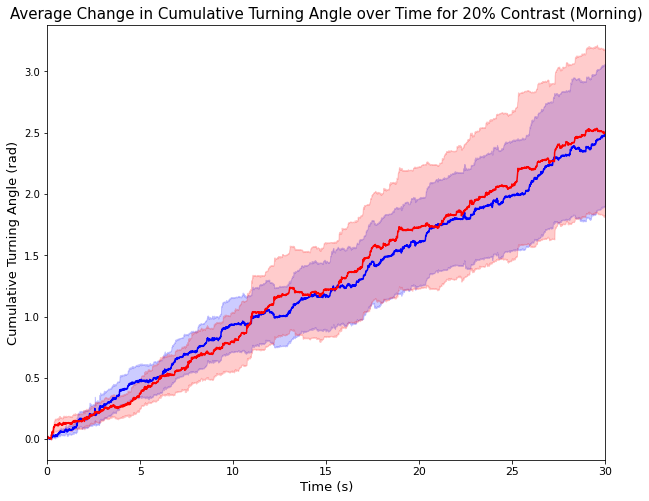

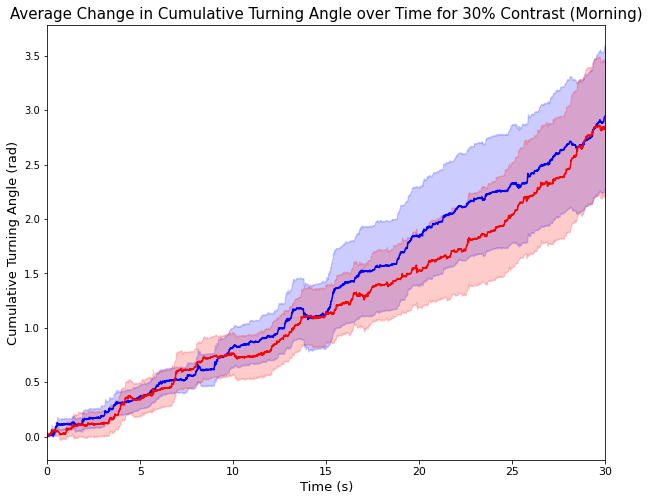

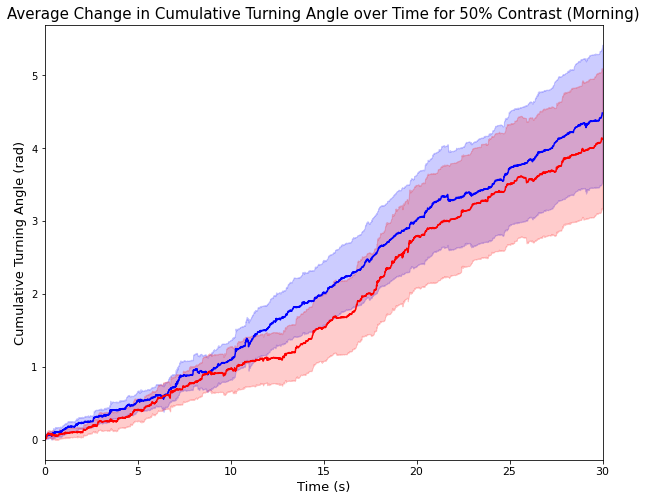

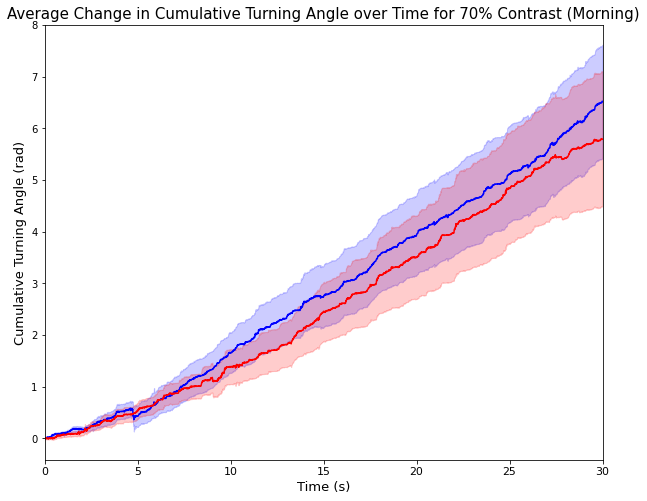

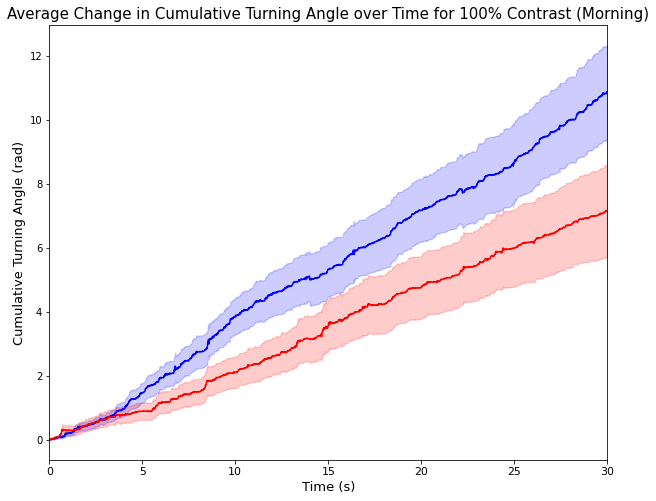

In [23]:
for c in ['1','10','20','30','50','70','100']:
    exec(f'avg_am_eC{c}_trajectory = np.mean(am_eC{c}[:,:,4],axis=0)')
#     exec(f'avg_am_eC{c}_trajectory = np.mean(am_comb_ReC{c}[:,:,4],axis=0)')

    exec(f'avg_am_eC{c}_SEM = stats.sem(am_eC{c}[:,:,4],axis=0)')
#     exec(f'avg_am_eC{c}_SEM = stats.sem(am_comb_ReC{c}[:,:,4],axis=0)')
    
    exec(f'avg_am_meC{c}_trajectory = np.mean(am_meC{c}[:,:,4],axis=0)')
#     exec(f'avg_am_meC{c}_trajectory = np.mean(am_comb_RmeC{c}[:,:,4],axis=0)')

    exec(f'avg_am_meC{c}_SEM = stats.sem(am_meC{c}[:,:,4],axis=0)')
#     exec(f'avg_am_meC{c}_SEM = stats.sem(am_comb_RmeC{c}[:,:,4],axis=0)')

    exec(f'fig, ax = plt.subplots(1,1,figsize=(10,8))')
    exec(f'plt.title("Average Change in Cumulative Turning Angle over Time for {c}% Contrast (Morning)",fontsize=15)')
    exec(f'ax.set_xlabel("Time (s)",fontsize=13)')
    exec(f'ax.set_ylabel("Cumulative Turning Angle (rad)",fontsize=13)')
    exec(f'ax.set_xlim(0,3000)')
    exec(f'x_ticks = [0, 500, 1000, 1500, 2000, 2500, 3000]')
    exec(f'x_labels = [0, 5, 10, 15, 20, 25, 30] ')
    exec(f'plt.xticks(x_ticks,x_labels,fontsize=11)')
    exec(f'ax.plot(avg_am_eC{c}_trajectory,c="b")')
    exec(f'ax.plot(avg_am_meC{c}_trajectory,c="r")')
#     exec(f'ax.plot(avg_am_LmeC{c}_trajectory,c="g")')
#     exec(f'ax.plot(avg_am_RmeC{c}_trajectory,c="k")')
    exec(f'ax.fill_between(range(0,3000), avg_am_eC{c}_trajectory-avg_am_eC{c}_SEM, avg_am_eC{c}_trajectory+\
            avg_am_eC{c}_SEM,color="b",alpha=0.2)')
    exec(f'ax.fill_between(range(0,3000), avg_am_meC{c}_trajectory-avg_am_meC{c}_SEM, avg_am_meC{c}_trajectory+\
            avg_am_meC{c}_SEM,color="r",alpha=0.2)')
#     exec(f'ax.fill_between(range(0,3000), avg_am_LmeC{c}_trajectory-avg_am_LmeC{c}_SEM, avg_am_LmeC{c}_trajectory+\
#             avg_am_LmeC{c}_SEM,color="g",alpha=0.2)')
#     exec(f'ax.fill_between(range(0,3000), avg_am_RmeC{c}_trajectory-avg_am_RmeC{c}_SEM, avg_am_RmeC{c}_trajectory+\
#             avg_am_RmeC{c}_SEM,color="grey",alpha=0.2)')
    exec(f'plt.show()')

# Saving Stacked Data as csv

In [124]:
# pd.DataFrame(pm_eC1.copy().reshape(pm_eC1.shape[0]*pm_eC1.shape[1],-1)).to_csv('../raw_data/pm_eC1.csv')
# pd.DataFrame(pm_eC10.copy().reshape(pm_eC10.shape[0]*pm_eC10.shape[1],-1)).to_csv('../raw_data/pm_eC10.csv')
# pd.DataFrame(pm_eC20.copy().reshape(pm_eC20.shape[0]*pm_eC20.shape[1],-1)).to_csv('../raw_data/pm_eC20.csv')
# pd.DataFrame(pm_eC30.copy().reshape(pm_eC30.shape[0]*pm_eC30.shape[1],-1)).to_csv('../raw_data/pm_eC30.csv')
# pd.DataFrame(pm_eC50.copy().reshape(pm_eC50.shape[0]*pm_eC50.shape[1],-1)).to_csv('../raw_data/pm_eC50.csv')
# pd.DataFrame(pm_eC70.copy().reshape(pm_eC70.shape[0]*pm_eC70.shape[1],-1)).to_csv('../raw_data/pm_eC70.csv')
# pd.DataFrame(pm_eC100.copy().reshape(pm_eC100.shape[0]*pm_eC100.shape[1],-1)).to_csv('../raw_data/pm_eC100.csv')

In [125]:
# pd.DataFrame(pm_meC1.copy().reshape(pm_meC1.shape[0]*pm_meC1.shape[1],-1)).to_csv('../raw_data/pm_meC1.csv')
# pd.DataFrame(pm_meC10.copy().reshape(pm_meC10.shape[0]*pm_meC10.shape[1],-1)).to_csv('../raw_data/pm_meC10.csv')
# pd.DataFrame(pm_meC20.copy().reshape(pm_meC20.shape[0]*pm_meC20.shape[1],-1)).to_csv('../raw_data/pm_meC20.csv')
# pd.DataFrame(pm_meC30.copy().reshape(pm_meC30.shape[0]*pm_meC30.shape[1],-1)).to_csv('../raw_data/pm_meC30.csv')
# pd.DataFrame(pm_meC50.copy().reshape(pm_meC50.shape[0]*pm_meC50.shape[1],-1)).to_csv('../raw_data/pm_meC50.csv')
# pd.DataFrame(pm_meC70.copy().reshape(pm_meC70.shape[0]*pm_meC70.shape[1],-1)).to_csv('../raw_data/pm_meC70.csv')
# pd.DataFrame(pm_meC100.copy().reshape(pm_meC100.shape[0]*pm_meC100.shape[1],-1)).to_csv('../raw_data/pm_meC100.csv')

In [126]:
# pd.DataFrame(am_eC1.copy().reshape(am_eC1.shape[0]*am_eC1.shape[1],-1)).to_csv('../raw_data/am_eC1.csv')
# pd.DataFrame(am_eC10.copy().reshape(am_eC10.shape[0]*am_eC10.shape[1],-1)).to_csv('../raw_data/am_eC10.csv')
# pd.DataFrame(am_eC20.copy().reshape(am_eC20.shape[0]*am_eC20.shape[1],-1)).to_csv('../raw_data/am_eC20.csv')
# pd.DataFrame(am_eC30.copy().reshape(am_eC30.shape[0]*am_eC30.shape[1],-1)).to_csv('../raw_data/am_eC30.csv')
# pd.DataFrame(am_eC50.copy().reshape(am_eC50.shape[0]*am_eC50.shape[1],-1)).to_csv('../raw_data/am_eC50.csv')
# pd.DataFrame(am_eC70.copy().reshape(am_eC70.shape[0]*am_eC70.shape[1],-1)).to_csv('../raw_data/am_eC70.csv')
# pd.DataFrame(am_eC100.copy().reshape(am_eC100.shape[0]*am_eC100.shape[1],-1)).to_csv('../raw_data/am_eC100.csv')

In [127]:
# pd.DataFrame(am_meC1.copy().reshape(am_meC1.shape[0]*am_meC1.shape[1],-1)).to_csv('../raw_data/am_meC1.csv')
# pd.DataFrame(am_meC10.copy().reshape(am_meC10.shape[0]*am_meC10.shape[1],-1)).to_csv('../raw_data/am_meC10.csv')
# pd.DataFrame(am_meC20.copy().reshape(am_meC20.shape[0]*am_meC20.shape[1],-1)).to_csv('../raw_data/am_meC20.csv')
# pd.DataFrame(am_meC30.copy().reshape(am_meC30.shape[0]*am_meC30.shape[1],-1)).to_csv('../raw_data/am_meC30.csv')
# pd.DataFrame(am_meC50.copy().reshape(am_meC50.shape[0]*am_meC50.shape[1],-1)).to_csv('../raw_data/am_meC50.csv')
# pd.DataFrame(am_meC70.copy().reshape(am_meC70.shape[0]*am_meC70.shape[1],-1)).to_csv('../raw_data/am_meC70.csv')
# pd.DataFrame(am_meC100.copy().reshape(am_meC100.shape[0]*am_meC100.shape[1],-1)).to_csv('../raw_data/am_meC100.csv')

# Calculation of Mean and SEM of Cumulative Angles

In [28]:
pm_eC1_cum = pm_eC1[:,-1,4]
pm_eC10_cum = pm_eC10[:,-1,4]
pm_eC20_cum = pm_eC20[:,-1,4]
pm_eC30_cum = pm_eC30[:,-1,4]
pm_eC50_cum = pm_eC50[:,-1,4]
pm_eC70_cum = pm_eC70[:,-1,4]
pm_eC100_cum = pm_eC100[:,-1,4]

In [29]:
am_eC1_cum = am_eC1[:,-1,4]
am_eC10_cum = am_eC10[:,-1,4]
am_eC20_cum = am_eC20[:,-1,4]
am_eC30_cum = am_eC30[:,-1,4]
am_eC50_cum = am_eC50[:,-1,4]
am_eC70_cum = am_eC70[:,-1,4]
am_eC100_cum = am_eC100[:,-1,4]

In [30]:
pm_meC1_cum = pm_meC1[:,-1,4]
pm_meC10_cum = pm_meC10[:,-1,4]
pm_meC20_cum = pm_meC20[:,-1,4]
pm_meC30_cum = pm_meC30[:,-1,4]
pm_meC50_cum = pm_meC50[:,-1,4]
pm_meC70_cum = pm_meC70[:,-1,4]
pm_meC100_cum = pm_meC100[:,-1,4]

In [31]:
am_meC1_cum = am_meC1[:,-1,4]
am_meC10_cum = am_meC10[:,-1,4]
am_meC20_cum = am_meC20[:,-1,4]
am_meC30_cum = am_meC30[:,-1,4]
am_meC50_cum = am_meC50[:,-1,4]
am_meC70_cum = am_meC70[:,-1,4]
am_meC100_cum = am_meC100[:,-1,4]

In [32]:
pm_eC1_sem = stats.sem(pm_eC1[:,-1,4])
pm_eC10_sem = stats.sem(pm_eC10[:,-1,4])
pm_eC20_sem = stats.sem(pm_eC20[:,-1,4])
pm_eC30_sem = stats.sem(pm_eC30[:,-1,4])
pm_eC50_sem = stats.sem(pm_eC50[:,-1,4])
pm_eC70_sem = stats.sem(pm_eC70[:,-1,4])
pm_eC100_sem = stats.sem(pm_eC100[:,-1,4])

In [33]:
am_eC1_sem = stats.sem(am_eC1[:,-1,4])
am_eC10_sem = stats.sem(am_eC10[:,-1,4])
am_eC20_sem = stats.sem(am_eC20[:,-1,4])
am_eC30_sem = stats.sem(am_eC30[:,-1,4])
am_eC50_sem = stats.sem(am_eC50[:,-1,4])
am_eC70_sem = stats.sem(am_eC70[:,-1,4])
am_eC100_sem = stats.sem(am_eC100[:,-1,4])

In [34]:
pm_meC1_sem = stats.sem(pm_meC1[:,-1,4])
pm_meC10_sem = stats.sem(pm_meC10[:,-1,4])
pm_meC20_sem = stats.sem(pm_meC20[:,-1,4])
pm_meC30_sem = stats.sem(pm_meC30[:,-1,4])
pm_meC50_sem = stats.sem(pm_meC50[:,-1,4])
pm_meC70_sem = stats.sem(pm_meC70[:,-1,4])
pm_meC100_sem = stats.sem(pm_meC100[:,-1,4])

In [35]:
am_meC1_sem = stats.sem(am_meC1[:,-1,4])
am_meC10_sem = stats.sem(am_meC10[:,-1,4])
am_meC20_sem = stats.sem(am_meC20[:,-1,4])
am_meC30_sem = stats.sem(am_meC30[:,-1,4])
am_meC50_sem = stats.sem(am_meC50[:,-1,4])
am_meC70_sem = stats.sem(am_meC70[:,-1,4])
am_meC100_sem = stats.sem(am_meC100[:,-1,4])

In [36]:
x = [1,10,20,30,50,70,100]
pm_e_yerr = [pm_eC1_sem,pm_eC10_sem,pm_eC20_sem,pm_eC30_sem,pm_eC50_sem,pm_eC70_sem,pm_eC100_sem]
pm_me_yerr = [pm_meC1_sem,pm_meC10_sem,pm_meC20_sem,pm_meC30_sem,pm_meC50_sem,pm_meC70_sem,pm_meC100_sem]
am_e_yerr = [am_eC1_sem,am_eC10_sem,am_eC20_sem,am_eC30_sem,am_eC50_sem,am_eC70_sem,am_eC100_sem]
am_me_yerr = [am_meC1_sem,am_meC10_sem,am_meC20_sem,am_meC30_sem,am_meC50_sem,am_meC70_sem,am_meC100_sem]

pm_e_cum = [np.mean(pm_eC1_cum),np.mean(pm_eC10_cum),np.mean(pm_eC20_cum),np.mean(pm_eC30_cum),\
                                 np.mean(pm_eC50_cum),np.mean(pm_eC70_cum),np.mean(pm_eC100_cum)]
pm_me_cum = [np.mean(pm_meC1_cum),np.mean(pm_meC10_cum),np.mean(pm_meC20_cum),np.mean(pm_meC30_cum),\
                                 np.mean(pm_meC50_cum),np.mean(pm_meC70_cum),np.mean(pm_meC100_cum)]

am_e_cum = [np.mean(am_eC1_cum),np.mean(am_eC10_cum),np.mean(am_eC20_cum),np.mean(am_eC30_cum),\
                                 np.mean(am_eC50_cum),np.mean(am_eC70_cum),np.mean(am_eC100_cum)]
am_me_cum = [np.mean(am_meC1_cum),np.mean(am_meC10_cum),np.mean(am_meC20_cum),np.mean(am_meC30_cum),\
                                 np.mean(am_meC50_cum),np.mean(am_meC70_cum),np.mean(am_meC100_cum)]

# Fitting Sigmoid Curve

/var/folders/wd/4w68b8ld47x6kzpx1zhzn8qm0000gn/T/ipykernel_67266/2780036809.py:2: RuntimeWarning: overflow encountered in exp
  y = L / (1 + np.exp(-k*(x-x0)))+b


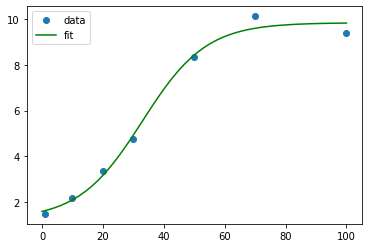

In [37]:
def sigmoid(x, L ,x0, k, b):
    y = L / (1 + np.exp(-k*(x-x0)))+b
    return (y)

xdata = [1,10,20,30,50,70,100]
ydata = pm_me_cum

p0 = [max(ydata), np.median(xdata),1,min(ydata)] # this is an mandatory initial guess

popt, pcov = curve_fit(sigmoid, xdata, ydata,p0, method='dogbox')

y = sigmoid(xdata, *popt)
new_x = np.linspace(0,100,50)
new_y = sigmoid(new_x, *popt)
plt.plot(xdata, ydata, 'o', label='data')
plt.plot(new_x,new_y,'g-',label='fit')
plt.legend()

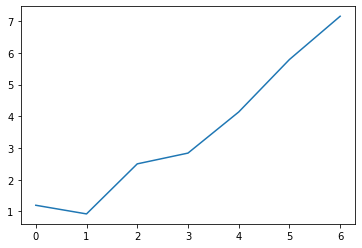

In [38]:
plt.plot(am_me_cum)

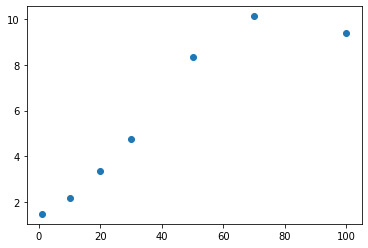

In [39]:
plt.plot(xdata,ydata,'o')

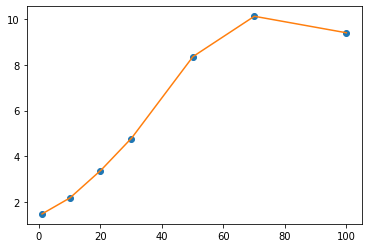

In [40]:
x = [1,10,20,30,50,70,100]
y = pm_me_cum
f = interpolate.interp1d(x, y)
xnew = np.arange(1, 100, 0.01)
ynew = f(xnew)   # use interpolation function returned by `interp1d`
plt.plot(x, y, 'o', xnew, ynew, '-')
plt.show()

In [202]:
def sigmoid(x, L ,x0, k, b):
    y = L / (1 + np.exp(-k*(x-x0)))+b
    return (y)

# xdata = [1,10,20,30,50,70,100]
# ydata = pm_me_cum

def fit_sigmoid(ydata):
    xdata = [1,10,20,30,50,70,100]
    p0 = [max(ydata), np.median(xdata),1,min(ydata)] # this is an mandatory initial guess
    popt, pcov = curve_fit(sigmoid, xdata, ydata,p0, method='dogbox')
    y = sigmoid(xdata, *popt)
    new_x = np.linspace(0,100,50)
    new_y = sigmoid(new_x, *popt)
    return new_y

In [203]:
pm_e_cum_fit = fit_sigmoid(pm_e_cum)
pm_me_cum_fit = fit_sigmoid(pm_me_cum)

# am_e_cum_fit = fit_sigmoid(am_e_cum)
am_me_cum_fit = fit_sigmoid(am_me_cum)

/var/folders/wd/4w68b8ld47x6kzpx1zhzn8qm0000gn/T/ipykernel_67266/594421320.py:2: RuntimeWarning: overflow encountered in exp
  y = L / (1 + np.exp(-k*(x-x0)))+b


# Contrast Response Plot

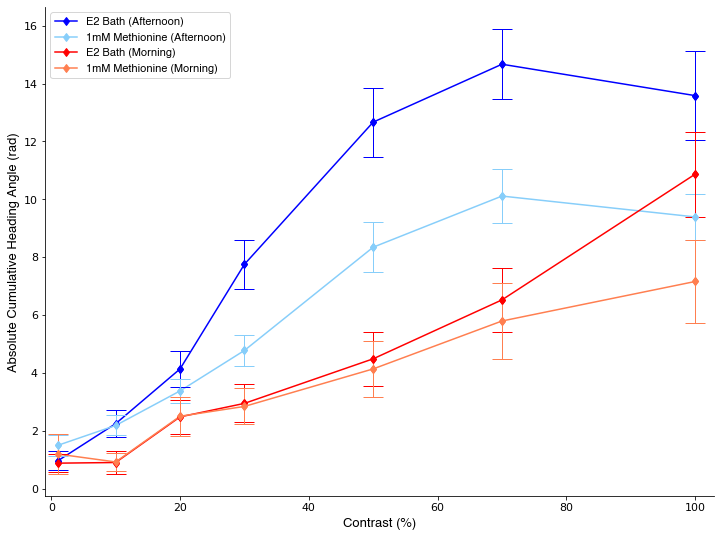

In [205]:
fig, ax = plt.subplots(1,1,figsize=(12,9))
x=[1,10,20,30,50,70,100]
ax.plot(x,pm_e_cum,c='b',marker='d',mfc='b',label='E2 Bath (Afternoon)')
# ax.plot(np.linspace(0,100,50),pm_e_cum_fit,'--b',label='Fitted E2 Bath (Afternoon)')
ax.plot(x,pm_me_cum,c='lightskyblue',marker='d',mfc='lightskyblue',label='1mM Methionine (Afternoon)')
# ax.plot(np.linspace(0,100,50),pm_me_cum_fit,c='lightskyblue',ls='--',label='Fitted 1mM Methionine (Afternoon)')
ax.errorbar(x,pm_e_cum,yerr=pm_e_yerr,fmt='d',color='b',capsize=10,elinewidth=1)
ax.errorbar(x,pm_me_cum,yerr=pm_me_yerr,fmt='d',color='lightskyblue',capsize=10,elinewidth=1)


ax.plot(x,am_e_cum,c='r',marker='d',mfc='r',label='E2 Bath (Morning)')
# ax.plot(np.linspace(0,100,50),am_e_cum_fit,'--r',label='Fitted E2 Bath (Morning)')
ax.plot(x,am_me_cum,c='coral',marker='d',mfc='coral',label='1mM Methionine (Morning)')
# ax.plot(np.linspace(0,100,50),am_me_cum_fit,c='coral',ls='--',label='Fitted 1mM Methionine (Morning)')
ax.errorbar(x,am_e_cum,yerr=am_e_yerr,fmt='d',color='r',capsize=10,elinewidth=1)
ax.errorbar(x,am_me_cum,yerr=am_me_yerr,fmt='d',color='coral',capsize=10,elinewidth=1)


font = font_manager.FontProperties(family='Helvetica',
                                   style='normal', size=11)
plt.legend(loc='upper left',prop=font)
plt.title('')
plt.xlabel('Contrast (%)',size=13,name='Helvetica')
plt.ylabel('Absolute Cumulative Heading Angle (rad)',size=13,name='Helvetica')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# plt.grid(which='major',axis='y')
# x_ticks = [1, 10, 20, 30, 50, 70, 100]
# x_labels = [1, 10, 20, 30, 50, 70, 100] 
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
# ax.set_ylim(0,15)
ax.set_xlim(-1,103)
plt.savefig('../../Dissertation/contrast_function_no_fit.png',dpi=400,bbox_inches='tight')
plt.show()

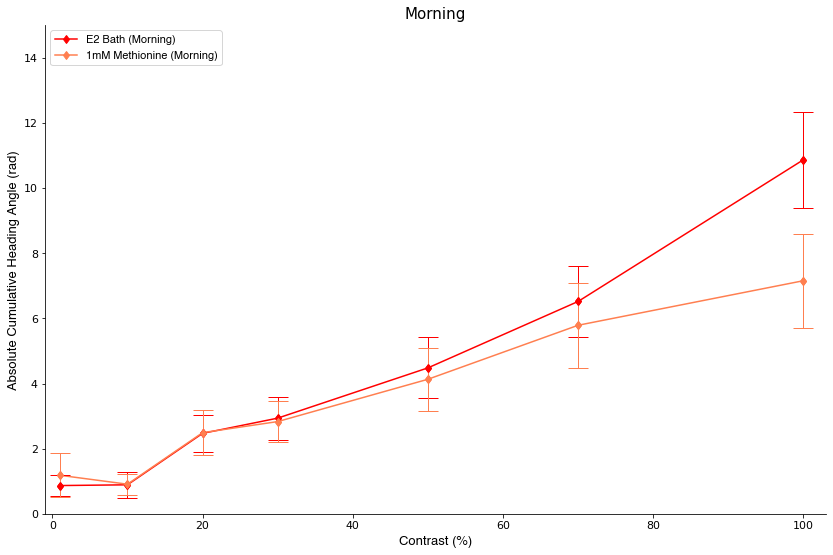

In [46]:
fig, ax = plt.subplots(1,1,figsize=(14,9))

ax.plot(x,am_e_cum,c='r',marker='d',mfc='r',label='E2 Bath (Morning)')
# ax.plot(np.linspace(0,100,50),am_e_cum_fit,'--r',label='Fitted E2 Bath (Morning)')
ax.plot(x,am_me_cum,c='coral',marker='d',mfc='coral',label='1mM Methionine (Morning)')
# ax.plot(np.linspace(0,100,50),am_me_cum_fit,c='coral',ls='--',label='Fitted 1mM Methionine (Morning)')
ax.errorbar(x,am_e_cum,yerr=am_e_yerr,fmt='d',color='r',capsize=10,elinewidth=1)
ax.errorbar(x,am_me_cum,yerr=am_me_yerr,fmt='d',color='coral',capsize=10,elinewidth=1)


font = font_manager.FontProperties(family='Helvetica',
                                   style='normal', size=11)
plt.legend(loc='upper left',prop=font)
plt.title('Morning',size=15)
plt.xlabel('Contrast (%)',size=13,name='Helvetica')
plt.ylabel('Absolute Cumulative Heading Angle (rad)',size=13,name='Helvetica')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
ax.set_ylim(0,15)
ax.set_xlim(-1,103)
# plt.savefig('../../Dissertation/contrast_function_AM.png',dpi=400,bbox_inches='tight')
plt.show()

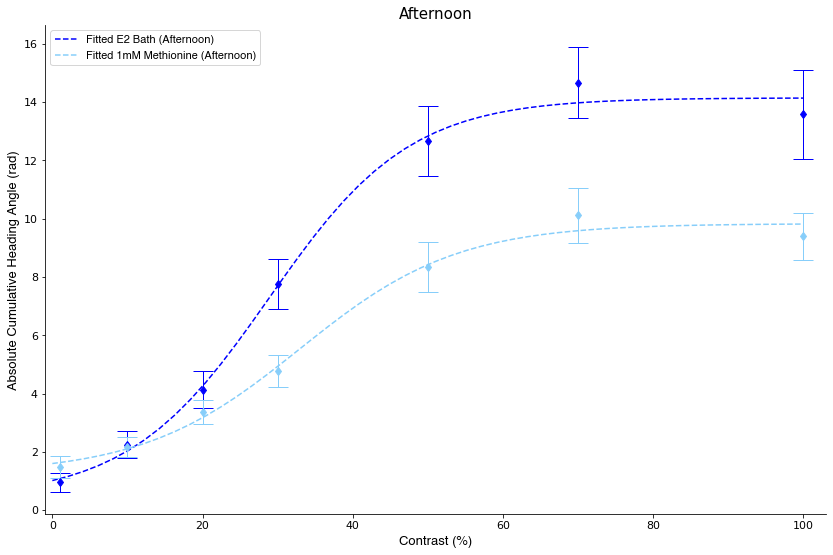

In [47]:
fig, ax = plt.subplots(1,1,figsize=(14,9))

# ax.plot(x,pm_e_cum,c='b',marker='d',mfc='b',label='E2 Bath (Afternoon)')
ax.plot(np.linspace(0,100,50),pm_e_cum_fit,'--b',label='Fitted E2 Bath (Afternoon)')
# ax.plot(x,pm_me_cum,c='lightskyblue',marker='d',mfc='lightskyblue',label='1mM Methionine (Afternoon)')
ax.plot(np.linspace(0,100,50),pm_me_cum_fit,c='lightskyblue',ls='--',label='Fitted 1mM Methionine (Afternoon)')
ax.errorbar(x,pm_e_cum,yerr=pm_e_yerr,fmt='d',color='b',capsize=10,elinewidth=1)
ax.errorbar(x,pm_me_cum,yerr=pm_me_yerr,fmt='d',color='lightskyblue',capsize=10,elinewidth=1)

font = font_manager.FontProperties(family='Helvetica',
                                   style='normal', size=11)
plt.legend(loc='upper left',prop=font)
plt.title('Afternoon',size=15)
plt.xlabel('Contrast (%)',size=13,name='Helvetica')
plt.ylabel('Absolute Cumulative Heading Angle (rad)',size=13,name='Helvetica')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
# ax.set_ylim(0,15)
ax.set_xlim(-1,103)
# plt.savefig('../../Dissertation/contrast_function_PM.png',dpi=400,bbox_inches='tight')
plt.show()

# ANOVA DataFrames for Cumulative Angles

In [48]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [49]:
for m in ['e','me']:
    for t in ['pm','am']:
        for c in ['1','10','20','30','50','70','100']:
            exec(f"anova_df_{m}_{t}_{c} = pd.DataFrame(columns=['medium','time','contrast','final_cum_angle'])")
            exec(f"anova_df_{m}_{t}_{c}['final_cum_angle'] = {t}_{m}C{c}_cum")
            exec(f"anova_df_{m}_{t}_{c}['medium'] = '{m}'")
            exec(f"anova_df_{m}_{t}_{c}['time'] = '{t}'")
            exec(f"anova_df_{m}_{t}_{c}['contrast'] = {c}")

In [50]:
anova_df = pd.DataFrame(columns=['medium','time','contrast','final_cum_angle'])
anova_df = pd.concat([anova_df_e_am_1,anova_df_e_am_10,anova_df_e_am_20,anova_df_e_am_30,anova_df_e_am_50,\
                    anova_df_e_am_70,anova_df_e_am_100,\
                    anova_df_e_pm_1,anova_df_e_pm_10,anova_df_e_pm_20,anova_df_e_pm_30,anova_df_e_pm_50,\
                    anova_df_e_pm_70,anova_df_e_pm_100,\
                    anova_df_me_am_1,anova_df_me_am_10,anova_df_me_am_20,anova_df_me_am_30,anova_df_me_am_50,\
                    anova_df_me_am_70,anova_df_me_am_100,\
                    anova_df_me_pm_1,anova_df_me_pm_10,anova_df_me_pm_20,anova_df_me_pm_30,anova_df_me_pm_50,\
                    anova_df_me_pm_70,anova_df_me_pm_100])

In [51]:
anova_df_am = anova_df[anova_df['time']=='am']
anova_df_pm = anova_df[anova_df['time']=='pm']

In [52]:
# anova_df.to_csv('../raw_data/anova_df.csv')

In [53]:
anova_df = anova_df.reset_index()
anova_df = anova_df.drop(columns='index')

# Levene Test and Welch ANOVA for Cumulative Angles

In [54]:
stats.levene(anova_df_e_am_1['final_cum_angle'],anova_df_e_am_10['final_cum_angle'],\
             anova_df_e_am_20['final_cum_angle'],anova_df_e_am_30['final_cum_angle'],\
             anova_df_e_am_50['final_cum_angle'],anova_df_e_am_70['final_cum_angle'],\
             anova_df_e_am_100['final_cum_angle'],anova_df_e_pm_1['final_cum_angle'],\
             anova_df_e_pm_10['final_cum_angle'],anova_df_e_pm_20['final_cum_angle'],\
             anova_df_e_pm_30['final_cum_angle'],anova_df_e_pm_50['final_cum_angle'],\
             anova_df_e_pm_70['final_cum_angle'],anova_df_e_pm_100['final_cum_angle'],\
             anova_df_me_am_1['final_cum_angle'],anova_df_me_am_10['final_cum_angle'],\
             anova_df_me_am_20['final_cum_angle'],anova_df_me_am_30['final_cum_angle'],\
             anova_df_me_am_50['final_cum_angle'],anova_df_me_am_70['final_cum_angle'],\
             anova_df_me_am_100['final_cum_angle'],anova_df_me_pm_1['final_cum_angle'],\
             anova_df_me_pm_10['final_cum_angle'],anova_df_me_pm_20['final_cum_angle'],\
             anova_df_me_pm_30['final_cum_angle'],anova_df_me_pm_50['final_cum_angle'],\
             anova_df_me_pm_70['final_cum_angle'],anova_df_me_pm_100['final_cum_angle'])

LeveneResult(statistic=13.544996294563607, pvalue=2.3848359953000644e-52)

In [55]:
# stats.alexandergovern()

In [56]:
# stats.kruskal()

In [57]:
pg.welch_anova(data=anova_df,dv='final_cum_angle',between='time')

,Source,ddof1,ddof2,F,p-unc,np2
0,time,1,1200.961376,73.943182,2.471972e-17,0.050342


In [58]:
pg.welch_anova(data=anova_df_am,dv='final_cum_angle',between='medium')

,Source,ddof1,ddof2,F,p-unc,np2
0,medium,1,475.363743,0.757011,0.384705,0.001579


In [59]:
pg.welch_anova(data=anova_df_pm,dv='final_cum_angle',between='medium')

,Source,ddof1,ddof2,F,p-unc,np2
0,medium,1,618.638019,16.285053,0.000061,0.02217


In [60]:
pg.welch_anova(data=anova_df_am,dv='final_cum_angle',between='contrast')

,Source,ddof1,ddof2,F,p-unc,np2
0,contrast,6,197.953891,18.229158,8.183810e-17,0.208882


In [61]:
pg.welch_anova(data=anova_df_pm,dv='final_cum_angle',between='contrast')

,Source,ddof1,ddof2,F,p-unc,np2
0,contrast,6,322.884081,68.653284,9.323032e-55,0.320265


#  Cumulative Angles OLS & ANOVA

In [206]:
model = ols(formula='final_cum_angle ~ C(medium, Sum) + C(time, Sum) + C(contrast, Sum) + C(medium, Sum):\
                        C(time, Sum) + C(medium, Sum):C(contrast, Sum) + C(time, Sum):C(contrast, Sum) + \
                        C(medium, Sum):C(time, Sum):C(contrast, Sum)',data=anova_df).fit()
anova_table = sm.stats.anova_lm(model, typ=3)
anova_table

,sum_sq,df,F,PR(>F)
Intercept,32634.528169,1.0,1036.762079,1.996906e-164
"C(medium, Sum)",638.333806,1.0,20.279144,7.345111e-06
"C(time, Sum)",2591.274113,1.0,82.321850,4.617271e-19
"C(contrast, Sum)",12905.990149,6.0,68.334787,3.117155e-73
"C(medium, Sum):C(time, Sum)",203.937770,1.0,6.478872,1.104080e-02
"C(medium, Sum):C(contrast, Sum)",583.757316,6.0,3.090885,5.234399e-03
"C(time, Sum):C(contrast, Sum)",1478.803344,6.0,7.829985,2.751845e-08
"C(medium, Sum):C(time, Sum):C(contrast, Sum)",206.297404,6.0,1.092306,3.647884e-01
Residual,37741.348838,1199.0,NaN,NaN


In [63]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        final_cum_angle   R-squared:                       0.360
Model:                            OLS   Adj. R-squared:                  0.346
Method:                 Least Squares   F-statistic:                     25.03
Date:                Tue, 03 May 2022   Prob (F-statistic):           4.53e-97
Time:                        12:12:45   Log-Likelihood:                -3843.0
No. Observations:                1227   AIC:                             7742.
Df Residuals:                    1199   BIC:                             7885.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
=================================================================================================================================
                                                                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------
Intercept                                                         5.3318      0.166     32.199      0.000       5.007       5.657
C(medium, Sum)[S.e]                                               0.7457      0.166      4.503      0.000       0.421       1.071
C(time, Sum)[S.am]                                               -1.5024      0.166     -9.073      0.000      -1.827      -1.178
C(contrast, Sum)[S.1]                                            -4.2022      0.404    -10.412      0.000      -4.994      -3.410
C(contrast, Sum)[S.10]                                           -3.7712      0.398     -9.469      0.000      -4.553      -2.990
C(contrast, Sum)[S.20]                                           -2.2102      0.400     -5.523      0.000      -2.995      -1.425
C(contrast, Sum)[S.30]                                           -0.7543      0.392     -1.925      0.055      -1.523       0.015
C(contrast, Sum)[S.50]                                            2.0768      0.403      5.149      0.000       1.286       2.868
C(contrast, Sum)[S.70]                                            3.9424      0.394     10.018      0.000       3.170       4.715
C(medium, Sum)[S.e]:C(time, Sum)[S.am]                           -0.4215      0.166     -2.545      0.011      -0.746      -0.097
C(medium, Sum)[S.e]:C(contrast, Sum)[S.1]                        -0.9584      0.404     -2.375      0.018      -1.750      -0.167
C(medium, Sum)[S.e]:C(contrast, Sum)[S.10]                       -0.7349      0.398     -1.845      0.065      -1.516       0.046
C(medium, Sum)[S.e]:C(contrast, Sum)[S.20]                       -0.5611      0.400     -1.402      0.161      -1.346       0.224
C(medium, Sum)[S.e]:C(contrast, Sum)[S.30]                        0.0251      0.392      0.064      0.949      -0.744       0.794
C(medium, Sum)[S.e]:C(contrast, Sum)[S.50]                        0.4226      0.403      1.048      0.295      -0.369       1.214
C(medium, Sum)[S.e]:C(contrast, Sum)[S.70]                        0.5763      0.394      1.464      0.143      -0.196       1.348
C(time, Sum)[S.am]:C(contrast, Sum)[S.1]                          1.4076      0.404      3.488      0.001       0.616       2.199
C(time, Sum)[S.am]:C(contrast, Sum)[S.10]                         0.8515      0.398      2.138      0.033       0.070       1.633
C(time, Sum)[S.am]:C(contrast, Sum)[S.20]                         0.8691      0.400      2.172      0.030       0.084       1.654
C(time, Sum)[S.am]:C(contrast, Sum)[S.30]                        -0.1835      0.392     -0.468      0.640      -0.952       0.586
C(time, Sum)[S.am]:C(contrast, Sum)[S.50]                        -1.5954      0.403     -3.95

In [207]:
model_am = ols(formula='final_cum_angle ~ C(medium,Sum) + C(contrast, Sum) + \
                        C(medium,Sum):C(contrast, Sum)',data=anova_df_am).fit()
anova_table_am = sm.stats.anova_lm(model_am, typ=3)
anova_table_am

,sum_sq,df,F,PR(>F)
Intercept,6854.312832,1.0,282.990688,6.018307e-50
"C(medium, Sum)",49.129857,1.0,2.028401,1.550537e-01
"C(contrast, Sum)",3045.360837,6.0,20.955389,8.744401e-22
"C(medium, Sum):C(contrast, Sum)",151.031444,6.0,1.039260,3.989272e-01
Residual,11262.757422,465.0,NaN,NaN


In [208]:
model_pm = ols(formula='final_cum_angle ~ C(medium,Sum) + C(contrast, Sum) + \
                        C(medium,Sum):C(contrast, Sum)',data=anova_df_pm).fit()
anova_table_pm = sm.stats.anova_lm(model_pm, typ=3)
anova_table_pm

,sum_sq,df,F,PR(>F)
Intercept,34725.679307,1.0,962.613464,1.109397e-135
"C(medium, Sum)",1012.854218,1.0,28.076833,1.543213e-07
"C(contrast, Sum)",13660.760631,6.0,63.113870,3.911354e-63
"C(medium, Sum):C(contrast, Sum)",760.659092,6.0,3.514309,1.955923e-03
Residual,26478.591416,734.0,NaN,NaN


In [66]:
# pm_eC1.shape

In [67]:
# pm_eC1[1].shape

# Event Table Function

In [68]:
def make_event_table(contrast): 
    fish_distance = contrast[:,-1]
    if np.sum(np.isnan(fish_distance)) > 0:
        np.nan_to_num(fish_distance,copy=False,nan=0)
    t = np.arange(0, 3000, 1)
    sig = fish_distance #composite signal
    sig_clean = sig #copy for later comparison
    minsignal, maxsignal = sig.min(), sig.max()
    widths = np.arange(1, 3000)
    cwtmatr = signal.cwt(sig, signal.ricker, widths)
    t = np.arange(0, 3000, 1)
    cwt_sig = cwtmatr[25,:] #composite signal
    signal_clean = sig #copy for later comparison
    minsignal, maxsignal = cwt_sig.min(), cwt_sig.max()
    ## Compute Fourier Transform
    n = len(t)
    fhat = np.fft.fft(cwt_sig, n) #computes the fft
    psd = fhat * np.conj(fhat)/n
    freq = (1/(1*n)) * np.arange(n) #frequency array
    idxs_half = np.arange(1, np.floor(n/2), dtype=np.int32) #first half index
    ## Filter out noise
    threshold = 1
    psd_idxs = psd > threshold #array of 0 and 1
    psd_clean = psd * psd_idxs #zero out all the unnecessary powers
    fhat_clean = psd_idxs * fhat #used to retrieve the signal
    signal_filtered = np.fft.ifft(fhat_clean) #inverse fourier transform
    fft_signal = signal_filtered.real
    fft_gauss = gaussian_filter1d(fft_signal,sigma=5)
    fish_distance_2 = []
    for frame in fft_gauss:
        if frame<=1:
            frame=0
        fish_distance_2.append(frame)
    fft_gauss = fish_distance_2
    
    # fiter out events mid-beginning and mid-end 
    if fft_gauss[0] != 0:
        zero_start = fft_gauss.index(0)
        fft_gauss[:zero_start] = [0]*(zero_start)
    if fft_gauss[-1] != 0:
        end_zero = -(fft_gauss[::-1].index(0))
        fft_gauss[end_zero:] = [0]*(-end_zero) 
    

    indices = []
    for val in fft_gauss:
        if val == 0:
            indices.append(0)
        else:
            indices.append(fft_gauss.index(val))


    df = pd.DataFrame(fft_gauss,columns=['fft_gauss'])
    df['ind'] = indices
    df['init_cum'] = contrast[:,4]
    df['init_dist'] = contrast[:,5]
    df['event'] = 0


    counter = 1 
    for index, row in df.iterrows():  
        if row['fft_gauss'] != 0:
            df.at[index,'event'] = counter
            if df.at[index+1,'fft_gauss'] == 0:
                counter += 1


    event_df = pd.DataFrame(columns=['event','duration_s','delta_theta_rad','distance','start_ind','end_ind','latency_s'])
    event_df['event'] = df['event'].unique()[1:]

    event_df['duration_s'] = [((df['event']==event).sum())/100 for event in (df['event']).unique()[1:]]

    event_df['start_ind'] = [int(df[df['event']==event].reset_index().iloc[0][0]) for event in (df['event']).unique()[1:]]
    event_df['end_ind'] = [int(df[df['event']==event].reset_index().iloc[-1][0]) for event in (df['event']).unique()[1:]]

    event_df['delta_theta_rad'] = [df['init_cum'][r['end_ind']]-df['init_cum'][r['start_ind']] \
                                   for i, r in event_df.iterrows()]

    event_df['latency_s'] = [None if i-1 == -1 else (event_df['start_ind'][i]-event_df['end_ind'][i-1])/100 \
                             for i, r in event_df.iterrows()]

    # event_df['distance'] = ADD all frames per event except first one
    event_df['distance'] = [df[df['event']==ev]['init_dist'].sum() - df[df['event']==ev]['init_dist'].reset_index()\
                            ['init_dist'][0] for ev in df['event'].unique()[1:]]

    event_df = event_df.drop(columns=['start_ind','end_ind'])
    
    return event_df




In [69]:
df_names = ['am_e_1','am_e_10','am_e_20','am_e_30','am_e_50','am_e_70','am_e_100','pm_e_1','pm_e_10','pm_e_20',\
         'pm_e_30','pm_e_50','pm_e_70','pm_e_100','am_me_1','am_me_10','am_me_20','am_me_30','am_me_50','am_me_70',\
         'am_me_100','pm_me_1','pm_me_10','pm_me_20','pm_me_30','pm_me_50','pm_me_70','pm_me_100']

In [70]:
dataframes = [am_eC1,am_eC10,am_eC20,am_eC30,am_eC50,am_eC70,am_eC100,pm_eC1,pm_eC10,pm_eC20,pm_eC30,pm_eC50,pm_eC70,\
             pm_eC100,am_meC1,am_meC10,am_meC20,am_meC30,am_meC50,am_meC70,am_meC100,pm_meC1,pm_meC10,pm_meC20,\
             pm_meC30,pm_meC50,pm_meC70,pm_meC100]

In [71]:
example_var = 'am_e_1'
int(example_var.split('_')[2])

1

In [72]:
full_event_table = pd.DataFrame(columns=['event_n','fish_n','event','duration_s','delta_theta_rad','distance',\
                                         'latency_s','time','medium','contrast'])

fish_counter = 1
for name,df in zip(df_names,dataframes):
    for fish in df:
        event_df = make_event_table(fish)
        event_df['time'] = name.split('_')[0]
        event_df['medium'] = name.split('_')[1]
        event_df['contrast'] = int(name.split('_')[2])
        event_df['event_n'] = 0
        event_df['fish_n'] = fish_counter
        fish_counter += 1
        full_event_table = pd.concat([full_event_table,event_df])
        
full_event_table['event_n'] = np.arange(1,len(full_event_table)+1,1)
full_event_table = full_event_table.set_index('event_n')

full_event_table

,fish_n,event,duration_s,delta_theta_rad,distance,latency_s,time,medium,contrast
event_n,,,,,,,,,
1,1,1,0.32,0.234614,15.474832,None,am,e,1
2,2,1,0.52,-0.25028,71.130569,NaN,am,e,1
3,2,2,0.48,-0.47393,61.424596,1.54,am,e,1
4,2,3,0.47,-0.17831,62.740507,0.64,am,e,1
5,2,4,0.41,-0.43257,54.734508,1.03,am,e,1
...,...,...,...,...,...,...,...,...,...
19399,1227,30,0.35,0.52463,65.562883,0.36,pm,me,100
19400,1227,31,0.19,-0.08268,42.495646,0.47,pm,me,100
19401,1227,32,0.31,0.52632,61.74016,0.25,pm,me,100


In [128]:
full_event_table.to_csv('../raw_data/full_event_table.csv')

In [74]:
# full_event_table['fish_n'].unique()

# Load Saved Event Table

In [ ]:
# full_event_table = pd.read_csv('../raw_data/full_event_table.csv')

----

In [75]:
full_event_table['delta_theta_rad']=pd.to_numeric(full_event_table['delta_theta_rad'])

# Dividing Event Table into Individual DataFrames

In [76]:
pm_events = full_event_table[full_event_table['time']=='pm']

In [77]:
pm_events['delta_theta_rad']=pd.to_numeric(pm_events['delta_theta_rad'])

/var/folders/wd/4w68b8ld47x6kzpx1zhzn8qm0000gn/T/ipykernel_67266/3661766217.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pm_events['delta_theta_rad']=pd.to_numeric(pm_events['delta_theta_rad'])


In [78]:
pm_e_events = pm_events[pm_events['medium']=='e']

In [79]:
pm_me_events = pm_events[pm_events['medium']=='me']

--------

In [80]:
am_events = full_event_table[full_event_table['time']=='am']

In [81]:
am_events['delta_theta_rad']=pd.to_numeric(am_events['delta_theta_rad'])

/var/folders/wd/4w68b8ld47x6kzpx1zhzn8qm0000gn/T/ipykernel_67266/291521083.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  am_events['delta_theta_rad']=pd.to_numeric(am_events['delta_theta_rad'])


In [82]:
am_e_events = am_events[am_events['medium']=='e']

In [83]:
am_me_events = am_events[am_events['medium']=='me']

-----

In [84]:
am_e_C1_events = am_e_events[am_e_events['contrast']==1]
am_e_C10_events = am_e_events[am_e_events['contrast']==10]
am_e_C20_events = am_e_events[am_e_events['contrast']==20]
am_e_C30_events = am_e_events[am_e_events['contrast']==30]
am_e_C50_events = am_e_events[am_e_events['contrast']==50]
am_e_C70_events = am_e_events[am_e_events['contrast']==70]
am_e_C100_events = am_e_events[am_e_events['contrast']==100]

In [85]:
am_me_C1_events = am_me_events[am_me_events['contrast']==1]
am_me_C10_events = am_me_events[am_me_events['contrast']==10]
am_me_C20_events = am_me_events[am_me_events['contrast']==20]
am_me_C30_events = am_me_events[am_me_events['contrast']==30]
am_me_C50_events = am_me_events[am_me_events['contrast']==50]
am_me_C70_events = am_me_events[am_me_events['contrast']==70]
am_me_C100_events = am_me_events[am_me_events['contrast']==100]

In [86]:
pm_e_C1_events = pm_e_events[pm_e_events['contrast']==1]
pm_e_C10_events = pm_e_events[pm_e_events['contrast']==10]
pm_e_C20_events = pm_e_events[pm_e_events['contrast']==20]
pm_e_C30_events = pm_e_events[pm_e_events['contrast']==30]
pm_e_C50_events = pm_e_events[pm_e_events['contrast']==50]
pm_e_C70_events = pm_e_events[pm_e_events['contrast']==70]
pm_e_C100_events = pm_e_events[pm_e_events['contrast']==100]

In [87]:
pm_me_C1_events = pm_me_events[pm_me_events['contrast']==1]
pm_me_C10_events = pm_me_events[pm_me_events['contrast']==10]
pm_me_C20_events = pm_me_events[pm_me_events['contrast']==20]
pm_me_C30_events = pm_me_events[pm_me_events['contrast']==30]
pm_me_C50_events = pm_me_events[pm_me_events['contrast']==50]
pm_me_C70_events = pm_me_events[pm_me_events['contrast']==70]
pm_me_C100_events = pm_me_events[pm_me_events['contrast']==100]

In [88]:
am_me_C1_events

,fish_n,event,duration_s,delta_theta_rad,distance,latency_s,time,medium,contrast
event_n,,,,,,,,,
9805,607,1,0.48,-0.00160,66.311929,NaN,am,me,1
9806,607,2,0.47,0.06691,69.974961,0.56,am,me,1
9807,607,3,0.46,0.31912,45.277119,1.85,am,me,1
9808,607,4,0.45,0.31858,45.189526,0.69,am,me,1
9809,607,5,0.45,0.49337,44.533827,1.4,am,me,1
...,...,...,...,...,...,...,...,...,...
10083,636,5,0.49,-0.07357,49.929544,1.98,am,me,1
10084,636,6,0.39,-0.54609,37.43156,2.23,am,me,1
10085,636,7,0.48,-0.06219,69.991392,0.5,am,me,1


# Average Turn Angle per Event (delta_theta_rad) Calculations

In [89]:
am_me_C1_events['delta_theta_rad'].idxmax()

9962

In [90]:
print(pm_me_C1_events['delta_theta_rad'].mean())
print(pm_me_C10_events['delta_theta_rad'].mean())
print(pm_me_C20_events['delta_theta_rad'].mean())
print(pm_me_C30_events['delta_theta_rad'].mean())
print(pm_me_C50_events['delta_theta_rad'].mean())
print(pm_me_C70_events['delta_theta_rad'].mean())
print(pm_me_C100_events['delta_theta_rad'].mean())

0.07487154036951493
0.10550854145539904
0.15956816007568575
0.23547233373088686
0.36869837369851727
0.4194732608489132
0.45582618760465127


In [91]:
am_e_delta = [am_e_C1_events['delta_theta_rad'].mean(),am_e_C10_events['delta_theta_rad'].mean(),\
               am_e_C20_events['delta_theta_rad'].mean(),am_e_C30_events['delta_theta_rad'].mean(),\
               am_e_C50_events['delta_theta_rad'].mean(),am_e_C70_events['delta_theta_rad'].mean(),\
               am_e_C100_events['delta_theta_rad'].mean()]
am_me_delta = [am_me_C1_events['delta_theta_rad'].mean(),am_me_C10_events['delta_theta_rad'].mean(),\
               am_me_C20_events['delta_theta_rad'].mean(),am_me_C30_events['delta_theta_rad'].mean(),\
               am_me_C50_events['delta_theta_rad'].mean(),am_me_C70_events['delta_theta_rad'].mean(),\
               am_me_C100_events['delta_theta_rad'].mean()]
pm_e_delta = [pm_e_C1_events['delta_theta_rad'].mean(),pm_e_C10_events['delta_theta_rad'].mean(),\
               pm_e_C20_events['delta_theta_rad'].mean(),pm_e_C30_events['delta_theta_rad'].mean(),\
               pm_e_C50_events['delta_theta_rad'].mean(),pm_e_C70_events['delta_theta_rad'].mean(),\
               pm_e_C100_events['delta_theta_rad'].mean()]
pm_me_delta = [pm_me_C1_events['delta_theta_rad'].mean(),pm_me_C10_events['delta_theta_rad'].mean(),\
               pm_me_C20_events['delta_theta_rad'].mean(),pm_me_C30_events['delta_theta_rad'].mean(),\
               pm_me_C50_events['delta_theta_rad'].mean(),pm_me_C70_events['delta_theta_rad'].mean(),\
               pm_me_C100_events['delta_theta_rad'].mean()]

In [92]:
am_e_C1_delta_sem = stats.sem(am_e_C1_events['delta_theta_rad'])
am_e_C10_delta_sem = stats.sem(am_e_C10_events['delta_theta_rad'])
am_e_C20_delta_sem = stats.sem(am_e_C20_events['delta_theta_rad'])
am_e_C30_delta_sem = stats.sem(am_e_C30_events['delta_theta_rad'])
am_e_C50_delta_sem = stats.sem(am_e_C50_events['delta_theta_rad'])
am_e_C70_delta_sem = stats.sem(am_e_C70_events['delta_theta_rad'])
am_e_C100_delta_sem = stats.sem(am_e_C100_events['delta_theta_rad'])

In [93]:
am_me_C1_delta_sem = stats.sem(am_me_C1_events['delta_theta_rad'])
am_me_C10_delta_sem = stats.sem(am_me_C10_events['delta_theta_rad'])
am_me_C20_delta_sem = stats.sem(am_me_C20_events['delta_theta_rad'])
am_me_C30_delta_sem = stats.sem(am_me_C30_events['delta_theta_rad'])
am_me_C50_delta_sem = stats.sem(am_me_C50_events['delta_theta_rad'])
am_me_C70_delta_sem = stats.sem(am_me_C70_events['delta_theta_rad'])
am_me_C100_delta_sem = stats.sem(am_me_C100_events['delta_theta_rad'])

In [94]:
pm_e_C1_delta_sem = stats.sem(pm_e_C1_events['delta_theta_rad'])
pm_e_C10_delta_sem = stats.sem(pm_e_C10_events['delta_theta_rad'])
pm_e_C20_delta_sem = stats.sem(pm_e_C20_events['delta_theta_rad'])
pm_e_C30_delta_sem = stats.sem(pm_e_C30_events['delta_theta_rad'])
pm_e_C50_delta_sem = stats.sem(pm_e_C50_events['delta_theta_rad'])
pm_e_C70_delta_sem = stats.sem(pm_e_C70_events['delta_theta_rad'])
pm_e_C100_delta_sem = stats.sem(pm_e_C100_events['delta_theta_rad'])

In [95]:
pm_me_C1_delta_sem = stats.sem(pm_me_C1_events['delta_theta_rad'])
pm_me_C10_delta_sem = stats.sem(pm_me_C10_events['delta_theta_rad'])
pm_me_C20_delta_sem = stats.sem(pm_me_C20_events['delta_theta_rad'])
pm_me_C30_delta_sem = stats.sem(pm_me_C30_events['delta_theta_rad'])
pm_me_C50_delta_sem = stats.sem(pm_me_C50_events['delta_theta_rad'])
pm_me_C70_delta_sem = stats.sem(pm_me_C70_events['delta_theta_rad'])
pm_me_C100_delta_sem = stats.sem(pm_me_C100_events['delta_theta_rad'])

In [96]:
am_e_delta_yerr = [am_e_C1_delta_sem,am_e_C10_delta_sem,am_e_C20_delta_sem,am_e_C30_delta_sem,am_e_C50_delta_sem,\
                   am_e_C70_delta_sem,am_e_C100_delta_sem]
am_me_delta_yerr = [am_me_C1_delta_sem,am_me_C10_delta_sem,am_me_C20_delta_sem,am_me_C30_delta_sem,am_me_C50_delta_sem,\
                   am_me_C70_delta_sem,am_me_C100_delta_sem]
pm_e_delta_yerr = [pm_e_C1_delta_sem,pm_e_C10_delta_sem,pm_e_C20_delta_sem,pm_e_C30_delta_sem,pm_e_C50_delta_sem,\
                   pm_e_C70_delta_sem,pm_e_C100_delta_sem]
pm_me_delta_yerr = [pm_me_C1_delta_sem,pm_me_C10_delta_sem,pm_me_C20_delta_sem,pm_me_C30_delta_sem,pm_me_C50_delta_sem,\
                   pm_me_C70_delta_sem,pm_me_C100_delta_sem]

In [209]:
# am_e_delta_fit = fit_sigmoid(am_e_delta)
am_me_delta_fit = fit_sigmoid(am_me_delta)
pm_e_delta_fit = fit_sigmoid(pm_e_delta)
pm_me_delta_fit = fit_sigmoid(pm_me_delta)

/var/folders/wd/4w68b8ld47x6kzpx1zhzn8qm0000gn/T/ipykernel_67266/594421320.py:2: RuntimeWarning: overflow encountered in exp
  y = L / (1 + np.exp(-k*(x-x0)))+b


# Average Turn Angle per Event Plot

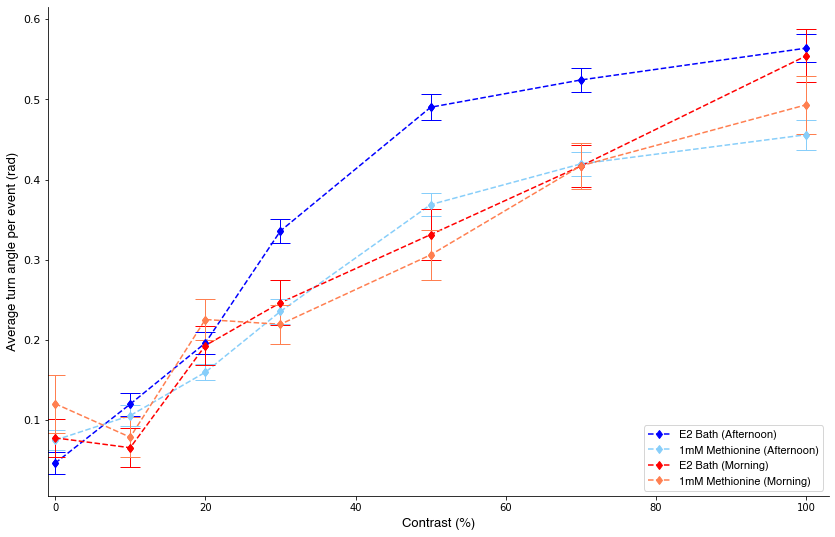

In [219]:
fig, ax = plt.subplots(1,1,figsize=(14,9))

x = [0,10,20,30,50,70,100]

ax.plot(x,pm_e_delta,ls='--',c='b',marker='d',mfc='b',label='E2 Bath (Afternoon)')
# ax.plot(np.linspace(0,100,50),pm_e_delta_fit,'--b',label='Fitted E2 Bath (Afternoon)')
ax.plot(x,pm_me_delta,ls='--',c='lightskyblue',marker='d',mfc='lightskyblue',label='1mM Methionine (Afternoon)')
# ax.plot(np.linspace(0,100,50),pm_me_delta_fit,c='lightskyblue',ls='--',label='Fitted 1mM Methionine (Afternoon)')
     
ax.plot(x,am_e_delta,ls='--',c='r',marker='d',mfc='r',label='E2 Bath (Morning)')
# ax.plot(np.linspace(0,100,50),am_e_delta_fit,'--r',label='Fitted E2 Bath (Morning)')
ax.plot(x,am_me_delta,ls='--',c='coral',marker='d',mfc='coral',label='1mM Methionine (Morning)')
# ax.plot(np.linspace(0,100,50),am_me_delta_fit,c='coral',ls='--',label='Fitted 1mM Methionine (Morning)')


ax.errorbar(x,pm_e_delta,yerr=pm_e_delta_yerr,fmt='d',color='b',capsize=10,elinewidth=1)
ax.errorbar(x,pm_me_delta,yerr=pm_me_delta_yerr,fmt='d',color='lightskyblue',capsize=10,elinewidth=1)

ax.errorbar(x,am_e_delta,yerr=am_e_delta_yerr,fmt='d',color='r',capsize=10,elinewidth=1)
ax.errorbar(x,am_me_delta,yerr=am_me_delta_yerr,fmt='d',color='coral',capsize=10,elinewidth=1)


font = font_manager.FontProperties(family='Helvetica',
                                   style='normal', size=11)
plt.legend(loc='lower right',prop=font)
plt.title('')
plt.xlabel('Contrast (%)',size=13,name='Helvetica')
plt.ylabel('Average turn angle per event (rad)',size=13,name='Helvetica')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# plt.grid(which='major',axis='y')
# x_ticks = [1, 10, 20, 30, 50, 70, 100]
# x_labels = [1, 10, 20, 30, 50, 70, 100] 
# plt.xticks(ticks=x_ticks, labels=x_labels,fontsize=11)
plt.yticks(fontsize=11)
# ax.set_ylim(0,0.4)
ax.set_xlim(-1,103)
plt.savefig('../../Dissertation/bout_angle_function.png',dpi=400,bbox_inches='tight')
plt.show()

In [ ]:
# full_event_table.info()

# Delta_theta_rad OLS and ANOVA

In [211]:
bout_angle_model = ols(formula='delta_theta_rad ~ C(medium, Sum) + C(time, Sum) + C(contrast, Sum) + C(medium, Sum):\
                        C(time, Sum) + C(medium, Sum):C(contrast, Sum) + C(time, Sum):C(contrast, Sum) + \
                        C(medium, Sum):C(time, Sum):C(contrast, Sum)',data=full_event_table).fit()
anova_table_bout = sm.stats.anova_lm(bout_angle_model, typ=3)
anova_table_bout

,sum_sq,df,F,PR(>F)
Intercept,1196.803153,1.0,4776.686912,0.000000e+00
"C(medium, Sum)",4.514326,1.0,18.017602,2.198903e-05
"C(time, Sum)",2.392673,1.0,9.549648,2.002712e-03
"C(contrast, Sum)",369.953217,6.0,246.093198,2.357475e-304
"C(medium, Sum):C(time, Sum)",3.630794,1.0,14.491242,1.412462e-04
"C(medium, Sum):C(contrast, Sum)",6.274652,6.0,4.173904,3.371382e-04
"C(time, Sum):C(contrast, Sum)",9.769881,6.0,6.498933,7.293144e-07
"C(medium, Sum):C(time, Sum):C(contrast, Sum)",0.942731,6.0,0.627105,7.087589e-01
Residual,4854.423478,19375.0,NaN,NaN


In [212]:
am_bout_angle_model = ols(formula='delta_theta_rad ~ C(medium, Sum) + C(contrast, Sum) + \
                        C(medium, Sum):C(contrast, Sum)',data=am_events).fit()
anova_table_bout_am = sm.stats.anova_lm(am_bout_angle_model, typ=3)
anova_table_bout_am

,sum_sq,df,F,PR(>F)
Intercept,378.993095,1.0,1175.393813,2.383907e-233
"C(medium, Sum)",0.016678,1.0,0.051724,8.200984e-01
"C(contrast, Sum)",118.812162,6.0,61.413203,5.794102e-74
"C(medium, Sum):C(contrast, Sum)",1.440148,6.0,0.744403,6.138488e-01
Residual,1749.877790,5427.0,NaN,NaN


In [213]:
pm_bout_angle_model = ols(formula='delta_theta_rad ~ C(medium, Sum) + C(contrast, Sum) + \
                        C(medium, Sum):C(contrast, Sum)',data=pm_events).fit()
anova_table_bout_pm = sm.stats.anova_lm(pm_bout_angle_model, typ=3)
anova_table_bout_pm

,sum_sq,df,F,PR(>F)
Intercept,1168.115366,1.0,5248.070009,0.000000e+00
"C(medium, Sum)",14.524914,1.0,65.257053,7.110042e-16
"C(contrast, Sum)",376.066158,6.0,281.596263,0.000000e+00
"C(medium, Sum):C(contrast, Sum)",9.251352,6.0,6.927361,2.299091e-07
Residual,3104.545688,13948.0,NaN,NaN


In [ ]:
pg.welch_anova(data=am_events,dv='delta_theta_rad',between='medium')

In [ ]:
pg.pairwise_gameshowell(data=am_events,dv='delta_theta_rad',between='medium')

In [ ]:
pg.welch_anova(data=pm_events,dv='delta_theta_rad',between='medium')

In [ ]:
pg.pairwise_gameshowell(data=pm_events,dv='delta_theta_rad',between='medium')

# Fish List Function

In [98]:
def sem_with_zero_division_exception(events,fish):
    try:
        return stats.sem(events.loc[(events['fish_n']==fish)]['latency_s'][1:]) 
    except ZeroDivisionError as e:
        return None

def make_fish_list(events):    
    fish_list = pd.DataFrame(columns=['fish_n','bouts_Hz','duration_avg','duration_sem','latency_avg',\
                                      'latency_sem','distance_avg','distance_sem','total_distance'])


    fish_list['fish_n'] = [fish for fish in events['fish_n'].unique()]
    fish_list['bouts_Hz'] = [events.loc[(events['fish_n']==fish)].max()[1]/30 \
                             for fish in events['fish_n'].unique()]
    fish_list['duration_avg'] = [np.mean(events.loc[(events['fish_n']==fish)]['duration_s']) \
                                 for fish in events['fish_n'].unique()]
    fish_list['duration_sem'] = [stats.sem(events.loc[(events['fish_n']==fish)]['duration_s']) \
                                 for fish in events['fish_n'].unique()]
    fish_list['latency_avg'] = [np.mean(events.loc[(events['fish_n']==fish)]['latency_s']) \
                                for fish in events['fish_n'].unique()]
    fish_list['latency_sem'] = [sem_with_zero_division_exception(events,fish) \
                                for fish in events['fish_n'].unique()]
    fish_list['distance_avg'] = [np.mean(events.loc[(events['fish_n']==fish)]['distance']) \
                                for fish in events['fish_n'].unique()]
    fish_list['distance_sem'] = [stats.sem(events.loc[(events['fish_n']==fish)]['distance']) \
                               for fish in events['fish_n'].unique()]
    fish_list['total_distance'] = [events.loc[(events['fish_n']==fish)]['distance'].sum() \
                                  for fish in events['fish_n'].unique()]
    # fish_list['final_cumulative_angle'] = None

    return fish_list

# Making Fish Lists 

In [99]:
am_me_C100_events

,fish_n,event,duration_s,delta_theta_rad,distance,latency_s,time,medium,contrast
event_n,,,,,,,,,
11944,808,1,0.45,0.555560,53.094698,NaN,am,me,100
11945,808,2,0.5,0.611118,51.113862,0.61,am,me,100
11946,808,3,0.32,1.139660,40.316268,6.06,am,me,100
11947,808,4,0.43,0.585351,55.287638,0.25,am,me,100
11948,808,5,0.46,0.701935,48.282195,1.32,am,me,100
...,...,...,...,...,...,...,...,...,...
12277,833,4,0.29,0.053090,12.279161,1.49,am,me,100
12278,833,5,0.07,0.002013,3.991556,0.97,am,me,100
12279,833,6,0.23,0.034007,11.482984,1.44,am,me,100


In [100]:
am_me_C100_events[am_me_C100_events['delta_theta_rad']<-35]

,fish_n,event,duration_s,delta_theta_rad,distance,latency_s,time,medium,contrast
event_n,,,,,,,,,


In [101]:
fish_list_df_names = ['am_e_1','am_e_10','am_e_20','am_e_30','am_e_50','am_e_70','am_e_100',\
                      'pm_e_1','pm_e_10','pm_e_20','pm_e_30','pm_e_50','pm_e_70','pm_e_100',\
                      'am_me_1','am_me_10','am_me_20','am_me_30','am_me_50','am_me_70','am_me_100',\
                      'pm_me_1','pm_me_10','pm_me_20','pm_me_30','pm_me_50','pm_me_70','pm_me_100']

In [102]:
fish_list_dataframes = [am_e_C1_events,am_e_C10_events,am_e_C20_events,am_e_C30_events,am_e_C50_events,\
                        am_e_C70_events,am_e_C100_events,\
                        pm_e_C1_events,pm_e_C10_events,pm_e_C20_events,pm_e_C30_events,pm_e_C50_events,\
                        pm_e_C70_events,pm_e_C100_events,\
                        am_me_C1_events,am_me_C10_events,am_me_C20_events,am_me_C30_events,am_me_C50_events,\
                        am_me_C70_events,am_me_C100_events,\
                        pm_me_C1_events,pm_me_C10_events,pm_me_C20_events,pm_me_C30_events,pm_me_C50_events,\
                        pm_me_C70_events,pm_me_C100_events]

In [103]:
full_fish_list = pd.DataFrame(columns=['fish_n','bouts_Hz','duration_avg','duration_sem','latency_avg',\
                                      'latency_sem','distance_avg','distance_sem','total_distance','time',\
                                       'medium','contrast'])

for name,df in zip(fish_list_df_names,fish_list_dataframes):
    fish_list = make_fish_list(df)
    fish_list['time'] = name.split('_')[0]
    fish_list['medium'] = name.split('_')[1]
    fish_list['contrast'] = int(name.split('_')[2])
#     fish_counter += 1
    full_fish_list = pd.concat([full_fish_list,fish_list])
        
full_fish_list['fish_n'] = np.arange(1,len(full_fish_list)+1,1)
full_fish_list = full_fish_list.set_index('fish_n')

full_fish_list

/Users/katarzynakupczyk/.pyenv/versions/3.8.6/envs/dissertation2022/lib/python3.8/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/katarzynakupczyk/.pyenv/versions/3.8.6/envs/dissertation2022/lib/python3.8/site-packages/numpy/core/_methods.py:258: RuntimeWarning: invalid value encountered in true_divide
  ret = ret / rcount
/Users/katarzynakupczyk/.pyenv/versions/3.8.6/envs/dissertation2022/lib/python3.8/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/katarzynakupczyk/.pyenv/versions/3.8.6/envs/dissertation2022/lib/python3.8/site-packages/numpy/core/_methods.py:258: RuntimeWarning: invalid value encountered in true_divide
  ret = ret / rcount
/Users/katarzynakupczyk/.pyenv/versions/3.8.6/envs/dissertation2022/lib/python3.8/site-packages/numpy/core/_methods.py:264: Runt

/Users/katarzynakupczyk/.pyenv/versions/3.8.6/envs/dissertation2022/lib/python3.8/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/katarzynakupczyk/.pyenv/versions/3.8.6/envs/dissertation2022/lib/python3.8/site-packages/numpy/core/_methods.py:258: RuntimeWarning: invalid value encountered in true_divide
  ret = ret / rcount


,bouts_Hz,duration_avg,duration_sem,latency_avg,latency_sem,distance_avg,distance_sem,total_distance,time,medium,contrast
fish_n,,,,,,,,,,,
1,0.033333,0.32,NaN,NaN,NaN,15.474832,NaN,15.474832,am,e,1
2,0.833333,0.414,0.015177,0.780417,0.073429,46.61023,2.788811,1165.255739,am,e,1
3,0.233333,0.468571,0.011218,3.553333,1.129657,50.007648,10.318067,350.053537,am,e,1
4,0.033333,0.34,NaN,NaN,NaN,17.218222,NaN,17.218222,am,e,1
5,0.433333,0.481538,0.004507,1.705,0.338028,55.754021,3.675881,724.802274,am,e,1
...,...,...,...,...,...,...,...,...,...,...,...
1095,0.233333,0.355714,0.075114,0.983333,0.300995,48.54801,19.927385,339.83607,pm,me,100
1096,0.733333,0.388182,0.014259,0.969524,0.200986,43.970153,3.205752,967.343362,pm,me,100
1097,0.566667,0.409412,0.017245,1.334375,0.362217,41.128959,3.709063,699.192307,pm,me,100


In [129]:
full_fish_list.to_csv('../raw_data/full_fish_list.csv')

In [ ]:
full_fish_list.info()

In [104]:
full_fish_list['bouts_Hz'] = pd.to_numeric(full_fish_list['bouts_Hz'])

In [105]:
full_fish_list['latency_avg'] = pd.to_numeric(full_fish_list['latency_avg'])

In [ ]:
# full_fish_list = pd.read_csv('../raw_data/full_fish_list.csv')

# Bout Frequency OLS and ANOVA

In [214]:
bout_freq_model = ols(formula='bouts_Hz ~ C(medium, Sum) + C(time, Sum) + C(contrast, Sum) + C(medium, Sum):\
                        C(time, Sum) + C(medium, Sum):C(contrast, Sum) + C(time, Sum):C(contrast, Sum) + \
                        C(medium, Sum):C(time, Sum):C(contrast, Sum)',data=full_fish_list).fit()
anova_table_bout = sm.stats.anova_lm(bout_freq_model, typ=3)
anova_table_bout

,sum_sq,df,F,PR(>F)
Intercept,312.844503,1.0,4333.713441,0.000000e+00
"C(medium, Sum)",0.313750,1.0,4.346261,3.732672e-02
"C(time, Sum)",10.525667,1.0,145.807975,1.447424e-31
"C(contrast, Sum)",1.594885,6.0,3.682220,1.257572e-03
"C(medium, Sum):C(time, Sum)",0.006184,1.0,0.085668,7.698148e-01
"C(medium, Sum):C(contrast, Sum)",0.439065,6.0,1.013700,4.146965e-01
"C(time, Sum):C(contrast, Sum)",0.506961,6.0,1.170457,3.196584e-01
"C(medium, Sum):C(time, Sum):C(contrast, Sum)",0.207476,6.0,0.479014,8.242918e-01
Residual,77.313941,1071.0,NaN,NaN


In [107]:
am_fish_list = full_fish_list[full_fish_list['time'] == 'am']
pm_fish_list = full_fish_list[full_fish_list['time'] == 'pm']

In [215]:
am_bout_freq_model = ols(formula='bouts_Hz ~ C(medium, Sum) + C(contrast, Sum) + \
                        C(medium, Sum):C(contrast, Sum)',data=am_fish_list).fit()
anova_table_bout_am = sm.stats.anova_lm(am_bout_freq_model, typ=3)
anova_table_bout_am

,sum_sq,df,F,PR(>F)
Intercept,81.495143,1.0,1219.015091,3.252191e-121
"C(medium, Sum)",0.090572,1.0,1.354788,2.451656e-01
"C(contrast, Sum)",0.646596,6.0,1.611979,1.424616e-01
"C(medium, Sum):C(contrast, Sum)",0.351907,6.0,0.877312,5.115139e-01
Residual,25.671655,384.0,NaN,NaN


In [216]:
pm_bout_freq_model = ols(formula='bouts_Hz ~ C(medium, Sum) + C(contrast, Sum) + \
                        C(medium, Sum):C(contrast, Sum)',data=pm_fish_list).fit()
anova_table_bout_pm = sm.stats.anova_lm(pm_bout_freq_model, typ=3)
anova_table_bout_pm

,sum_sq,df,F,PR(>F)
Intercept,304.197662,1.0,4046.757270,3.789915e-290
"C(medium, Sum)",0.283296,1.0,3.768698,5.262883e-02
"C(contrast, Sum)",1.751420,6.0,3.883205,8.034404e-04
"C(medium, Sum):C(contrast, Sum)",0.275712,6.0,0.611301,7.214085e-01
Residual,51.642285,687.0,NaN,NaN


In [220]:
pg.welch_anova(data=am_fish_list,dv='bouts_Hz',between='medium')

,Source,ddof1,ddof2,F,p-unc,np2
0,medium,1,395.847487,1.063396,0.303072,0.002646


In [221]:
pg.welch_anova(data=pm_fish_list,dv='bouts_Hz',between='medium')

,Source,ddof1,ddof2,F,p-unc,np2
0,medium,1,689.608545,3.560999,0.059572,0.005077


In [108]:
am_e_fish_list = am_fish_list[am_fish_list['medium'] == 'e']
am_me_fish_list = am_fish_list[am_fish_list['medium'] == 'me']

pm_e_fish_list = pm_fish_list[pm_fish_list['medium'] == 'e']
pm_me_fish_list = pm_fish_list[pm_fish_list['medium'] == 'me']

In [109]:
am_e_1_fish_list = am_e_fish_list[am_e_fish_list['contrast'] == 1]
am_e_10_fish_list = am_e_fish_list[am_e_fish_list['contrast'] == 10]
am_e_20_fish_list = am_e_fish_list[am_e_fish_list['contrast'] == 20]
am_e_30_fish_list = am_e_fish_list[am_e_fish_list['contrast'] == 30]
am_e_50_fish_list = am_e_fish_list[am_e_fish_list['contrast'] == 50]
am_e_70_fish_list = am_e_fish_list[am_e_fish_list['contrast'] == 70]
am_e_100_fish_list = am_e_fish_list[am_e_fish_list['contrast'] == 100]

In [110]:
am_me_1_fish_list = am_me_fish_list[am_me_fish_list['contrast'] == 1]
am_me_10_fish_list = am_me_fish_list[am_me_fish_list['contrast'] == 10]
am_me_20_fish_list = am_me_fish_list[am_me_fish_list['contrast'] == 20]
am_me_30_fish_list = am_me_fish_list[am_me_fish_list['contrast'] == 30]
am_me_50_fish_list = am_me_fish_list[am_me_fish_list['contrast'] == 50]
am_me_70_fish_list = am_me_fish_list[am_me_fish_list['contrast'] == 70]
am_me_100_fish_list = am_me_fish_list[am_me_fish_list['contrast'] == 100]

In [111]:
pm_e_1_fish_list = pm_e_fish_list[pm_e_fish_list['contrast'] == 1]
pm_e_10_fish_list = pm_e_fish_list[pm_e_fish_list['contrast'] == 10]
pm_e_20_fish_list = pm_e_fish_list[pm_e_fish_list['contrast'] == 20]
pm_e_30_fish_list = pm_e_fish_list[pm_e_fish_list['contrast'] == 30]
pm_e_50_fish_list = pm_e_fish_list[pm_e_fish_list['contrast'] == 50]
pm_e_70_fish_list = pm_e_fish_list[pm_e_fish_list['contrast'] == 70]
pm_e_100_fish_list = pm_e_fish_list[pm_e_fish_list['contrast'] == 100]

In [112]:
pm_me_1_fish_list = pm_me_fish_list[pm_me_fish_list['contrast'] == 1]
pm_me_10_fish_list = pm_me_fish_list[pm_me_fish_list['contrast'] == 10]
pm_me_20_fish_list = pm_me_fish_list[pm_me_fish_list['contrast'] == 20]
pm_me_30_fish_list = pm_me_fish_list[pm_me_fish_list['contrast'] == 30]
pm_me_50_fish_list = pm_me_fish_list[pm_me_fish_list['contrast'] == 50]
pm_me_70_fish_list = pm_me_fish_list[pm_me_fish_list['contrast'] == 70]
pm_me_100_fish_list = pm_me_fish_list[pm_me_fish_list['contrast'] == 100]

In [119]:
am_e_fish_list

,bouts_Hz,duration_avg,duration_sem,latency_avg,latency_sem,distance_avg,distance_sem,total_distance,time,medium,contrast
fish_n,,,,,,,,,,,
1,0.033333,0.32,NaN,NaN,NaN,15.474832,NaN,15.474832,am,e,1
2,0.833333,0.414,0.015177,0.780417,0.073429,46.61023,2.788811,1165.255739,am,e,1
3,0.233333,0.468571,0.011218,3.553333,1.129657,50.007648,10.318067,350.053537,am,e,1
4,0.033333,0.34,NaN,NaN,NaN,17.218222,NaN,17.218222,am,e,1
5,0.433333,0.481538,0.004507,1.705000,0.338028,55.754021,3.675881,724.802274,am,e,1
...,...,...,...,...,...,...,...,...,...,...,...
207,0.200000,0.376667,0.067165,4.508000,3.135391,40.478553,8.282216,242.87132,am,e,100
208,0.733333,0.468636,0.035967,0.870000,0.101089,87.591183,9.774914,1927.006029,am,e,100
209,0.766667,0.393478,0.019778,0.901818,0.169541,45.555216,4.594234,1047.769971,am,e,100


(array([2.05915999, 0.49027619, 0.88249714, 0.68638666, 2.05915999,
        0.7844419 , 1.76499428, 0.68638666, 1.47082857, 0.7844419 ,
        0.88249714, 1.66693904, 0.88249714, 0.88249714, 0.7844419 ,
        1.07860762, 0.68638666, 0.98055238, 0.7844419 , 0.39222095]),
 array([0.03333333, 0.08166667, 0.13      , 0.17833333, 0.22666667,
        0.275     , 0.32333333, 0.37166667, 0.42      , 0.46833333,
        0.51666667, 0.565     , 0.61333333, 0.66166667, 0.71      ,
        0.75833333, 0.80666667, 0.855     , 0.90333333, 0.95166667,
        1.        ]),
 <BarContainer object of 20 artists>)

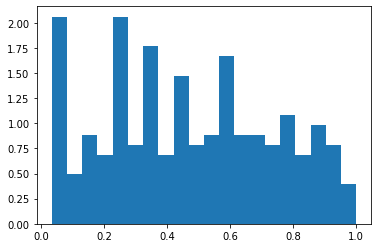

In [118]:
plt.hist(am_e_fish_list['bouts_Hz'],density=True,bins=20)

(array([1.70777989, 0.85388994, 1.24202174, 1.16439538, 1.24202174,
        1.00914266, 1.78540624, 1.47490081, 1.00914266, 0.69863723,
        0.77626358, 0.85388994, 0.38813179, 0.15525272, 0.15525272]),
 array([0.03333333, 0.10222222, 0.17111111, 0.24      , 0.30888889,
        0.37777778, 0.44666667, 0.51555556, 0.58444444, 0.65333333,
        0.72222222, 0.79111111, 0.86      , 0.92888889, 0.99777778,
        1.06666667]),
 <BarContainer object of 15 artists>)

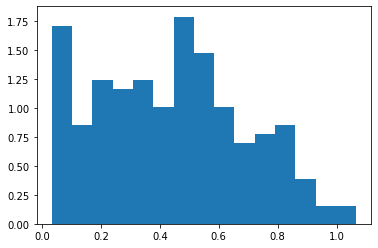

In [123]:
plt.hist(am_me_fish_list['bouts_Hz'],density=True,bins=15)

(array([0.35561878, 0.56899004, 0.54528212, 0.94831674, 0.68752963,
        1.39876719, 1.70697013, 1.23281176, 0.3793267 , 0.07112376]),
 array([0.03333333, 0.16      , 0.28666667, 0.41333333, 0.54      ,
        0.66666667, 0.79333333, 0.92      , 1.04666667, 1.17333333,
        1.3       ]),
 <BarContainer object of 10 artists>)

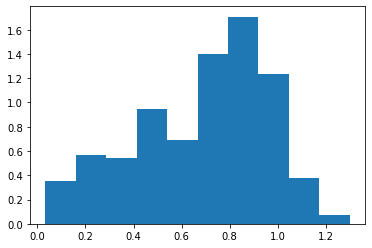

In [115]:
plt.hist(pm_e_fish_list['bouts_Hz'],density=True)

(array([0.34937888, 0.44254658, 0.88509317, 0.74534161, 1.30434783,
        1.11801242, 1.49068323, 0.95496894, 1.04813665, 0.23291925]),
 array([0.03333333, 0.15      , 0.26666667, 0.38333333, 0.5       ,
        0.61666667, 0.73333333, 0.85      , 0.96666667, 1.08333333,
        1.2       ]),
 <BarContainer object of 10 artists>)

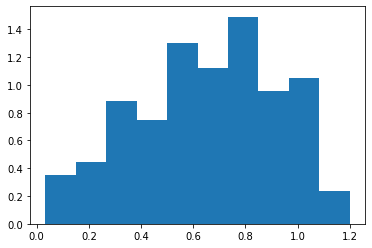

In [116]:
plt.hist(pm_me_fish_list['bouts_Hz'],density=True)

# Bout Frequency Mean and SEM Calculations

In [130]:
am_e_bout_hz = [am_e_1_fish_list['bouts_Hz'].mean(),am_e_10_fish_list['bouts_Hz'].mean(),\
               am_e_20_fish_list['bouts_Hz'].mean(),am_e_30_fish_list['bouts_Hz'].mean(),\
               am_e_50_fish_list['bouts_Hz'].mean(),am_e_70_fish_list['bouts_Hz'].mean(),\
               am_e_100_fish_list['bouts_Hz'].mean()]
am_me_bout_hz = [am_me_1_fish_list['bouts_Hz'].mean(),am_me_10_fish_list['bouts_Hz'].mean(),\
               am_me_20_fish_list['bouts_Hz'].mean(),am_me_30_fish_list['bouts_Hz'].mean(),\
               am_me_50_fish_list['bouts_Hz'].mean(),am_me_70_fish_list['bouts_Hz'].mean(),\
               am_me_100_fish_list['bouts_Hz'].mean()]
pm_e_bout_hz = [pm_e_1_fish_list['bouts_Hz'].mean(),pm_e_10_fish_list['bouts_Hz'].mean(),\
               pm_e_20_fish_list['bouts_Hz'].mean(),pm_e_30_fish_list['bouts_Hz'].mean(),\
               pm_e_50_fish_list['bouts_Hz'].mean(),pm_e_70_fish_list['bouts_Hz'].mean(),\
               pm_e_100_fish_list['bouts_Hz'].mean()]
pm_me_bout_hz = [pm_me_1_fish_list['bouts_Hz'].mean(),pm_me_10_fish_list['bouts_Hz'].mean(),\
               pm_me_20_fish_list['bouts_Hz'].mean(),pm_me_30_fish_list['bouts_Hz'].mean(),\
               pm_me_50_fish_list['bouts_Hz'].mean(),pm_me_70_fish_list['bouts_Hz'].mean(),\
               pm_me_100_fish_list['bouts_Hz'].mean()]

In [131]:
am_e_1_bout_hz_sem = stats.sem(am_e_1_fish_list['bouts_Hz'])
am_e_10_bout_hz_sem = stats.sem(am_e_10_fish_list['bouts_Hz'])
am_e_20_bout_hz_sem = stats.sem(am_e_20_fish_list['bouts_Hz'])
am_e_30_bout_hz_sem = stats.sem(am_e_30_fish_list['bouts_Hz'])
am_e_50_bout_hz_sem = stats.sem(am_e_50_fish_list['bouts_Hz'])
am_e_70_bout_hz_sem = stats.sem(am_e_70_fish_list['bouts_Hz'])
am_e_100_bout_hz_sem = stats.sem(am_e_100_fish_list['bouts_Hz'])

In [132]:
am_me_1_bout_hz_sem = stats.sem(am_me_1_fish_list['bouts_Hz'])
am_me_10_bout_hz_sem = stats.sem(am_me_10_fish_list['bouts_Hz'])
am_me_20_bout_hz_sem = stats.sem(am_me_20_fish_list['bouts_Hz'])
am_me_30_bout_hz_sem = stats.sem(am_me_30_fish_list['bouts_Hz'])
am_me_50_bout_hz_sem = stats.sem(am_me_50_fish_list['bouts_Hz'])
am_me_70_bout_hz_sem = stats.sem(am_me_70_fish_list['bouts_Hz'])
am_me_100_bout_hz_sem = stats.sem(am_me_100_fish_list['bouts_Hz'])

In [133]:
pm_e_1_bout_hz_sem = stats.sem(pm_e_1_fish_list['bouts_Hz'])
pm_e_10_bout_hz_sem = stats.sem(pm_e_10_fish_list['bouts_Hz'])
pm_e_20_bout_hz_sem = stats.sem(pm_e_20_fish_list['bouts_Hz'])
pm_e_30_bout_hz_sem = stats.sem(pm_e_30_fish_list['bouts_Hz'])
pm_e_50_bout_hz_sem = stats.sem(pm_e_50_fish_list['bouts_Hz'])
pm_e_70_bout_hz_sem = stats.sem(pm_e_70_fish_list['bouts_Hz'])
pm_e_100_bout_hz_sem = stats.sem(pm_e_100_fish_list['bouts_Hz'])

In [134]:
pm_me_1_bout_hz_sem = stats.sem(pm_me_1_fish_list['bouts_Hz'])
pm_me_10_bout_hz_sem = stats.sem(pm_me_10_fish_list['bouts_Hz'])
pm_me_20_bout_hz_sem = stats.sem(pm_me_20_fish_list['bouts_Hz'])
pm_me_30_bout_hz_sem = stats.sem(pm_me_30_fish_list['bouts_Hz'])
pm_me_50_bout_hz_sem = stats.sem(pm_me_50_fish_list['bouts_Hz'])
pm_me_70_bout_hz_sem = stats.sem(pm_me_70_fish_list['bouts_Hz'])
pm_me_100_bout_hz_sem = stats.sem(pm_me_100_fish_list['bouts_Hz'])

In [135]:
am_e_bout_hz_yerr = [am_e_1_bout_hz_sem,am_e_10_bout_hz_sem,am_e_20_bout_hz_sem,am_e_30_bout_hz_sem,\
                     am_e_50_bout_hz_sem,am_e_70_bout_hz_sem,am_e_100_bout_hz_sem]
am_me_bout_hz_yerr = [am_me_1_bout_hz_sem,am_me_10_bout_hz_sem,am_me_20_bout_hz_sem,am_me_30_bout_hz_sem,\
                      am_me_50_bout_hz_sem,am_me_70_bout_hz_sem,am_me_100_bout_hz_sem]

pm_e_bout_hz_yerr = [pm_e_1_bout_hz_sem,pm_e_10_bout_hz_sem,pm_e_20_bout_hz_sem,pm_e_30_bout_hz_sem,\
                     pm_e_50_bout_hz_sem,pm_e_70_bout_hz_sem,pm_e_100_bout_hz_sem]
pm_me_bout_hz_yerr = [pm_me_1_bout_hz_sem,pm_me_10_bout_hz_sem,pm_me_20_bout_hz_sem,pm_me_30_bout_hz_sem,\
                      pm_me_50_bout_hz_sem,pm_me_70_bout_hz_sem,pm_me_100_bout_hz_sem]

# Fitting a Straight Line Functions

In [136]:
def straight_line(x, A, B): # this is your 'straight line' y=f(x)
    return np.multiply(A,x) + B

# popt, pcov = curve_fit(f, x, y) # your data x, y to fit

def fit_straight_line(ydata):
    xdata = [1,10,20,30,50,70,100]
#     p0 = [max(ydata), np.median(xdata),1,min(ydata)] # this is an mandatory initial guess
    popt, pcov = curve_fit(straight_line, xdata, ydata)
    y = straight_line(xdata, popt[0],popt[1])
    new_x = np.linspace(0,100,50)
    new_y = straight_line(new_x, popt[0],popt[1])
    return new_y

In [137]:
am_e_bout_hz_fit = fit_straight_line(am_e_bout_hz)
am_me_bout_hz_fit = fit_straight_line(am_me_bout_hz)
pm_e_bout_hz_fit = fit_straight_line(pm_e_bout_hz)
pm_me_bout_hz_fit = fit_straight_line(pm_me_bout_hz)

# Bout Frequency Plot

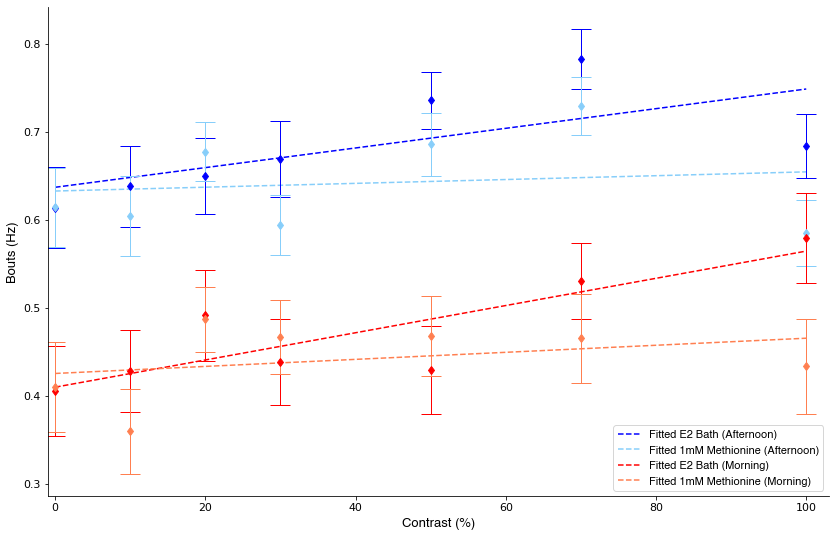

In [218]:
fig, ax = plt.subplots(1,1,figsize=(14,9))

x = [0,10,20,30,50,70,100]

# ax.plot(x,pm_e_bout_hz,c='b',marker='d',mfc='b',label='E2 Bath (Afternoon)')
ax.plot(np.linspace(0,100,50),pm_e_bout_hz_fit,'--b',label='Fitted E2 Bath (Afternoon)')
# ax.plot(x,pm_me_bout_hz,c='lightskyblue',marker='d',mfc='lightskyblue',label='1mM Methionine (Afternoon)')
ax.plot(np.linspace(0,100,50),pm_me_bout_hz_fit,c='lightskyblue',ls='--',label='Fitted 1mM Methionine (Afternoon)')
     
# ax.plot(x,am_e_bout_hz,c='r',marker='d',mfc='r',label='E2 Bath (Morning)')
ax.plot(np.linspace(0,100,50),am_e_bout_hz_fit,'--r',label='Fitted E2 Bath (Morning)')
# ax.plot(x,am_me_bout_hz,c='coral',marker='d',mfc='coral',label='1mM Methionine (Morning)')
ax.plot(np.linspace(0,100,50),am_me_bout_hz_fit,c='coral',ls='--',label='Fitted 1mM Methionine (Morning)')


ax.errorbar(x,pm_e_bout_hz,yerr=pm_e_bout_hz_yerr,fmt='d',color='b',capsize=10,elinewidth=1)
ax.errorbar(x,pm_me_bout_hz,yerr=pm_me_bout_hz_yerr,fmt='d',color='lightskyblue',capsize=10,elinewidth=1)

ax.errorbar(x,am_e_bout_hz,yerr=am_e_bout_hz_yerr,fmt='d',color='r',capsize=10,elinewidth=1)
ax.errorbar(x,am_me_bout_hz,yerr=am_me_bout_hz_yerr,fmt='d',color='coral',capsize=10,elinewidth=1)


font = font_manager.FontProperties(family='Helvetica',
                                   style='normal', size=11)
plt.legend(loc='lower right',prop=font)
plt.title('')
plt.xlabel('Contrast (%)',size=13,name='Helvetica')
plt.ylabel('Bouts (Hz)',size=13,name='Helvetica')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# plt.grid(which='major',axis='y')
# x_ticks = [1, 10, 20, 30, 50, 70, 100]
# x_labels = [1, 10, 20, 30, 50, 70, 100] 
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
# ax.set_ylim(0,0.5)
ax.set_xlim(-1,103)
plt.savefig('../../Dissertation/bout_freq_function.png',dpi=400,bbox_inches='tight')
plt.show()

# Interbout Interval OLS and ANOVA

In [ ]:
full_fish_list

In [139]:
full_fish_list['latency_avg']=pd.to_numeric(full_fish_list['latency_avg'])

In [140]:
am_fish_list['latency_avg']=pd.to_numeric(am_fish_list['latency_avg'])

/var/folders/wd/4w68b8ld47x6kzpx1zhzn8qm0000gn/T/ipykernel_67266/91959815.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  am_fish_list['latency_avg']=pd.to_numeric(am_fish_list['latency_avg'])


In [141]:
pm_fish_list['latency_avg']=pd.to_numeric(pm_fish_list['latency_avg'])

/var/folders/wd/4w68b8ld47x6kzpx1zhzn8qm0000gn/T/ipykernel_67266/3614410718.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pm_fish_list['latency_avg']=pd.to_numeric(pm_fish_list['latency_avg'])


In [142]:
interbout_model = ols(formula='latency_avg ~ C(medium, Sum) + C(time, Sum) + C(contrast, Sum) + C(medium, Sum):\
                        C(time, Sum) + C(medium, Sum):C(contrast, Sum) + C(time, Sum):C(contrast, Sum) + \
                        C(medium, Sum):C(time, Sum):C(contrast, Sum)',data=full_fish_list).fit()
anova_table_interbout = sm.stats.anova_lm(interbout_model, typ=3)
anova_table_interbout

,sum_sq,df,F,PR(>F)
Intercept,3068.267162,1.0,842.108835,4.378056e-136
"C(medium, Sum)",39.760778,1.0,10.912642,9.876832e-04
"C(time, Sum)",260.043609,1.0,71.370910,9.879572e-17
"C(contrast, Sum)",21.652302,6.0,0.990439,4.302730e-01
"C(medium, Sum):C(time, Sum)",18.285177,1.0,5.018503,2.528860e-02
"C(medium, Sum):C(contrast, Sum)",32.282876,6.0,1.476713,1.827977e-01
"C(time, Sum):C(contrast, Sum)",37.867818,6.0,1.732184,1.102367e-01
"C(medium, Sum):C(time, Sum):C(contrast, Sum)",16.498888,6.0,0.754707,6.057280e-01
Residual,3785.650321,1039.0,NaN,NaN


In [143]:
am_interbout_model = ols(formula='latency_avg ~ C(medium, Sum) + C(contrast, Sum) + \
                        C(medium, Sum):C(contrast, Sum)',data=am_fish_list).fit()
anova_table_interbout_am = sm.stats.anova_lm(am_interbout_model, typ=3)
anova_table_interbout_am

,sum_sq,df,F,PR(>F)
Intercept,1971.322261,1.0,242.517647,3.236539e-42
"C(medium, Sum)",43.156153,1.0,5.309192,2.177881e-02
"C(contrast, Sum)",41.472717,6.0,0.850349,5.317667e-01
"C(medium, Sum):C(contrast, Sum)",34.220058,6.0,0.701641,6.484680e-01
Residual,2942.543224,362.0,NaN,NaN


In [144]:
pm_interbout_model = ols(formula='latency_avg ~ C(medium, Sum) + C(contrast, Sum) + \
                        C(medium, Sum):C(contrast, Sum)',data=pm_fish_list).fit()
anova_table_interbout_pm = sm.stats.anova_lm(pm_interbout_model, typ=3)
anova_table_interbout_pm

,sum_sq,df,F,PR(>F)
Intercept,1097.073368,1.0,880.930398,1.220527e-124
"C(medium, Sum)",2.930744,1.0,2.353335,1.254825e-01
"C(contrast, Sum)",10.359647,6.0,1.386435,2.174615e-01
"C(medium, Sum):C(contrast, Sum)",4.834572,6.0,0.647013,6.925863e-01
Residual,843.107097,677.0,NaN,NaN


In [145]:
pg.welch_anova(data=am_fish_list,dv='latency_avg',between='medium')

,Source,ddof1,ddof2,F,p-unc,np2
0,medium,1,256.077629,4.925403,0.027341,0.013683


In [146]:
pg.welch_anova(data=pm_fish_list,dv='latency_avg',between='medium')

,Source,ddof1,ddof2,F,p-unc,np2
0,medium,1,666.685056,2.337454,0.12677,0.003286


# Interbout Intervals Mean & SEM Calculations

In [147]:
am_e_interbout = [am_e_1_fish_list['latency_avg'].mean(),am_e_10_fish_list['latency_avg'].mean(),\
               am_e_20_fish_list['latency_avg'].mean(),am_e_30_fish_list['latency_avg'].mean(),\
               am_e_50_fish_list['latency_avg'].mean(),am_e_70_fish_list['latency_avg'].mean(),\
               am_e_100_fish_list['latency_avg'].mean()]
am_me_interbout = [am_me_1_fish_list['latency_avg'].mean(),am_me_10_fish_list['latency_avg'].mean(),\
               am_me_20_fish_list['latency_avg'].mean(),am_me_30_fish_list['latency_avg'].mean(),\
               am_me_50_fish_list['latency_avg'].mean(),am_me_70_fish_list['latency_avg'].mean(),\
               am_me_100_fish_list['latency_avg'].mean()]
pm_e_interbout = [pm_e_1_fish_list['latency_avg'].mean(),pm_e_10_fish_list['latency_avg'].mean(),\
               pm_e_20_fish_list['latency_avg'].mean(),pm_e_30_fish_list['latency_avg'].mean(),\
               pm_e_50_fish_list['latency_avg'].mean(),pm_e_70_fish_list['latency_avg'].mean(),\
               pm_e_100_fish_list['latency_avg'].mean()]
pm_me_interbout = [pm_me_1_fish_list['latency_avg'].mean(),pm_me_10_fish_list['latency_avg'].mean(),\
               pm_me_20_fish_list['latency_avg'].mean(),pm_me_30_fish_list['latency_avg'].mean(),\
               pm_me_50_fish_list['latency_avg'].mean(),pm_me_70_fish_list['latency_avg'].mean(),\
               pm_me_100_fish_list['latency_avg'].mean()]

In [148]:
am_e_1_interbout_sem = stats.sem(am_e_1_fish_list['latency_avg'],nan_policy='omit')
am_e_10_interbout_sem = stats.sem(am_e_10_fish_list['latency_avg'],nan_policy='omit')
am_e_20_interbout_sem = stats.sem(am_e_20_fish_list['latency_avg'],nan_policy='omit')
am_e_30_interbout_sem = stats.sem(am_e_30_fish_list['latency_avg'],nan_policy='omit')
am_e_50_interbout_sem = stats.sem(am_e_50_fish_list['latency_avg'],nan_policy='omit')
am_e_70_interbout_sem = stats.sem(am_e_70_fish_list['latency_avg'],nan_policy='omit')
am_e_100_interbout_sem = stats.sem(am_e_100_fish_list['latency_avg'],nan_policy='omit')

In [149]:
am_me_1_interbout_sem = stats.sem(am_me_1_fish_list['latency_avg'],nan_policy='omit')
am_me_10_interbout_sem = stats.sem(am_me_10_fish_list['latency_avg'],nan_policy='omit')
am_me_20_interbout_sem = stats.sem(am_me_20_fish_list['latency_avg'],nan_policy='omit')
am_me_30_interbout_sem = stats.sem(am_me_30_fish_list['latency_avg'],nan_policy='omit')
am_me_50_interbout_sem = stats.sem(am_me_50_fish_list['latency_avg'],nan_policy='omit')
am_me_70_interbout_sem = stats.sem(am_me_70_fish_list['latency_avg'],nan_policy='omit')
am_me_100_interbout_sem = stats.sem(am_me_100_fish_list['latency_avg'],nan_policy='omit')

In [150]:
pm_e_1_interbout_sem = stats.sem(pm_e_1_fish_list['latency_avg'],nan_policy='omit')
pm_e_10_interbout_sem = stats.sem(pm_e_10_fish_list['latency_avg'],nan_policy='omit')
pm_e_20_interbout_sem = stats.sem(pm_e_20_fish_list['latency_avg'],nan_policy='omit')
pm_e_30_interbout_sem = stats.sem(pm_e_30_fish_list['latency_avg'],nan_policy='omit')
pm_e_50_interbout_sem = stats.sem(pm_e_50_fish_list['latency_avg'],nan_policy='omit')
pm_e_70_interbout_sem = stats.sem(pm_e_70_fish_list['latency_avg'],nan_policy='omit')
pm_e_100_interbout_sem = stats.sem(pm_e_100_fish_list['latency_avg'],nan_policy='omit')

In [151]:
pm_me_1_interbout_sem = stats.sem(pm_me_1_fish_list['latency_avg'],nan_policy='omit')
pm_me_10_interbout_sem = stats.sem(pm_me_10_fish_list['latency_avg'],nan_policy='omit')
pm_me_20_interbout_sem = stats.sem(pm_me_20_fish_list['latency_avg'],nan_policy='omit')
pm_me_30_interbout_sem = stats.sem(pm_me_30_fish_list['latency_avg'],nan_policy='omit')
pm_me_50_interbout_sem = stats.sem(pm_me_50_fish_list['latency_avg'],nan_policy='omit')
pm_me_70_interbout_sem = stats.sem(pm_me_70_fish_list['latency_avg'],nan_policy='omit')
pm_me_100_interbout_sem = stats.sem(pm_me_100_fish_list['latency_avg'],nan_policy='omit')

In [152]:
am_e_interbout_yerr = [am_e_1_interbout_sem,am_e_10_interbout_sem,am_e_20_interbout_sem,am_e_30_interbout_sem,\
                     am_e_50_interbout_sem,am_e_70_interbout_sem,am_e_100_interbout_sem]
am_me_interbout_yerr = [am_me_1_interbout_sem,am_me_10_interbout_sem,am_me_20_interbout_sem,am_me_30_interbout_sem,\
                      am_me_50_interbout_sem,am_me_70_interbout_sem,am_me_100_interbout_sem]

pm_e_interbout_yerr = [pm_e_1_interbout_sem,pm_e_10_interbout_sem,pm_e_20_interbout_sem,pm_e_30_interbout_sem,\
                     pm_e_50_interbout_sem,pm_e_70_interbout_sem,pm_e_100_interbout_sem]
pm_me_interbout_yerr = [pm_me_1_interbout_sem,pm_me_10_interbout_sem,pm_me_20_interbout_sem,pm_me_30_interbout_sem,\
                      pm_me_50_interbout_sem,pm_me_70_interbout_sem,pm_me_100_interbout_sem]

In [153]:
am_e_interbout_fit = fit_straight_line(am_e_interbout)
am_me_interbout_fit = fit_straight_line(am_me_interbout)
pm_e_interbout_fit = fit_straight_line(pm_e_interbout)
pm_me_interbout_fit = fit_straight_line(pm_me_interbout)

# Interbout Interval Plot

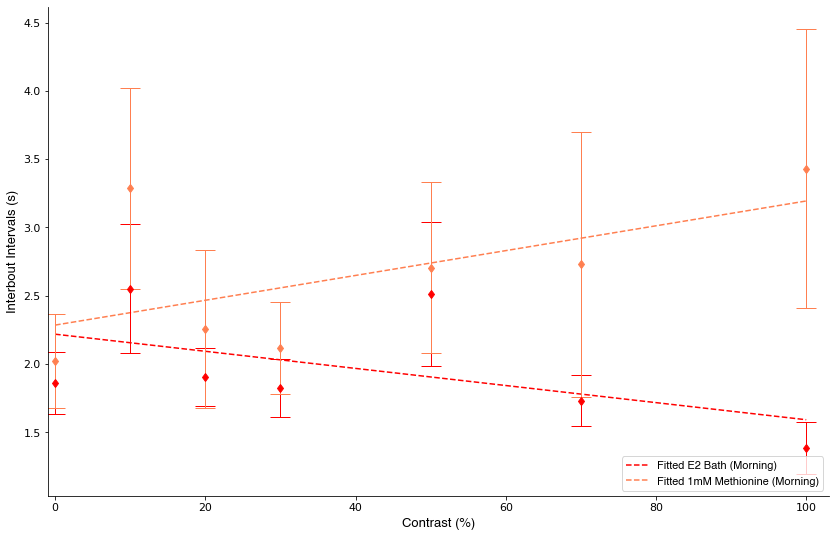

In [155]:
fig, ax = plt.subplots(1,1,figsize=(14,9))

x = [0,10,20,30,50,70,100]

# ax.plot(x,pm_e_interbout,c='b',marker='d',mfc='b',label='E2 Bath (Afternoon)')
# ax.plot(np.linspace(0,100,50),pm_e_interbout_fit,'--b',label='Fitted E2 Bath (Afternoon)')
# ax.plot(x,pm_me_interbout,c='lightskyblue',marker='d',mfc='lightskyblue',label='1mM Methionine (Afternoon)')
# ax.plot(np.linspace(0,100,50),pm_me_interbout_fit,c='lightskyblue',ls='--',label='Fitted 1mM Methionine (Afternoon)')
     
# ax.plot(x,am_e_interbout,c='r',marker='d',mfc='r',label='E2 Bath (Morning)')
ax.plot(np.linspace(0,100,50),am_e_interbout_fit,'--r',label='Fitted E2 Bath (Morning)')
# ax.plot(x,am_me_interbout,c='coral',marker='d',mfc='coral',label='1mM Methionine (Morning)')
ax.plot(np.linspace(0,100,50),am_me_interbout_fit,c='coral',ls='--',label='Fitted 1mM Methionine (Morning)')


# ax.errorbar(x,pm_e_interbout,yerr=pm_e_interbout_yerr,fmt='d',color='b',capsize=10,elinewidth=1)
# ax.errorbar(x,pm_me_interbout,yerr=pm_me_interbout_yerr,fmt='d',color='lightskyblue',capsize=10,elinewidth=1)

ax.errorbar(x,am_e_interbout,yerr=am_e_interbout_yerr,fmt='d',color='r',capsize=10,elinewidth=1)
ax.errorbar(x,am_me_interbout,yerr=am_me_interbout_yerr,fmt='d',color='coral',capsize=10,elinewidth=1)


font = font_manager.FontProperties(family='Helvetica',
                                   style='normal', size=11)
plt.legend(loc='lower right',prop=font)
plt.title('')
plt.xlabel('Contrast (%)',size=13,name='Helvetica')
plt.ylabel('Interbout Intervals (s)',size=13,name='Helvetica')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# plt.grid(which='major',axis='y')
# x_ticks = [1, 10, 20, 30, 50, 70, 100]
# x_labels = [1, 10, 20, 30, 50, 70, 100] 
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
# ax.set_ylim(0,4)
ax.set_xlim(-1,103)
# plt.savefig('../../Dissertation/interbout_interval_function.png',dpi=400,bbox_inches='tight')
plt.show()

In [156]:
am_e_100_fish_list['latency_avg'].mean()

1.3865964682779868

In [157]:
am_e_100_fish_list['latency_avg'].var()

0.8465554832805662

In [158]:
am_me_100_fish_list['latency_avg'].mean()

3.4318123494548707

In [159]:
am_me_100_fish_list['latency_avg'].var()

27.09030556371504

(array([3., 8., 4., 1., 2., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 1.]),
 array([0.66      , 0.82730435, 0.9946087 , 1.16191304, 1.32921739,
        1.49652174, 1.66382609, 1.83113043, 1.99843478, 2.16573913,
        2.33304348, 2.50034783, 2.66765217, 2.83495652, 3.00226087,
        3.16956522, 3.33686957, 3.50417391, 3.67147826, 3.83878261,
        4.00608696, 4.1733913 , 4.34069565, 4.508     ]),
 <BarContainer object of 23 artists>)

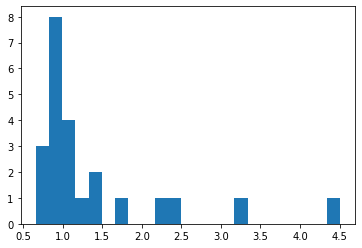

In [160]:
plt.hist(am_e_100_fish_list['latency_avg'],bins=len(am_e_100_fish_list))

(array([15.,  3.,  1.,  3.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 0.74846154,  1.66736686,  2.58627219,  3.50517751,  4.42408284,
         5.34298817,  6.26189349,  7.18079882,  8.09970414,  9.01860947,
         9.93751479, 10.85642012, 11.77532544, 12.69423077, 13.61313609,
        14.53204142, 15.45094675, 16.36985207, 17.2887574 , 18.20766272,
        19.12656805, 20.04547337, 20.9643787 , 21.88328402, 22.80218935,
        23.72109467, 24.64      ]),
 <BarContainer object of 26 artists>)

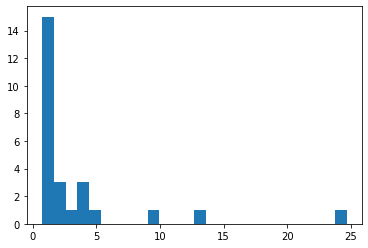

In [161]:
plt.hist(am_me_100_fish_list['latency_avg'],bins=len(am_me_100_fish_list))

{'whiskers': [<matplotlib.lines.Line2D at 0x1334b6f40>,
 'caps': [<matplotlib.lines.Line2D at 0x1334a4520>,
 'boxes': [<matplotlib.lines.Line2D at 0x1334b6d60>],
 'medians': [<matplotlib.lines.Line2D at 0x1334a4ac0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1334a4d90>],
 'means': []}

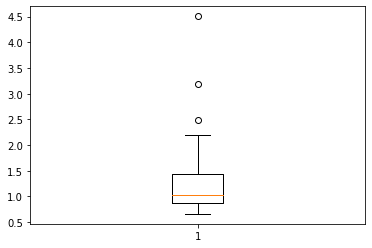

In [162]:
plt.boxplot(am_e_100_fish_list['latency_avg'])

{'whiskers': [<matplotlib.lines.Line2D at 0x13353b2b0>,
 'caps': [<matplotlib.lines.Line2D at 0x13353b850>,
 'boxes': [<matplotlib.lines.Line2D at 0x13353b0a0>],
 'medians': [<matplotlib.lines.Line2D at 0x13353bdf0>],
 'fliers': [<matplotlib.lines.Line2D at 0x133469100>],
 'means': []}

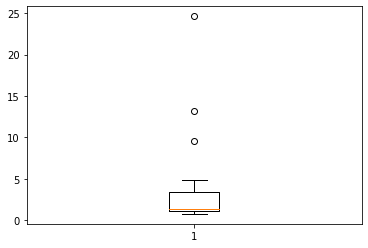

In [163]:
plt.boxplot(am_me_100_fish_list['latency_avg'])

In [164]:
from scipy.stats import poisson
data_poisson = poisson.rvs(mu=3, size=10000)

In [165]:
poisson = np.random.poisson(1, 10000)

In [166]:
stats.kstest(data_poisson, am_e_100_fish_list['latency_avg'])

KstestResult(statistic=0.6272869565217392, pvalue=2.9300492081259804e-09)

In [167]:
stats.kstest(data_poisson, am_me_100_fish_list['latency_avg'])

KstestResult(statistic=0.4550461538461538, pvalue=1.9970699205976264e-05)

In [168]:
# stats.kstest(am_me_100_fish_list['latency_avg'],stats.poisson(mu=10))
stats.kstest(am_me_100_fish_list['latency_avg'], am_e_100_fish_list['latency_avg'])

KstestResult(statistic=0.3060200668896321, pvalue=0.15867955275119117)

# Relative Freq. vs Turn Angle 

In [169]:
# relative frequency of an event is the number of times the event occurs divided by the total number of trials

In [170]:
np.histogram(am_me_C100_events['delta_theta_rad'])

(array([  3,   9,  42, 138,  89,  46,   4,   3,   2,   2]),
 array([-1.6692330e+00, -1.1134152e+00, -5.5759740e-01, -1.7796000e-03,
         5.5403820e-01,  1.1098560e+00,  1.6656738e+00,  2.2214916e+00,
         2.7773094e+00,  3.3331272e+00,  3.8889450e+00]))

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,
         3.,  0.,  0.,  0.,  0.,  1.,  0.,  2.,  0.,  3.,  4., 13., 58.,
        29., 27., 19., 15.,  9., 15., 16., 16., 20., 16., 16., 17., 26.,
         7.,  8., 14.,  2.,  6.,  9.,  7.,  4.,  4.,  1.,  1.,  0.,  1.,
         0.,  1.,  1.,  0.,  0.,  2.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([-2.94721  , -2.8701077, -2.7930054, -2.7159031, -2.6388008,
        -2.5616985, -2.4845962, -2.4074939, -2.3303916, -2.2532893,
        -2.176187 , -2.0990847, -2.0219824, -1.9448801, -1.8677778,
        -1.7906755, -1.7135732, -1.6364709, -1.5593686, -1.4822663,
        -1.405164 , -1.3280617, -1.2509594, -1.1738571, -1.0967548,
        -1.0196525, -0.9425502, -0.8654479, -0.7883456, -0.7112433,
        -0.634141 , -0.557

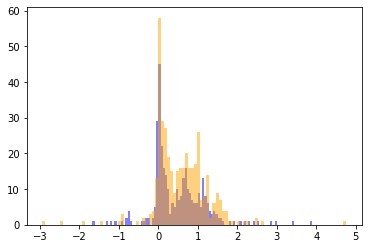

In [171]:
plt.hist(am_me_C100_events['delta_theta_rad'],bins=100,alpha=0.5,color='blue')
plt.hist(am_e_C100_events['delta_theta_rad'],bins=100,alpha=0.5,color='orange')
# plt.xlim(-5,5)

In [ ]:
am_me_C100_events

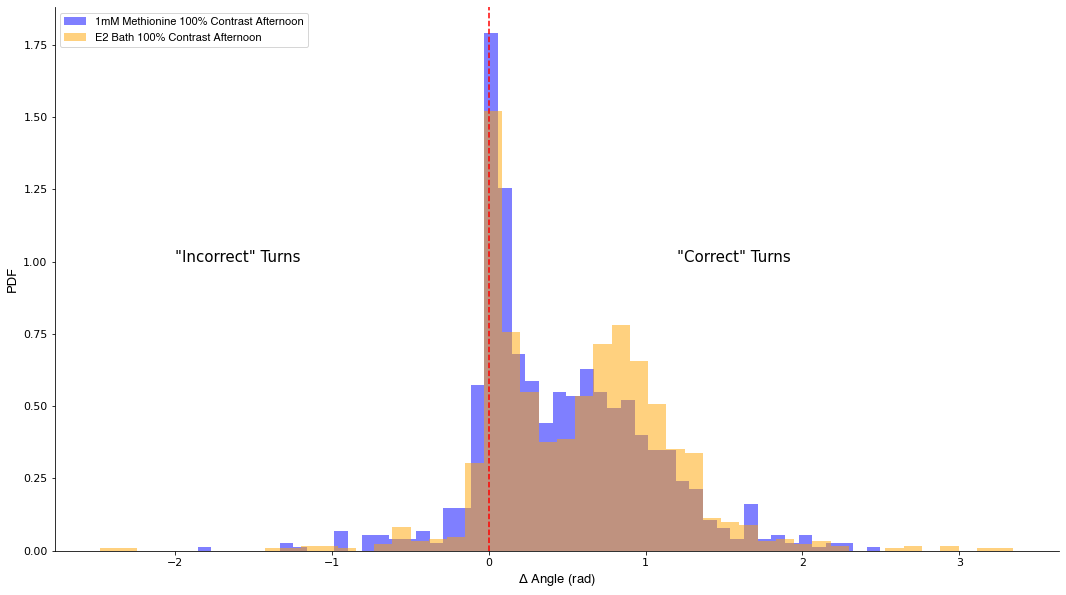

In [225]:
fig, ax = plt.subplots(1,1,figsize=(18,10))

pm_me_100_counts, pm_me_100_bins = np.histogram(pm_me_C100_events['delta_theta_rad'],bins=50)
pm_e_100_counts, pm_e_100_bins = np.histogram(pm_e_C100_events['delta_theta_rad'],bins=50)

plt.hist(pm_me_C100_events['delta_theta_rad'],bins=50,alpha=0.5,color='blue',density=True,stacked=True,histtype='stepfilled', label='1mM Methionine 100% Contrast Afternoon')
plt.hist(pm_e_C100_events['delta_theta_rad'],bins=50,alpha=0.5,color='orange',density=True,stacked=True,histtype='stepfilled', label='E2 Bath 100% Contrast Afternoon')

# ax.plot(pm_me_100_bins[1:], pm_me_100_counts,label='AM Met 100%',color='blue')
# ax.plot(pm_e_100_bins[1:], pm_e_100_counts, label='AM E2 100%',color='orange')
# ax.plot(pm_e_100_bins[:-1], pm_e_100_counts/len(pm_e_C100_events), label='AM E2 100%',color='orange')
plt.axvline(x=0,ls='--', color='r')
ax.text(-2, 1, '"Incorrect" Turns',fontsize=15)
ax.text(1.2, 1, '"Correct" Turns',fontsize=15)

plt.xlabel(r'$\Delta$ Angle (rad)',name='Helvetica',fontsize=13)
plt.ylabel('PDF',name='Helvetica',fontsize=13)

font = font_manager.FontProperties(family='Helvetica',
                                   style='normal', size=11)
plt.legend(loc='upper left',prop=font,fontsize=12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

plt.savefig('../../Dissertation/PDF_distribution_E2andMET_pm_100.png',dpi=400,bbox_inches='tight')

plt.show()

In [290]:
stats.kstest(pm_me_C1_events['delta_theta_rad'],pm_e_C1_events['delta_theta_rad'])

KstestResult(statistic=0.0950323092355425, pvalue=0.0010373969556884742)

In [297]:
def gauss(x, mu, sigma, A):
    return A*np.exp(-(x-mu)**2/2/sigma**2)

def bimodal(x, mu1, sigma1, A1, mu2, sigma2, A2):
    return gauss(x,mu1,sigma1,A1)+gauss(x,mu2,sigma2,A2)

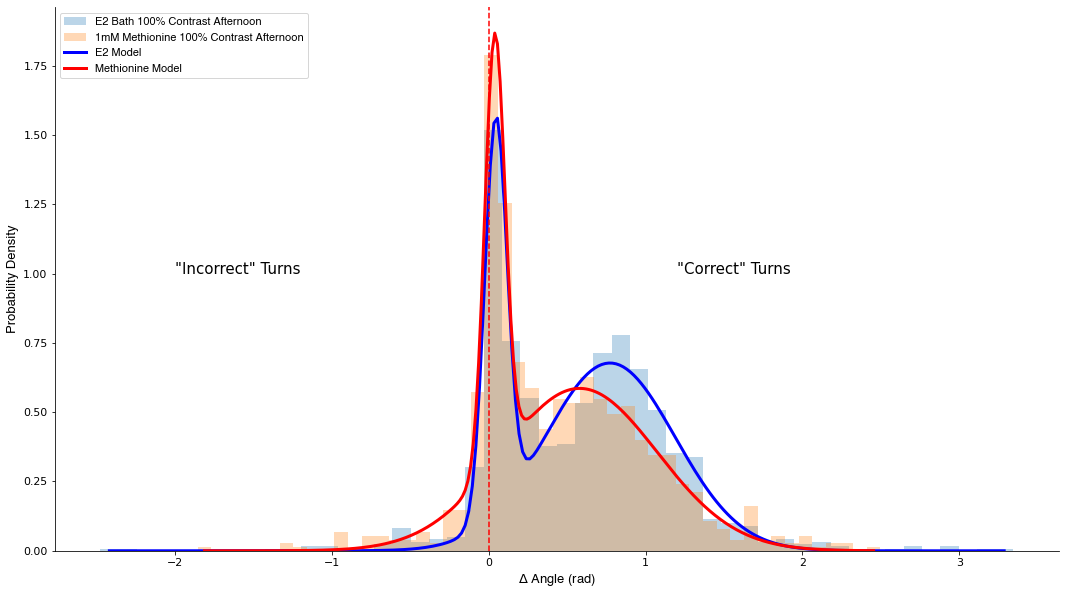

In [293]:
fig, ax = plt.subplots(1,1,figsize=(18,10))
data=pm_e_C100_events['delta_theta_rad']
y,x,_=ax.hist(data, 50, alpha=.3, density=True, label='E2 Bath 100% Contrast Afternoon')
x=(x[1:]+x[:-1])/2 

data2=pm_me_C100_events['delta_theta_rad']
y2,x2,_=ax.hist(data2, 50, alpha=.3, density=True, label='1mM Methionine 100% Contrast Afternoon')
x2=(x2[1:]+x2[:-1])/2 

expected = (0.05, 0.3, 1.5, 0.9, 1.2, 1.2)
params, cov = curve_fit(bimodal, x, y, expected)
sigma=np.sqrt(np.diag(cov))
x_fit = np.linspace(x.min(), x.max(), 250)

expected2 = (0.05, 0.3, 1.75, 0.6, 0.7, 0.6)
params2, cov2 = curve_fit(bimodal, x2, y2, expected2)
sigma2=np.sqrt(np.diag(cov2))
x_fit2 = np.linspace(x2.min(), x2.max(), 250)


ax.plot(x_fit, bimodal(x_fit, *params), color='blue', lw=3, label='E2 Model')
ax.plot(x_fit2, bimodal(x_fit2, *params2), color='red', lw=3, label='Methionine Model')

#Individual Gauss curves
# ax.plot(x_fit, gauss(x_fit, *params[:3]), color='red', lw=1, ls="--", label='distribution 1')
# ax.plot(x_fit, gauss(x_fit, *params[3:]), color='red', lw=1, ls=":", label='distribution 2')
#and the original data points if no histogram has been created before
#plt.scatter(x, y, marker="X", color="black", label="original data")

plt.axvline(x=0,ls='--', color='r')
ax.text(-2, 1, '"Incorrect" Turns',fontsize=15)
ax.text(1.2, 1, '"Correct" Turns',fontsize=15)

plt.xlabel(r'$\Delta$ Angle (rad)',name='Helvetica',fontsize=13)
plt.ylabel('Probability Density',name='Helvetica',fontsize=13)

font = font_manager.FontProperties(family='Helvetica',
                                   style='normal', size=11)
plt.legend(loc='upper left',prop=font,fontsize=12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

# plt.savefig('../../Disseation/PDF_distribution_E2andMET_pm_100.png',dpi=400,bbox_inches='tight')

plt.show()

(-4.0, 4.0)

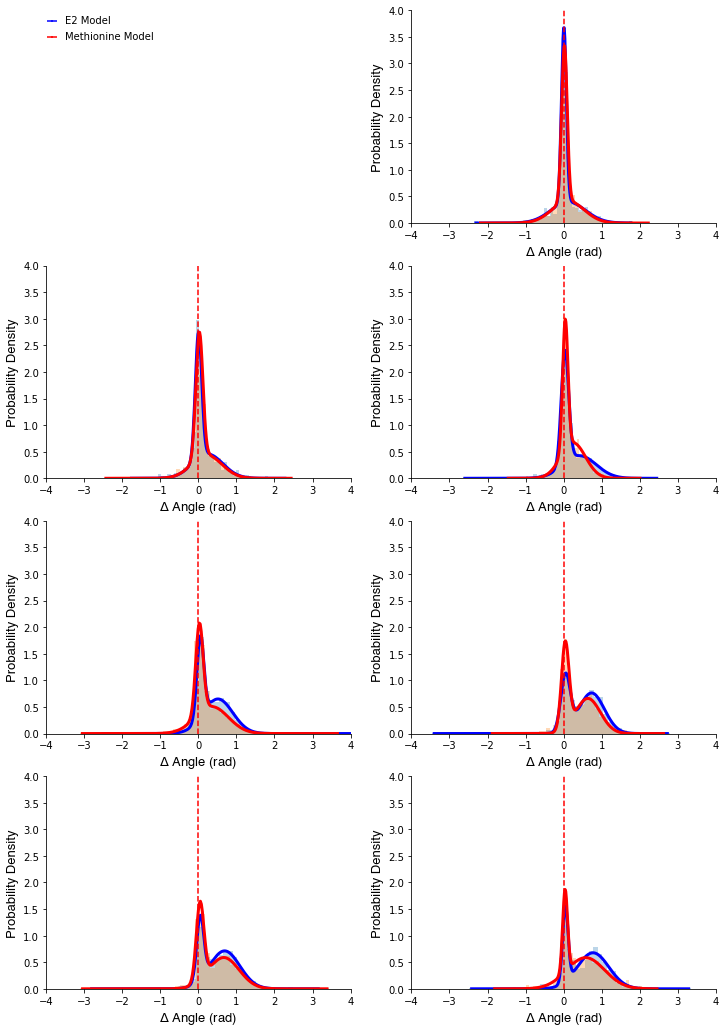

In [320]:
fig, ((ax1,ax2),(ax3,ax4),(ax5,ax6),(ax7,ax8)) = plt.subplots(4,2,figsize=(12,18))#,sharex=True,sharey=True)

# ax1 --> Contrast 0%

# data01=pm_e_events_0['delta_theta_rad']
# y01,x01,_01=ax1.hist(data01, 50, alpha=.3, density=True, label='E2 Bath 0% Contrast Afternoon')
# x01=(x01[1:]+x01[:-1])/2 

# data02=pm_me_events_0['delta_theta_rad']
# y02,x02,_02=ax1.hist(data02, 50, alpha=.3, density=True, label='1mM Methionine 0% Contrast Afternoon')
# x02=(x02[1:]+x02[:-1])/2 

# expected01 = (0.05, 0.3, 1.5, 0.9, 1.2, 1.2)
# params01, cov01 = curve_fit(bimodal, x01, y01, expected01)
# sigma01=np.sqrt(np.diag(cov01))
# x_fit01 = np.linspace(x01.min(), x01.max(), 250)

# expected02 = (0.05, 0.3, 1.75, 0.6, 0.7, 0.6)
# params02, cov02 = curve_fit(bimodal, x02, y02, expected02)
# sigma02=np.sqrt(np.diag(cov02))
# x_fit02 = np.linspace(x02.min(), x02.max(), 250)


# ax1.plot(x_fit01, bimodal(x_fit01, *params01), color='blue', lw=3, label='E2 Model')
# ax1.plot(x_fit02, bimodal(x_fit02, *params02), color='red', lw=3, label='Methionine Model')

# ax1.axvline(x=0,ls='--', color='r')

# ax1.set_xlabel(r'$\Delta$ Angle (rad)',name='Helvetica',fontsize=13)
# ax1.set_ylabel('Probability Density',name='Helvetica',fontsize=13)

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)

ax1.set_ylim(0,4)
ax1.set_xlim(-4,4)

ax1.set_xticks([])
ax1.set_yticks([])

ax1.scatter(x=-3.9,y=3.8,marker='_',c='b')
ax1.scatter(x=-3.8,y=3.8,marker='_',c='b')
ax1.text(-3.5,3.75,'E2 Model')

ax1.scatter(x=-3.9,y=3.5,marker='_',c='r')
ax1.scatter(x=-3.8,y=3.5,marker='_',c='r')
ax1.text(-3.5,3.45,'Methionine Model')

# ax1.set_xticks(fontsize=11)
# ax1.set_yticks(fontsize=11)


# ax2 --> Contrast 1%

data11=pm_e_C1_events['delta_theta_rad']
y11,x11,_11=ax2.hist(data11, 50, alpha=.3, density=True, label='E2 Bath 1% Contrast Afternoon')
x11=(x11[1:]+x11[:-1])/2 

data12=pm_me_C1_events['delta_theta_rad']
y12,x12,_12=ax2.hist(data12, 50, alpha=.3, density=True, label='1mM Methionine 1% Contrast Afternoon')
x12=(x12[1:]+x12[:-1])/2 

expected11 = (0.05, 0.3, 1.5, 0.9, 1.2, 1.2)
params11, cov11 = curve_fit(bimodal, x11, y11, expected11)
sigma11=np.sqrt(np.diag(cov11))
x_fit11 = np.linspace(x11.min(), x11.max(), 250)

expected12 = (0.05, 0.3, 1.75, 0.6, 0.7, 0.6)
params12, cov12 = curve_fit(bimodal, x12, y12, expected12)
sigma12=np.sqrt(np.diag(cov12))
x_fit12 = np.linspace(x12.min(), x12.max(), 250)


ax2.plot(x_fit11, bimodal(x_fit11, *params11), color='blue', lw=3, label='E2 Model')
ax2.plot(x_fit12, bimodal(x_fit12, *params12), color='red', lw=3, label='Methionine Model')

ax2.axvline(x=0,ls='--', color='r')

ax2.set_xlabel(r'$\Delta$ Angle (rad)',name='Helvetica',fontsize=13)
ax2.set_ylabel('Probability Density',name='Helvetica',fontsize=13)

ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

ax2.set_ylim(0,4)
ax2.set_xlim(-4,4)

# plt.xticks(fontsize=11)
# plt.yticks(fontsize=11)



# ax3 --> Contrast 10%

data101=pm_e_C10_events['delta_theta_rad']
y101,x101,_101=ax3.hist(data101, 50, alpha=.3, density=True, label='E2 Bath 10% Contrast Afternoon')
x101=(x101[1:]+x101[:-1])/2 

data102=pm_me_C10_events['delta_theta_rad']
y102,x102,_102=ax3.hist(data102, 50, alpha=.3, density=True, label='1mM Methionine 10% Contrast Afternoon')
x102=(x102[1:]+x102[:-1])/2 

expected101 = (0.05, 0.3, 1.5, 0.9, 1.2, 1.2)
params101, cov101 = curve_fit(bimodal, x101, y101, expected101)
sigma101=np.sqrt(np.diag(cov101))
x_fit101 = np.linspace(x101.min(), x101.max(), 250)

expected102 = (0.05, 0.3, 1.75, 0.6, 0.7, 0.6)
params102, cov102 = curve_fit(bimodal, x102, y102, expected102)
sigma102=np.sqrt(np.diag(cov102))
x_fit102 = np.linspace(x102.min(), x102.max(), 250)


ax3.plot(x_fit101, bimodal(x_fit101, *params101), color='blue', lw=3, label='E2 Model')
ax3.plot(x_fit102, bimodal(x_fit102, *params102), color='red', lw=3, label='Methionine Model')

ax3.axvline(x=0,ls='--', color='r')

ax3.set_xlabel(r'$\Delta$ Angle (rad)',name='Helvetica',fontsize=13)
ax3.set_ylabel('Probability Density',name='Helvetica',fontsize=13)

ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)

ax3.set_ylim(0,4)
ax3.set_xlim(-4,4)

# plt.xticks(fontsize=11)
# plt.yticks(fontsize=11)



# ax4 --> Contrast 20%

data201=pm_e_C20_events['delta_theta_rad']
y201,x201,_201=ax4.hist(data201, 50, alpha=.3, density=True, label='E2 Bath 20% Contrast Afternoon')
x201=(x201[1:]+x201[:-1])/2 

data202=pm_me_C20_events['delta_theta_rad']
y202,x202,_202=ax4.hist(data202, 50, alpha=.3, density=True, label='1mM Methionine 20% Contrast Afternoon')
x202=(x202[1:]+x202[:-1])/2 

expected201 = (0.05, 0.3, 1.5, 0.9, 1.2, 1.2)
params201, cov201 = curve_fit(bimodal, x201, y201, expected201)
sigma201=np.sqrt(np.diag(cov201))
x_fit201 = np.linspace(x201.min(), x201.max(), 250)

expected202 = (0.05, 0.3, 1.75, 0.6, 0.7, 0.6)
params202, cov202 = curve_fit(bimodal, x202, y202, expected202)
sigma202=np.sqrt(np.diag(cov202))
x_fit202 = np.linspace(x202.min(), x202.max(), 250)


ax4.plot(x_fit201, bimodal(x_fit201, *params201), color='blue', lw=3, label='E2 Model')
ax4.plot(x_fit202, bimodal(x_fit202, *params202), color='red', lw=3, label='Methionine Model')

ax4.axvline(x=0,ls='--', color='r')

ax4.set_xlabel(r'$\Delta$ Angle (rad)',name='Helvetica',fontsize=13)
ax4.set_ylabel('Probability Density',name='Helvetica',fontsize=13)

ax4.spines['right'].set_visible(False)
ax4.spines['top'].set_visible(False)

ax4.set_ylim(0,4)
ax4.set_xlim(-4,4)

# plt.xticks(fontsize=11)
# plt.yticks(fontsize=11)



# ax5 --> Contrast 30%

data301=pm_e_C30_events['delta_theta_rad']
y301,x301,_301=ax5.hist(data301, 50, alpha=.3, density=True, label='E2 Bath 30% Contrast Afternoon')
x301=(x301[1:]+x301[:-1])/2 

data302=pm_me_C30_events['delta_theta_rad']
y302,x302,_302=ax5.hist(data302, 50, alpha=.3, density=True, label='1mM Methionine 30% Contrast Afternoon')
x302=(x302[1:]+x302[:-1])/2 

expected301 = (0.05, 0.3, 1.5, 0.9, 1.2, 1.2)
params301, cov301 = curve_fit(bimodal, x301, y301, expected301)
sigma301=np.sqrt(np.diag(cov301))
x_fit301 = np.linspace(x301.min(), x301.max(), 250)

expected302 = (0.05, 0.3, 1.75, 0.6, 0.7, 0.6)
params302, cov302 = curve_fit(bimodal, x302, y302, expected302)
sigma302=np.sqrt(np.diag(cov302))
x_fit302 = np.linspace(x302.min(), x302.max(), 250)


ax5.plot(x_fit301, bimodal(x_fit301, *params301), color='blue', lw=3, label='E2 Model')
ax5.plot(x_fit302, bimodal(x_fit302, *params302), color='red', lw=3, label='Methionine Model')

ax5.axvline(x=0,ls='--', color='r')

ax5.set_xlabel(r'$\Delta$ Angle (rad)',name='Helvetica',fontsize=13)
ax5.set_ylabel('Probability Density',name='Helvetica',fontsize=13)

ax5.spines['right'].set_visible(False)
ax5.spines['top'].set_visible(False)

ax5.set_ylim(0,4)
ax5.set_xlim(-4,4)


# plt.xticks(fontsize=11)
# plt.yticks(fontsize=11)



# ax6 --> Contrast 50%

data501=pm_e_C50_events['delta_theta_rad']
y501,x501,_501=ax6.hist(data501, 50, alpha=.3, density=True, label='E2 Bath 50% Contrast Afternoon')
x501=(x501[1:]+x501[:-1])/2 

data502=pm_me_C50_events['delta_theta_rad']
y502,x502,_502=ax6.hist(data502, 50, alpha=.3, density=True, label='1mM Methionine 50% Contrast Afternoon')
x502=(x502[1:]+x502[:-1])/2 

expected501 = (0.05, 0.3, 1.5, 0.9, 1.2, 1.2)
params501, cov501 = curve_fit(bimodal, x501, y501, expected501)
sigma501=np.sqrt(np.diag(cov501))
x_fit501 = np.linspace(x501.min(), x501.max(), 250)

expected502 = (0.05, 0.3, 1.75, 0.6, 0.7, 0.6)
params502, cov502 = curve_fit(bimodal, x502, y502, expected502)
sigma502=np.sqrt(np.diag(cov502))
x_fit502 = np.linspace(x502.min(), x502.max(), 250)


ax6.plot(x_fit501, bimodal(x_fit501, *params501), color='blue', lw=3, label='E2 Model')
ax6.plot(x_fit502, bimodal(x_fit502, *params502), color='red', lw=3, label='Methionine Model')

ax6.axvline(x=0,ls='--', color='r')

ax6.set_xlabel(r'$\Delta$ Angle (rad)',name='Helvetica',fontsize=13)
ax6.set_ylabel('Probability Density',name='Helvetica',fontsize=13)

ax6.spines['right'].set_visible(False)
ax6.spines['top'].set_visible(False)

ax6.set_ylim(0,4)
ax6.set_xlim(-4,4)

# plt.xticks(fontsize=11)
# plt.yticks(fontsize=11)



# ax7 --> Contrast 70%

data701=pm_e_C70_events['delta_theta_rad']
y701,x701,_701=ax7.hist(data701, 50, alpha=.3, density=True, label='E2 Bath 70% Contrast Afternoon')
x701=(x701[1:]+x701[:-1])/2 

data702=pm_me_C70_events['delta_theta_rad']
y702,x702,_702=ax7.hist(data702, 50, alpha=.3, density=True, label='1mM Methionine 70% Contrast Afternoon')
x702=(x702[1:]+x702[:-1])/2 

expected701 = (0.05, 0.3, 1.5, 0.9, 1.2, 1.2)
params701, cov701 = curve_fit(bimodal, x701, y701, expected701)
sigma701=np.sqrt(np.diag(cov701))
x_fit701 = np.linspace(x701.min(), x701.max(), 250)

expected702 = (0.05, 0.3, 1.75, 0.6, 0.7, 0.6)
params702, cov702 = curve_fit(bimodal, x702, y702, expected702)
sigma702=np.sqrt(np.diag(cov702))
x_fit702 = np.linspace(x702.min(), x702.max(), 250)


ax7.plot(x_fit701, bimodal(x_fit701, *params701), color='blue', lw=3, label='E2 Model')
ax7.plot(x_fit702, bimodal(x_fit702, *params702), color='red', lw=3, label='Methionine Model')

ax7.axvline(x=0,ls='--', color='r')

ax7.set_xlabel(r'$\Delta$ Angle (rad)',name='Helvetica',fontsize=13)
ax7.set_ylabel('Probability Density',name='Helvetica',fontsize=13)

ax7.spines['right'].set_visible(False)
ax7.spines['top'].set_visible(False)

ax7.set_ylim(0,4)
ax7.set_xlim(-4,4)

# plt.xticks(fontsize=11)
# plt.yticks(fontsize=11)



# ax8 --> Contrast 100%

data1001=pm_e_C100_events['delta_theta_rad']
y1001,x1001,_1001=ax8.hist(data1001, 50, alpha=.3, density=True, label='E2 Bath 100% Contrast Afternoon')
x1001=(x1001[1:]+x1001[:-1])/2 

data1002=pm_me_C100_events['delta_theta_rad']
y1002,x1002,_1002=ax8.hist(data1002, 50, alpha=.3, density=True, label='1mM Methionine 100% Contrast Afternoon')
x1002=(x1002[1:]+x1002[:-1])/2 

expected1001 = (0.05, 0.3, 1.5, 0.9, 1.2, 1.2)
params1001, cov1001 = curve_fit(bimodal, x1001, y1001, expected1001)
sigma1001=np.sqrt(np.diag(cov1001))
x_fit1001 = np.linspace(x1001.min(), x1001.max(), 250)

expected1002 = (0.05, 0.3, 1.75, 0.6, 0.7, 0.6)
params1002, cov1002 = curve_fit(bimodal, x1002, y1002, expected1002)
sigma1002=np.sqrt(np.diag(cov1002))
x_fit1002 = np.linspace(x1002.min(), x1002.max(), 250)


ax8.plot(x_fit1001, bimodal(x_fit1001, *params1001), color='blue', lw=3, label='E2 Model')
ax8.plot(x_fit1002, bimodal(x_fit1002, *params1002), color='red', lw=3, label='Methionine Model')

ax8.axvline(x=0,ls='--', color='r')

ax8.set_xlabel(r'$\Delta$ Angle (rad)',name='Helvetica',fontsize=13)
ax8.set_ylabel('Probability Density',name='Helvetica',fontsize=13)

ax8.spines['right'].set_visible(False)
ax8.spines['top'].set_visible(False)

ax8.set_ylim(0,4)
ax8.set_xlim(-4,4)

# plt.xticks(fontsize=11)
# plt.yticks(fontsize=11)